In [1]:
%%capture
!pip install gymnasium
!pip install gymnasium[classic-control]

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import time
import os
import datetime
import copy

import import_ipynb
from truly_plastic_p6 import plastic_nn
from truly_plastic_p6 import input_layer
from truly_plastic_p6 import layer

importing Jupyter notebook from truly_plastic_p6.ipynb


In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [2]:

class replay_memory():
    def __init__(s, maxlen):
        s.memory = deque([], maxlen=maxlen)

    def append(s, transition):
        s.memory.append(transition)

    def sample(s, sample_size):
        return random.sample(s.memory, sample_size)

    def __len__(s):
        return len(s.memory)



class DQN():
   
    def __init__(s, ct = 0, tag=0, path = r'test', 
                 game_name = 'MountainCar-v0', 
                  
                 mini_batch_size = 32,  num_divisions = 1, 
                 replay_memory_size = 100000, 
                 network_sync_rate = 50000, discount_factor_g = 0.9):
        
        if (ct == 0):
            ct = datetime.datetime.now()
            ct = str(ct)
            ct = ct.replace(":", "-")
            ct = ct.replace(" ", "_")
            ct = ct[:-7]

        s.ct = ct
        current_directory = os.getcwd()
        final_directory_pics = os.path.join(current_directory, s.ct)
        
        final_directory_pics = os.path.join(final_directory_pics, 'pics')
        if not os.path.exists(final_directory_pics):
            os.makedirs(final_directory_pics)
        
        if (tag != 0):
            s.set_tag(tag)

        s.game_name = game_name
        s.discount_factor_g = discount_factor_g
         
        s.mini_batch_size = mini_batch_size 
        s.num_divisions = num_divisions

        # Divide position and velocity into segments
        s.lin_spaces = []
        env = gym.make(s.game_name)
        obs_space = env.observation_space

        for i in range(obs_space.shape[0]):
            s.lin_spaces.append(np.linspace(env.observation_space.low[i], env.observation_space.high[i], s.num_divisions))

        env.close()

        
        s.is_desrcete = False if num_divisions == 1 else False
        
        s.replay_memory_size =  replay_memory_size 
        s.network_sync_rate = network_sync_rate
        
    def set_tag(s, tag):
        s.tag = tag
        s.path = s.ct+'/'+s.tag
        current_directory = os.getcwd()
        final_directory = os.path.join(current_directory, s.path)
        if not os.path.exists(final_directory):
            os.makedirs(final_directory)
        
   
    def plot_progress(self, rewards_per_episode_, epsilon_history_):
        
        plt.figure()
        
        plt.xlabel('epochs')
        plt.ylabel('reward')
        plt.plot(rewards_per_episode_)

        plt.savefig(f'{self.path}/info_rew_{self.tag}.png'.format(self.path, self.tag))
        plt.savefig(f'{self.ct}/pics/info_rew_{self.tag}.png')
        plt.close()

        plt.figure()
        
        plt.xlabel('epochs')
        plt.ylabel('epsilon')
        plt.plot(epsilon_history_)
        plt.savefig(f'{self.path}/info_eps_{self.tag}.png'.format(self.path, self.tag))
        plt.close()

    
    def save_info(s, info):
        file_path = f'{s.path}/info_{s.tag}.txt'.format(s.path, s.tag)
        f = open(file_path, "a")   
       
        f.write("data {}\n".format(s.ct))
        f.write("tag {}\n".format(s.tag))
        f.write("game_name {}\n".format(s.game_name))
        f.write("reward discount factor {}\n".format(s.discount_factor_g))
        f.write("minibatch size {}\n".format(s.mini_batch_size))
        f.write("num divisions{}\n".format(s.num_divisions))
        f.write("replay memory size {}\n".format(s.replay_memory_size))
        f.write("network sync rate {}\n".format(s.network_sync_rate))
        f.write("info {}\n".format(info))
                         
        f.close()
    
    def add_log_data(s, data):
        file_path = f'{s.path}/info_{s.tag}.txt'.format(s.path, s.tag)
        f = open(file_path, "a") 
        f.write("{}\n".format(data))
                         
        f.close()
        
    def save_reward_data(s, data):
        file_path = f'{s.path}/rewards_{s.tag}.txt'.format(s.path, s.tag)
        f = open(file_path, "a") 
        f.write("{}\n".format(data))
                         
        f.close()



    
    def run_one_epoch(s, i):
        s.state = s.env.reset()[0]
        s.terminated = False
        s.truncated = False
        s.rewards = 0

        while(not s.terminated and s.rewards < 300 ):# and s.rewards < 300 for cart_pole and s.rewards > -1000 for MC
            if random.random() < s.epsilon:
                s.action = s.env.action_space.sample()
            else:
                s.res = s.policy_dqn.forward(s.state_to_dqn_input(s.state))
                s.action = s.res.argmax().item()

            s.new_state, s.reward, s.terminated, s.truncated, _ = s.env.step(s.action)
            s.rewards += s.reward
            s.memory.append((s.state, s.action, s.new_state, s.reward, s.terminated))
            s.state = s.new_state
            
            s.step_count+=1
 
        
        if(s.terminated):
            s.goal_reached = True

        s.rewards_per_episode.append(s.rewards)
        
        
        if(i!=0 and i%1000==0): # Graph training progress
            print(f'Episode {i} Epsilon {s.epsilon}')
            
            s.policy_dqn.save(f'{s.path}/mc_policy_{i}'.format(s.path, i))
            s.add_log_data(f'Episode {i} Epsilon {s.epsilon}')
            
            s.plot_progress(s.rewards_per_episode, s.epsilon_history)

        
        if s.rewards > s.best_rewards:
            s.best_rewards = s.rewards
            
            print(f'Best rewards so far: {s.best_rewards}')
            s.add_log_data(f'Best rewards so far: {s.best_rewards}')
            s.policy_dqn.save(f'{s.path}/mc_policy_{i}'.format(s.path, i))
            s.policy_dqn.save(f'{s.path}/mc_policy_best'.format(s.path))
            

        if len(s.memory) > s.mini_batch_size and s.goal_reached: # if enough experience has been collected

            s.mini_batch = s.memory.sample(s.mini_batch_size)
            s.optimize(s.mini_batch)

            # Decay epsilon
            s.epsilon = max(s.epsilon - 1/s.episodes, 0.01) 
            s.epsilon_history.append(s.epsilon)

            # Copy policy network to target network after a certain number of steps
            if s.step_count > s.network_sync_rate:
                s.target_dqn = s.policy_dqn.deep_copy()
                s.step_count = 0

        return s.rewards
    


    
    def init_train_data(s, policy_dqn, episodes):
        s.policy_dqn = policy_dqn
        s.target_dqn = plastic_nn()
        s.target_dqn = policy_dqn.deep_copy()

        
        s.epsilon = 1 # 1 = 100% random actions
        s.memory = replay_memory(s.replay_memory_size)

        s.rewards_per_episode = []
        s.epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        s.step_count = 0
        s.goal_reached = False
        s.best_rewards = -200 #-1000 (mc)

        s.episodes = episodes 
        s.env = gym.make(s.game_name)

    
    def train(s, episodes):
        # main training
        for i in range(s.episodes+1):
            s.run_one_epoch(i)


    def post_train(s):
                
        s.env.close()
        s.policy_dqn.save(f'{s.path}/mc_policy_last_{s.tag}'.format(s.path, s.tag))
        
        if (s.best_rewards == -200): #update best -1000
            s.policy_dqn.save(f'{s.path}/mc_policy_best'.format(s.path))
            
        s.save_reward_data(s.rewards_per_episode)


    
    def optimize(s, mini_batch):
        s.target_q_list = []
        s.input_list = []
        
        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                s.target = reward
            else:
                s.target = reward + s.discount_factor_g * s.target_dqn.forward(s.state_to_dqn_input(new_state)).max()

            # Get the target set of Q values
            s.state_dsc = np.asarray(s.state_to_dqn_input(state))
            s.input_list.append(s.state_dsc)
            
            s.target_q = s.target_dqn.forward(s.state_dsc)
            
            # Adjust the specific action to the target that was just calculated
            s.target_q[action] = s.target            
            s.target_q_list.append(s.target_q)

        #BACKPOP AND UPDATE on minibatch
        x = np.asarray(s.input_list)
        x = x[:, :, 0]
        x = x.T

        y = np.asarray(s.target_q_list)
        y = y[:, :, 0]
        y = y.T

        s.policy_dqn.learn_one(x, y)



    def state_to_dqn_input(s, state):
        
        if (not s.is_desrcete):
            return np.asarray([state]).T
        else:
            d_state = []
            for i in range(state.shape[0]):
                dig = np.digitize(state[i], s.lin_spaces[i])
                d_state.append(np.asarray([dig]))
        
            return np.asarray(d_state)


        

    def test(self, policy_dqn, episodes, render = False):
        env = gym.make(self.game_name, render_mode='human' if render else None)
        
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        done_count = 0
        medium_reward = 0
        reward_list = []
        
        for i in range(episodes):
            state, info = env.reset() 
            done = False
            truncated = False 
            rewards = 0

            while(not done and not truncated):
                state = self.state_to_dqn_input(state)

                res = policy_dqn.forward(state)

                action = res.argmax().item()

                state, reward, done, truncated, _ = env.step(action)
                rewards+=reward
                if (truncated):
                    done_count += 1
                    break

            medium_reward += rewards
            reward_list.append(rewards)
                

        
        env.close()
        medium_reward = medium_reward / episodes
        return done_count*100.0/episodes, medium_reward, reward_list
        



## alg

In [5]:
# learning_rate_a = 0.001
# game_name = "MountainCar-v0"
# env = gym.make(game_name)
# in_states = env.observation_space.shape[0]
# out_actions = env.action_space.n
# env.close()


# h1_nodes = 3
# h2_nodes = 2

# a_type1 = 'ReLU'
# a_type2 = 'Linear'


# num_of_nn = 5


# dqn_s = []


# ct = datetime.datetime.now()
# ct = str(ct)
# ct = ct.replace(":", "-")
# ct = ct.replace(" ", "_")
# ct = ct[:-7]

# for i in range(num_of_nn):
#     print(i)
#     layers_net = [input_layer(in_states), 
#     layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_type1), 
#     layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_type1), 
#     layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_type2)]
    
#     policy_dqn = plastic_nn(optimizer="Adam")
#     policy_dqn.append_layers(layers_net)
    
#     dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 50)
#     dqn_test.set_tag(str(i))
    
#     dqn_s.append(dqn_test)
#     #time.sleep(60)
    
# episodes = 2000

# for i in range (num_of_nn):
#     print(i)
#     dqn_s[i].init_train_data(policy_dqn, episodes)

# #mean_results = []
# summs = np.zeros(shape = episodes+1)
# for i in range (num_of_nn):
#     summ = 0
#     for e in range(episodes + 1):
#         summs[e] += dqn_s[i].run_one_epoch(e)
#     #mean_results.append(summ/num_of_nn)
#     #print(res)
        
# for i in range (num_of_nn):
#     print(i)
#     dqn_s[i].post_train()

# mean_results = summs / num_of_nn
# plt.figure()

# plt.xlabel('epochs')
# plt.ylabel('mean reward')
# plt.plot(mean_results)
# plt.show()
# plt.close()


## main

In [3]:
learning_rate_a = 0.1
game_name = "CartPole-v0"
env = gym.make(game_name)
in_states = env.observation_space.shape[0]
out_actions = env.action_space.n
env.close()
a_types = [ '', 'ReLU', 'ReLU', 'Linear']

num_of_nn = 3


topology_lists = [6]
        
episodes = 10000

total_time_start = time.time()

for t in topology_lists:
    this_time_start = time.time()
    print(t, this_time_start)
    
    h1_nodes = t
    h2_nodes = t
 
    dqn_s = []
  
    ct = datetime.datetime.now()
    ct = str(ct)
    ct = ct.replace(":", "-")
    ct = ct.replace(" ", "_")
    ct = ct[:-7]
    ct = ct + '_' + str(t)

    # preset models
    
    for i in range(num_of_nn):
        #print(i)
        layers_net = [input_layer(in_states), 
        layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_types[1]), 
        layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_types[2]), 
        layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_types[3])]
        
        topology = [in_states, h1_nodes, h2_nodes,  out_actions]
        
        policy_dqn = plastic_nn(optimizer="Adam")
        policy_dqn.append_layers(layers_net)
        
        dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 1)
        dqn_test.set_tag(str(i))
        dqn_test.save_info(f'lr: {learning_rate_a} \n{topology} \na:{a_types}\n')
        
        dqn_s.append(dqn_test)
        dqn_s[i].init_train_data(policy_dqn, episodes)


    
    summs = np.zeros(shape = episodes+1)
    tests = np.zeros(shape = (episodes+1))
    # одномвременно
    for e in range(episodes + 1):
        for i in range (num_of_nn):  
            summs[e] += dqn_s[i].run_one_epoch(e)
            # if (e % 500 == 0):
            #     test_dqn = plastic_nn(optimizer="Adam")
            #     test_dqn.load(f'{dqn_s[i].path}/mc_policy_best')
            #     succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn, episodes = 100)
            #     print(i,' success percent  ', succ_perc, ' mean reward ', mean_reward)
            #     tests[e] += mean_reward
    
    
    # последовательно
    # for i in range (num_of_nn):
    #     for e in range(episodes + 1):
    #         summs[e] += dqn_s[i].run_one_epoch(e)
            

    best_test_result = 0
    best_res_idx = -1
    for i in range (num_of_nn):
        #print(i)
        test_dqn = plastic_nn(optimizer="Adam")
        test_dqn.load(f'{dqn_s[i].path}/mc_policy_best')
        succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn, episodes = 100)
        if (mean_reward > best_test_result):
            best_test_result = mean_reward
            best_res_idx = i
            
        print('final: success percent  ', succ_perc, ' mean reward ', mean_reward)
        dqn_s[i].post_train()
    

    this_time_end = time.time()
    this_time_diff = this_time_end - this_time_start
    print(this_time_diff)

    mean_results = np.asarray(summs) / num_of_nn
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('mean reward')
    plt.plot(mean_results)  
    plt.savefig(f'{dqn_s[0].ct}/mean_values.png')
    plt.show()
    plt.close()



   

total_time_end = time.time()

total_time_diff = total_time_end - total_time_start
print(total_time_diff)
print(best_res_idx, ' ', best_test_result)

C:\Users\basil\AppData\Roaming\Python\Python39\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


6 1718481263.5289187
Best rewards so far: 11.0
Best rewards so far: 23.0
Best rewards so far: 12.0
Best rewards so far: 32.0
Best rewards so far: 28.0
Best rewards so far: 41.0
Best rewards so far: 84.0
Best rewards so far: 62.0
Best rewards so far: 45.0
Best rewards so far: 51.0
Best rewards so far: 54.0
Best rewards so far: 64.0
Best rewards so far: 68.0
Best rewards so far: 85.0
Best rewards so far: 79.0
Best rewards so far: 102.0
Best rewards so far: 94.0
Best rewards so far: 88.0
Episode 1000 Epsilon 0.900200000000011
Episode 1000 Epsilon 0.900200000000011
Episode 1000 Epsilon 0.900300000000011


KeyboardInterrupt: 

In [47]:
dqn_test = DQN(ct = '0', game_name = game_name, mini_batch_size = 64, num_divisions = 1)

In [48]:
test_dqn = plastic_nn(optimizer="Adam")
test_dqn.load(f'{dqn_s[best_res_idx].path}/mc_policy_best')

In [49]:
succ_perc, mean_reward, reward_list = dqn_test.test(test_dqn, 1000, False)
print(mean_reward)

110.919


In [50]:
test_dqn.add_neuron(layer_number = 1, n_of_neurons = 1, value = 0)
test_dqn.add_neuron(layer_number = 2, n_of_neurons = 1, value = 0)

In [51]:
succ_perc, mean_reward, reward_list = dqn_test.test(test_dqn, 1000, False)
print(succ_perc, mean_reward)

0.0 110.826


In [3]:
def show_plot(x_label, y_label, value, path_save):
    mean_test_results = np.asarray(tests) / num_of_nn
    
    plt.figure()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(value)    
    plt.savefig(path_save)
    plt.show()
    plt.close()

In [14]:
roll = '111'


HIDDEN SIZE:  3 3
Best rewards so far: 11.0
0  success percent   0.0  mean reward  9.44
Best rewards so far: 24.0
1  success percent   0.0  mean reward  9.35
Best rewards so far: 31.0
2  success percent   0.0  mean reward  9.39
Best rewards so far: 33.0
Best rewards so far: 33.0
Best rewards so far: 56.0
Best rewards so far: 26.0
Best rewards so far: 58.0
Best rewards so far: 31.0
Best rewards so far: 38.0
Best rewards so far: 146.0
Best rewards so far: 34.0
Best rewards so far: 36.0
Best rewards so far: 54.0
Best rewards so far: 39.0
Best rewards so far: 51.0
Best rewards so far: 66.0
Best rewards so far: 61.0
Best rewards so far: 81.0
Best rewards so far: 64.0
Best rewards so far: 118.0
Best rewards so far: 71.0
0  success percent   0.0  mean reward  9.26
1  success percent   0.0  mean reward  9.54
2  success percent   0.0  mean reward  9.43
Best rewards so far: 89.0
Best rewards so far: 90.0
Best rewards so far: 96.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  

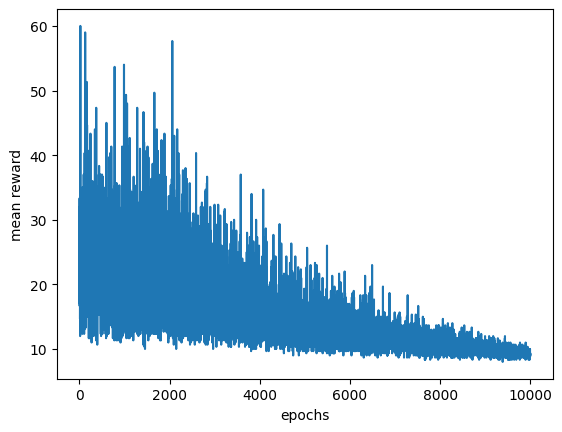

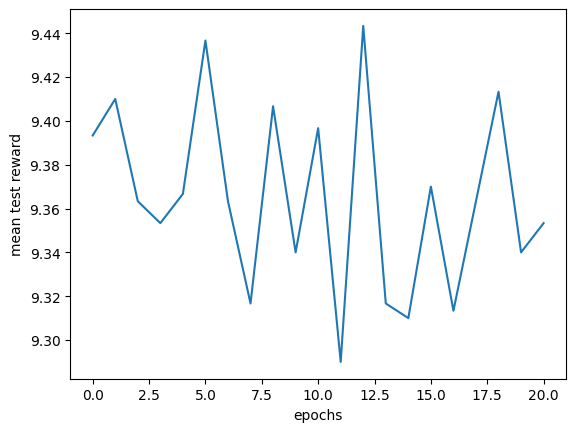

best_res_idx  0   9.36
TIME:  2.5394726753234864  min

HIDDEN SIZE:  4 3
Best rewards so far: 21.0
0  success percent   0.0  mean reward  9.42
Best rewards so far: 34.0
1  success percent   0.0  mean reward  9.36
Best rewards so far: 34.0
2  success percent   0.0  mean reward  9.21
Best rewards so far: 57.0
Best rewards so far: 37.0
Best rewards so far: 36.0
Best rewards so far: 75.0
Best rewards so far: 45.0
Best rewards so far: 61.0
Best rewards so far: 64.0
Best rewards so far: 69.0
Best rewards so far: 65.0
Best rewards so far: 84.0
Best rewards so far: 71.0
Best rewards so far: 104.0
0  success percent   0.0  mean reward  9.19
1  success percent   0.0  mean reward  9.26
2  success percent   0.0  mean reward  9.45
Best rewards so far: 86.0
Best rewards so far: 93.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.27
Episode 1000 Epsilon 0.900200000000011
1  success percent   0.0  mean reward  9.31
Episode 1000 Epsilon 0.900300000000011
2  success perc

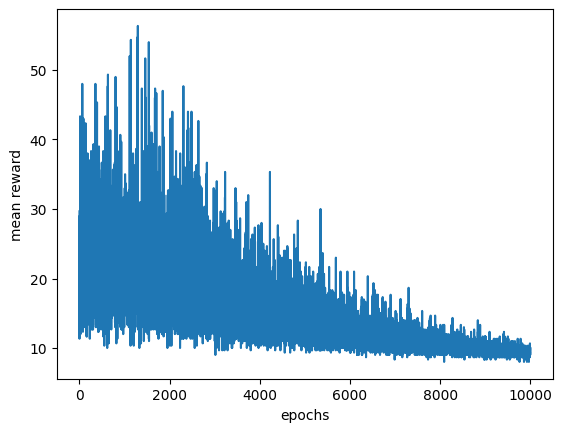

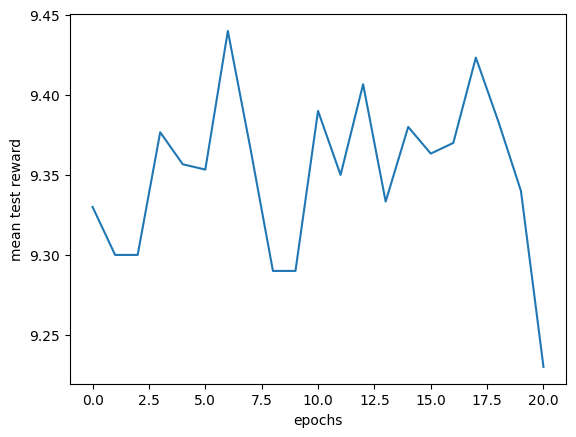

best_res_idx  2   9.41
TIME:  2.696295607089996  min

HIDDEN SIZE:  4 4
Best rewards so far: 11.0
0  success percent   0.0  mean reward  9.51
Best rewards so far: 14.0
1  success percent   0.0  mean reward  9.37
Best rewards so far: 15.0
2  success percent   0.0  mean reward  9.28
Best rewards so far: 21.0
Best rewards so far: 19.0
Best rewards so far: 16.0
Best rewards so far: 42.0
Best rewards so far: 21.0
Best rewards so far: 24.0
Best rewards so far: 35.0
Best rewards so far: 34.0
Best rewards so far: 56.0
Best rewards so far: 40.0
Best rewards so far: 96.0
Best rewards so far: 98.0
Best rewards so far: 63.0
Best rewards so far: 67.0
Best rewards so far: 81.0
Best rewards so far: 109.0
0  success percent   0.0  mean reward  9.34
1  success percent   0.0  mean reward  9.28
2  success percent   0.0  mean reward  9.33
Best rewards so far: 104.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.46
Episode 1000 Epsilon 0.900300000000011
1  success percent  

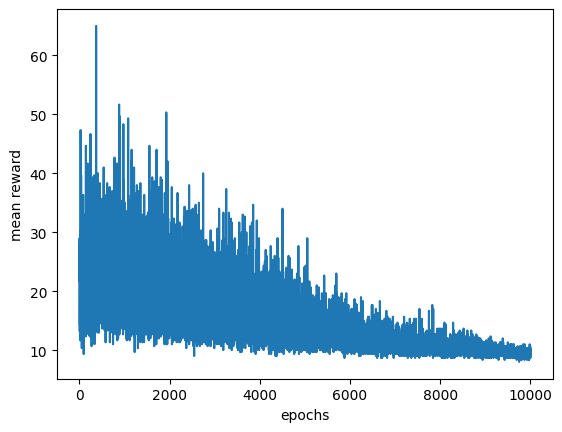

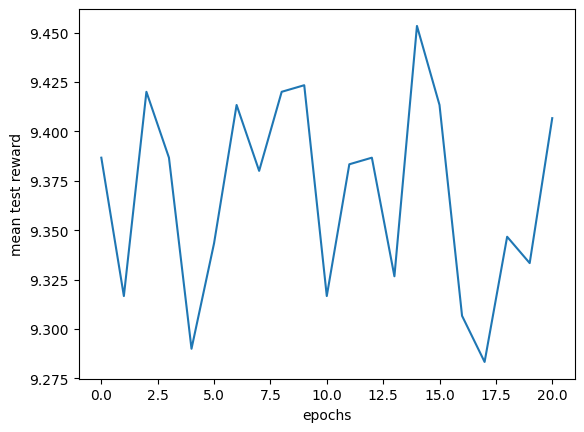

best_res_idx  0   9.41
TIME:  2.5060850501060488  min

HIDDEN SIZE:  5 4
Best rewards so far: 12.0
0  success percent   0.0  mean reward  9.35
Best rewards so far: 13.0
1  success percent   0.0  mean reward  9.44
Best rewards so far: 16.0
2  success percent   0.0  mean reward  9.23
Best rewards so far: 14.0
Best rewards so far: 22.0
Best rewards so far: 26.0
Best rewards so far: 29.0
Best rewards so far: 60.0
Best rewards so far: 40.0
Best rewards so far: 30.0
Best rewards so far: 41.0
Best rewards so far: 52.0
Best rewards so far: 36.0
Best rewards so far: 47.0
Best rewards so far: 59.0
Best rewards so far: 71.0
Best rewards so far: 66.0
Best rewards so far: 88.0
Best rewards so far: 93.0
Best rewards so far: 88.0
0  success percent   0.0  mean reward  9.66
1  success percent   0.0  mean reward  9.56
2  success percent   0.0  mean reward  9.43
Best rewards so far: 98.0
Best rewards so far: 91.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.26
Episode 

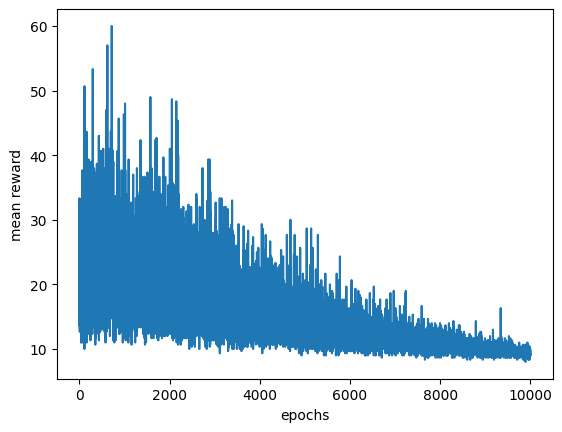

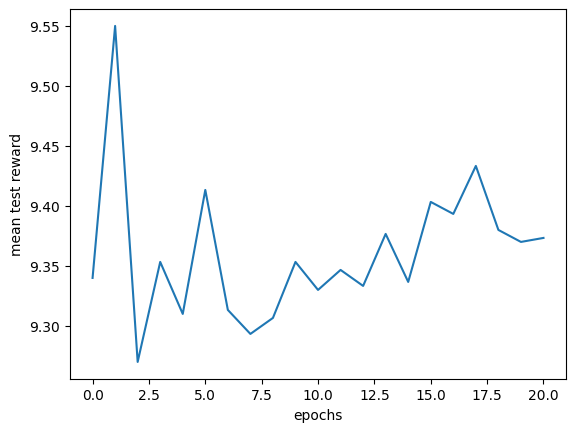

best_res_idx  2   9.43
TIME:  2.4753047664960226  min

HIDDEN SIZE:  5 5
Best rewards so far: 48.0
0  success percent   0.0  mean reward  9.32
Best rewards so far: 16.0
1  success percent   0.0  mean reward  9.3
Best rewards so far: 19.0
2  success percent   0.0  mean reward  9.41
Best rewards so far: 31.0
Best rewards so far: 23.0
Best rewards so far: 33.0
Best rewards so far: 26.0
Best rewards so far: 51.0
Best rewards so far: 29.0
Best rewards so far: 49.0
Best rewards so far: 47.0
Best rewards so far: 52.0
Best rewards so far: 54.0
Best rewards so far: 96.0
Best rewards so far: 55.0
Best rewards so far: 79.0
Best rewards so far: 58.0
Best rewards so far: 85.0
Best rewards so far: 92.0
0  success percent   0.0  mean reward  9.94
1  success percent   0.0  mean reward  9.83
2  success percent   0.0  mean reward  9.74
Best rewards so far: 102.0
Best rewards so far: 91.0
Best rewards so far: 107.0
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  9.44
Episode

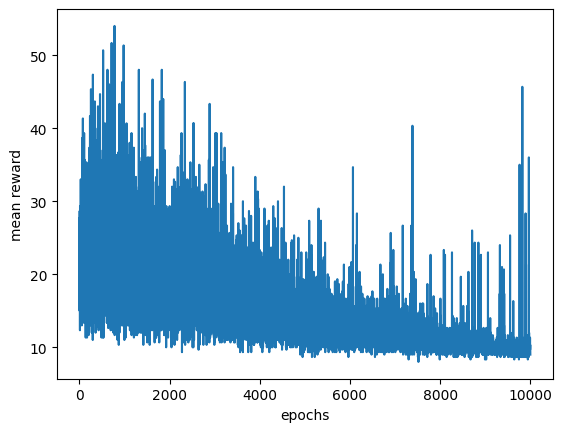

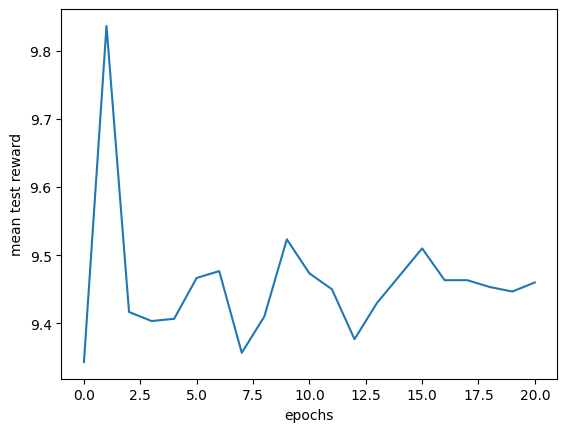

best_res_idx  2   9.69
TIME:  2.5161790251731873  min

HIDDEN SIZE:  6 5
Best rewards so far: 40.0
0  success percent   0.0  mean reward  10.03
Best rewards so far: 15.0
1  success percent   0.0  mean reward  10.0
Best rewards so far: 17.0
2  success percent   0.0  mean reward  10.07
Best rewards so far: 44.0
Best rewards so far: 47.0
Best rewards so far: 28.0
Best rewards so far: 56.0
Best rewards so far: 55.0
Best rewards so far: 44.0
Best rewards so far: 45.0
Best rewards so far: 115.0
Best rewards so far: 76.0
Best rewards so far: 61.0
Best rewards so far: 76.0
Best rewards so far: 85.0
Best rewards so far: 98.0
Best rewards so far: 137.0
0  success percent   0.0  mean reward  93.45
1  success percent   0.0  mean reward  64.32
2  success percent   0.0  mean reward  76.14
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  91.85
Episode 1000 Epsilon 0.900300000000011
1  success percent   0.0  mean reward  67.87
Episode 1000 Epsilon 0.900200000000011
2  succ

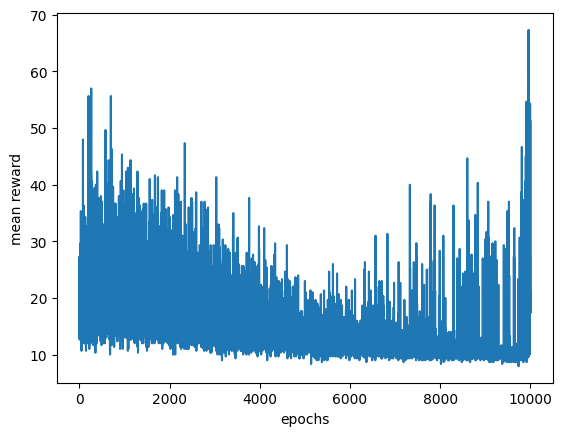

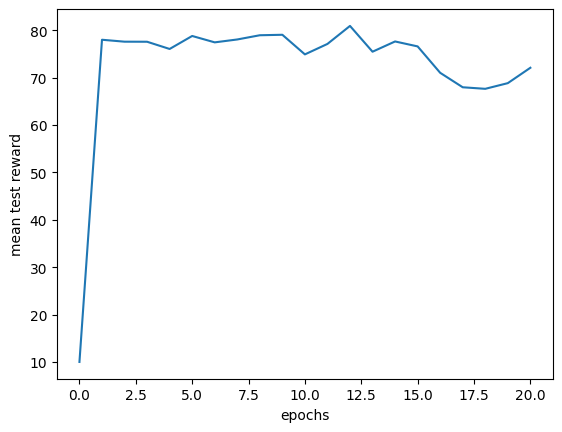

best_res_idx  0   90.84
TIME:  2.976605598131816  min

HIDDEN SIZE:  6 6
Best rewards so far: 16.0
0  success percent   0.0  mean reward  91.75
Best rewards so far: 36.0
1  success percent   0.0  mean reward  91.49
Best rewards so far: 43.0
2  success percent   0.0  mean reward  89.08
Best rewards so far: 42.0
Best rewards so far: 45.0
Best rewards so far: 54.0
Best rewards so far: 47.0
Best rewards so far: 75.0
Best rewards so far: 53.0
Best rewards so far: 56.0
Best rewards so far: 64.0
Best rewards so far: 88.0
Best rewards so far: 73.0
Best rewards so far: 118.0
Best rewards so far: 81.0
Best rewards so far: 85.0
0  success percent   0.0  mean reward  9.75
1  success percent   0.0  mean reward  10.42
2  success percent   0.0  mean reward  32.33
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.79
Episode 1000 Epsilon 0.900100000000011
1  success percent   0.0  mean reward  10.37
Episode 1000 Epsilon 0.900100000000011
2  success percent   0.0  mean rewa

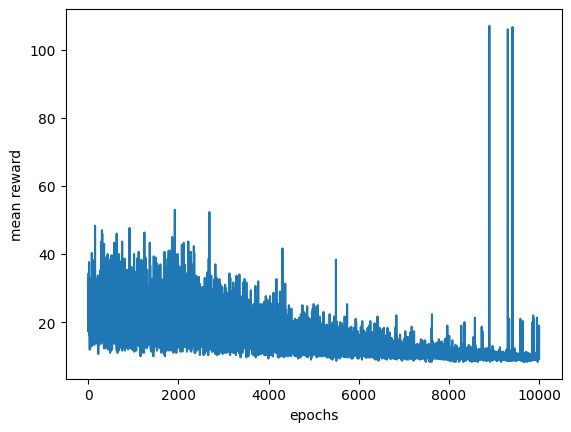

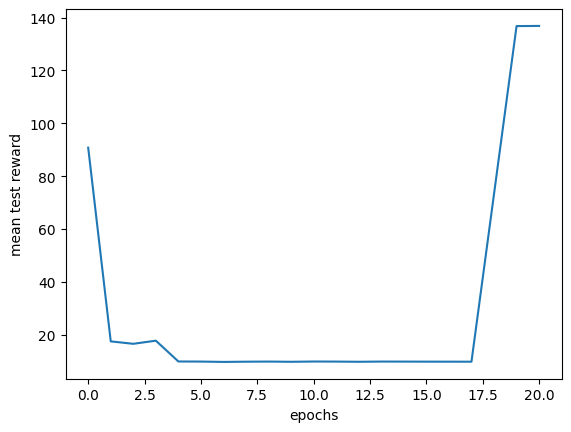

best_res_idx  0   200.0
[4, 6, 6, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 35.0
0  success percent   0.0  mean reward  9.43
Best rewards so far: 15.0
1  success percent   0.0  mean reward  9.5
Best rewards so far: 13.0
2  success percent   0.0  mean reward  9.39
Best rewards so far: 18.0
Best rewards so far: 17.0
Best rewards so far: 23.0
Best rewards so far: 32.0
Best rewards so far: 62.0
Best rewards so far: 34.0
Best rewards so far: 24.0
Best rewards so far: 27.0
Best rewards so far: 66.0
Best rewards so far: 36.0
Best rewards so far: 38.0
Best rewards so far: 35.0
Best rewards so far: 38.0
Best rewards so far: 47.0
Best rewards so far: 81.0
Best rewards so far: 41.0
Best rewards so far: 66.0
Best rewards so far: 103.0
Best rewards so far: 75.0
Best rewards so far: 80.0
Best rewards so far: 95.0
0  success percent   0.0  mean reward  9.25
1  success percent   0.0  mean reward  14.06
2  success percent   0.0  mean reward

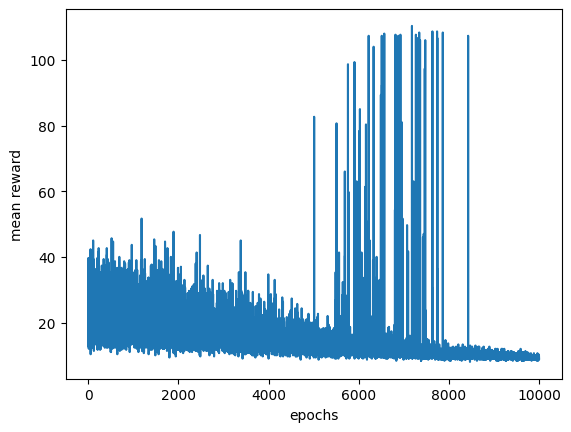

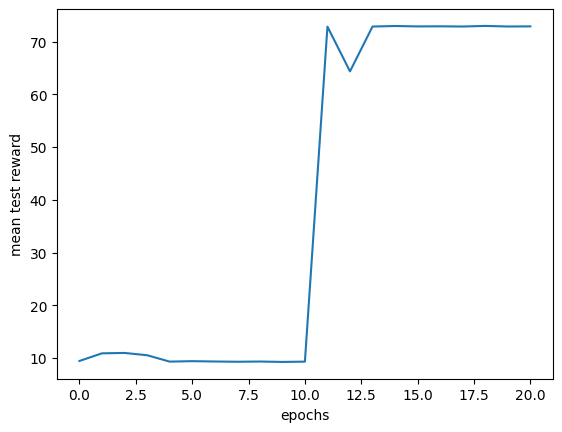

best_res_idx  1   200.0
[4, 3, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 13.0
0  success percent   0.0  mean reward  9.42
Best rewards so far: 24.0
1  success percent   0.0  mean reward  9.36
Best rewards so far: 19.0
2  success percent   0.0  mean reward  9.32
Best rewards so far: 23.0
Best rewards so far: 22.0
Best rewards so far: 32.0
Best rewards so far: 33.0
Best rewards so far: 59.0
Best rewards so far: 36.0
Best rewards so far: 68.0
Best rewards so far: 44.0
Best rewards so far: 49.0
Best rewards so far: 95.0
Best rewards so far: 67.0
Best rewards so far: 91.0
Best rewards so far: 109.0
0  success percent   0.0  mean reward  9.4
1  success percent   0.0  mean reward  9.48
2  success percent   0.0  mean reward  9.37
Best rewards so far: 113.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.5
Episode 1000 Epsilon 0.900200000000011
1  success percent   0.0  mean reward  23.96
Episode 1

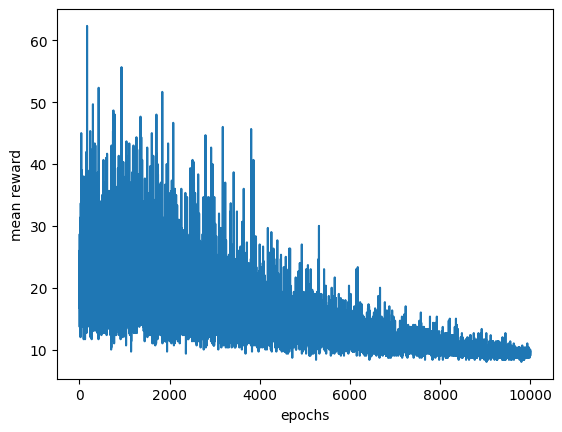

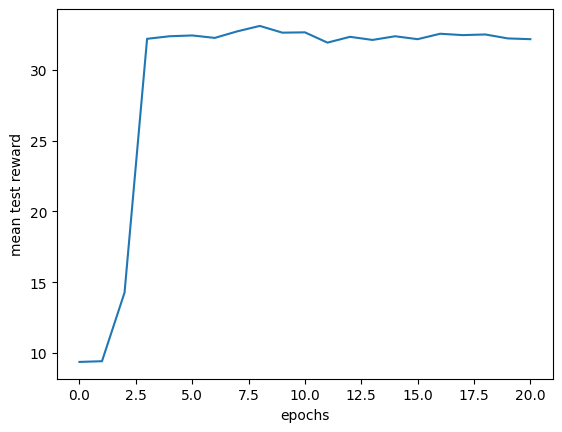

best_res_idx  0   63.69
TIME:  3.0189032395680746  min

HIDDEN SIZE:  4 3
Best rewards so far: 22.0
0  success percent   0.0  mean reward  60.52
Best rewards so far: 13.0
1  success percent   0.0  mean reward  58.66
Best rewards so far: 17.0
2  success percent   0.0  mean reward  58.82
Best rewards so far: 25.0
Best rewards so far: 27.0
Best rewards so far: 31.0
Best rewards so far: 56.0
Best rewards so far: 37.0
Best rewards so far: 53.0
Best rewards so far: 61.0
Best rewards so far: 63.0
Best rewards so far: 77.0
Best rewards so far: 85.0
Best rewards so far: 87.0
Best rewards so far: 81.0
Best rewards so far: 102.0
Best rewards so far: 97.0
Best rewards so far: 82.0
0  success percent   86.0  mean reward  199.32
1  success percent   52.0  mean reward  181.83
2  success percent   25.0  mean reward  174.37
Best rewards so far: 98.0
Best rewards so far: 87.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  44.77
Episode 1000 Epsilon 0.900300000000011
1  suc

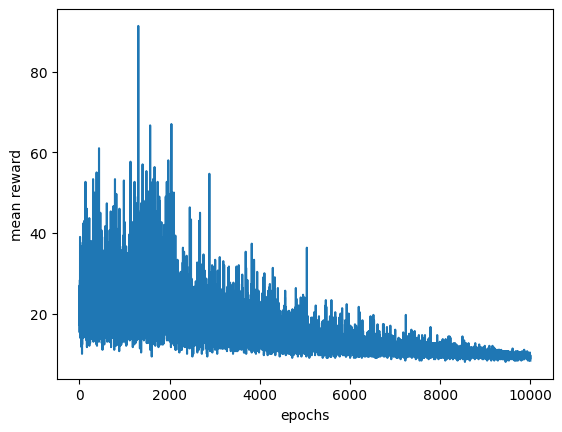

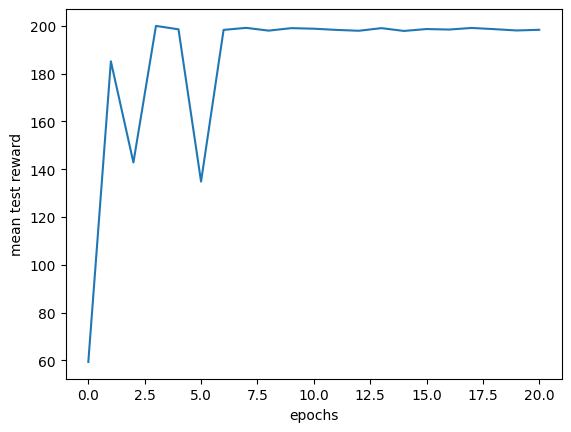

best_res_idx  1   200.0
[4, 4, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 27.0
0  success percent   0.0  mean reward  9.36
Best rewards so far: 20.0
1  success percent   0.0  mean reward  9.5
Best rewards so far: 23.0
2  success percent   0.0  mean reward  9.39
Best rewards so far: 42.0
Best rewards so far: 24.0
Best rewards so far: 61.0
Best rewards so far: 39.0
Best rewards so far: 44.0
Best rewards so far: 57.0
Best rewards so far: 70.0
Best rewards so far: 69.0
Best rewards so far: 68.0
Best rewards so far: 95.0
Best rewards so far: 77.0
Best rewards so far: 73.0
Best rewards so far: 88.0
Best rewards so far: 77.0
Best rewards so far: 133.0
0  success percent   0.0  mean reward  9.36
1  success percent   0.0  mean reward  9.27
2  success percent   0.0  mean reward  9.48
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.42
Episode 1000 Epsilon 0.900300000000011
1  success percent   0.0  me

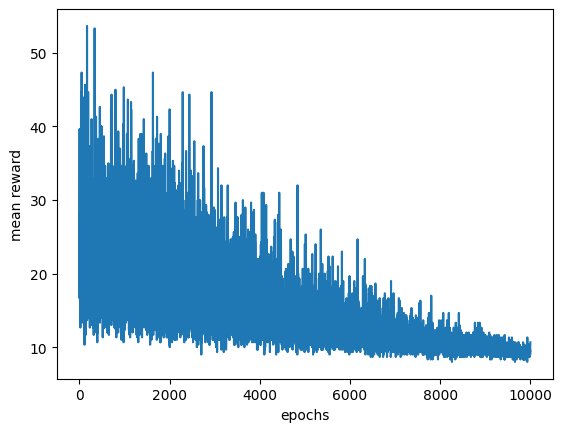

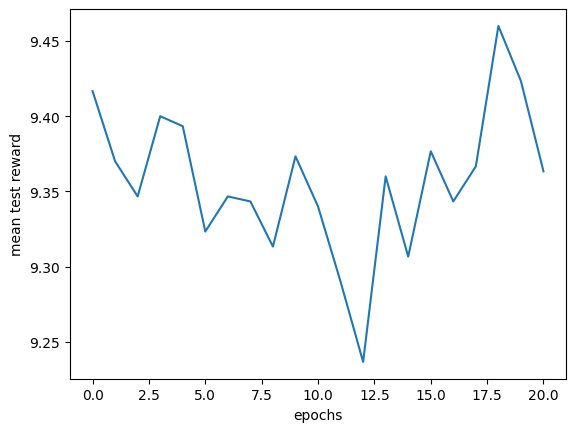

best_res_idx  2   9.47
TIME:  3.0250837087631224  min

HIDDEN SIZE:  4 3
Best rewards so far: 30.0
0  success percent   0.0  mean reward  9.22
Best rewards so far: 18.0
1  success percent   0.0  mean reward  9.42
Best rewards so far: 20.0
2  success percent   0.0  mean reward  9.28
Best rewards so far: 36.0
Best rewards so far: 31.0
Best rewards so far: 43.0
Best rewards so far: 54.0
Best rewards so far: 38.0
Best rewards so far: 46.0
Best rewards so far: 44.0
Best rewards so far: 55.0
Best rewards so far: 58.0
Best rewards so far: 90.0
Best rewards so far: 67.0
Best rewards so far: 48.0
Best rewards so far: 68.0
Best rewards so far: 50.0
Best rewards so far: 64.0
Best rewards so far: 92.0
Best rewards so far: 66.0
Best rewards so far: 78.0
0  success percent   0.0  mean reward  9.35
1  success percent   0.0  mean reward  9.25
2  success percent   0.0  mean reward  9.34
Best rewards so far: 97.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.44
Episode 

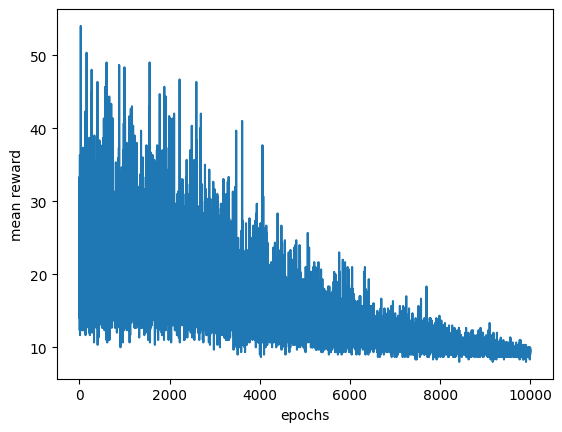

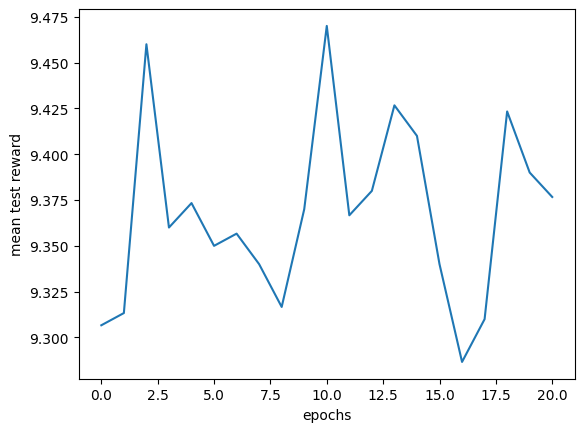

best_res_idx  0   9.47
TIME:  3.0440078139305116  min

HIDDEN SIZE:  4 4
Best rewards so far: 12.0
0  success percent   0.0  mean reward  9.44
Best rewards so far: 23.0
1  success percent   0.0  mean reward  9.3
Best rewards so far: 13.0
2  success percent   0.0  mean reward  9.3
Best rewards so far: 20.0
Best rewards so far: 32.0
Best rewards so far: 15.0
Best rewards so far: 41.0
Best rewards so far: 27.0
Best rewards so far: 51.0
Best rewards so far: 48.0
Best rewards so far: 54.0
Best rewards so far: 70.0
Best rewards so far: 43.0
Best rewards so far: 44.0
Best rewards so far: 57.0
Best rewards so far: 52.0
Best rewards so far: 56.0
Best rewards so far: 65.0
Best rewards so far: 97.0
Best rewards so far: 102.0
Best rewards so far: 71.0
Best rewards so far: 89.0
0  success percent   0.0  mean reward  9.29
1  success percent   0.0  mean reward  9.31
2  success percent   0.0  mean reward  9.24
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.39
Episode 1

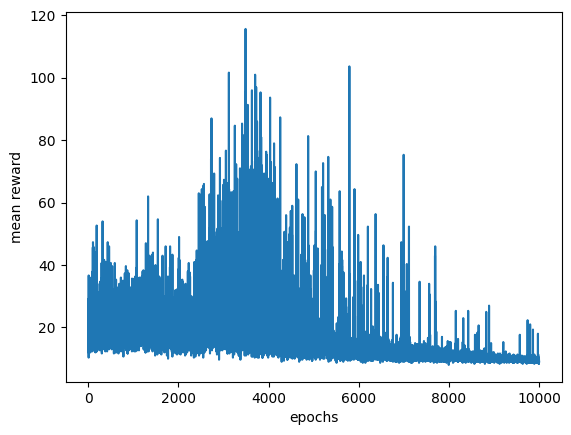

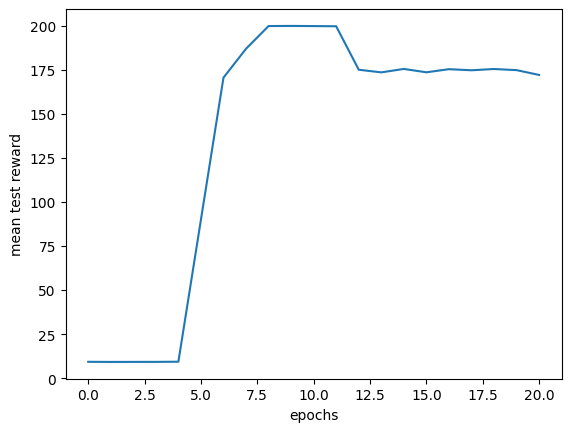

best_res_idx  0   200.0
[4, 4, 4, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 11.0
0  success percent   0.0  mean reward  9.42
Best rewards so far: 12.0
1  success percent   0.0  mean reward  9.41
Best rewards so far: 11.0
2  success percent   0.0  mean reward  9.39
Best rewards so far: 22.0
Best rewards so far: 29.0
Best rewards so far: 21.0
Best rewards so far: 27.0
Best rewards so far: 35.0
Best rewards so far: 30.0
Best rewards so far: 36.0
Best rewards so far: 32.0
Best rewards so far: 36.0
Best rewards so far: 45.0
Best rewards so far: 39.0
Best rewards so far: 50.0
Best rewards so far: 40.0
Best rewards so far: 63.0
Best rewards so far: 60.0
Best rewards so far: 112.0
Best rewards so far: 45.0
Best rewards so far: 47.0
Best rewards so far: 49.0
Best rewards so far: 66.0
Best rewards so far: 60.0
Best rewards so far: 118.0
Best rewards so far: 74.0
Best rewards so far: 114.0
0  success percent   0.0  mean reward  9.2
1 

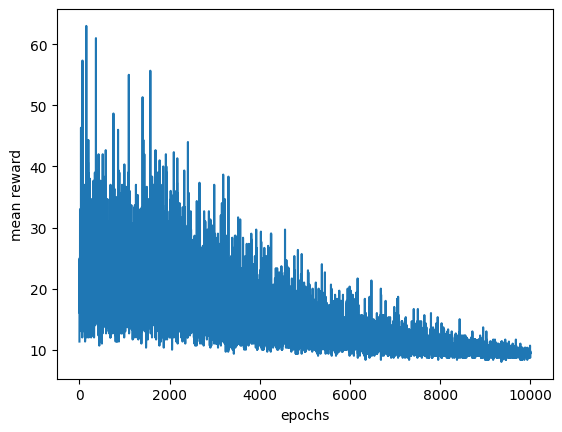

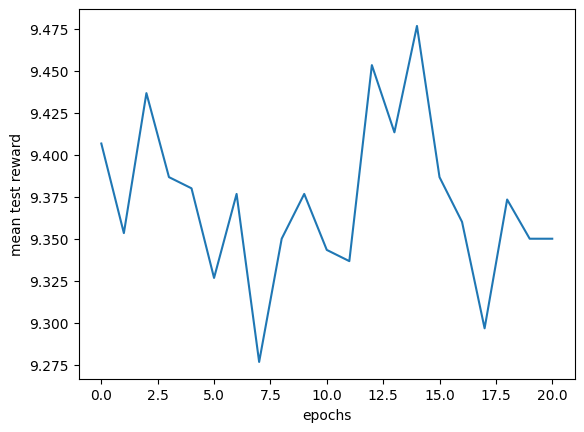

best_res_idx  0   9.4
TIME:  3.0944133520126345  min

HIDDEN SIZE:  4 3
Best rewards so far: 17.0
0  success percent   0.0  mean reward  9.34
Best rewards so far: 21.0
1  success percent   0.0  mean reward  9.25
Best rewards so far: 22.0
2  success percent   0.0  mean reward  9.38
Best rewards so far: 43.0
Best rewards so far: 28.0
Best rewards so far: 26.0
Best rewards so far: 42.0
Best rewards so far: 49.0
Best rewards so far: 28.0
Best rewards so far: 54.0
Best rewards so far: 29.0
Best rewards so far: 65.0
Best rewards so far: 49.0
Best rewards so far: 55.0
Best rewards so far: 71.0
Best rewards so far: 69.0
Best rewards so far: 104.0
Best rewards so far: 89.0
0  success percent   0.0  mean reward  9.32
1  success percent   0.0  mean reward  9.38
2  success percent   0.0  mean reward  9.25
Best rewards so far: 76.0
Best rewards so far: 77.0
Best rewards so far: 101.0
Best rewards so far: 96.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.49
Episode

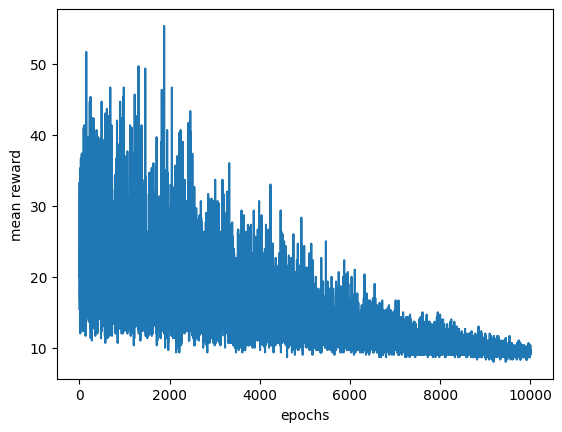

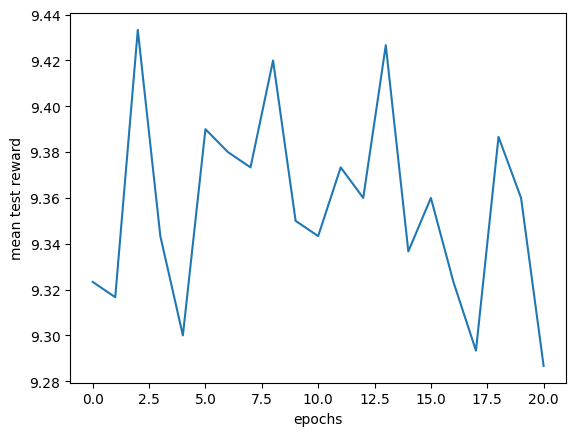

best_res_idx  0   9.34
TIME:  3.1163926045099895  min

HIDDEN SIZE:  4 4
Best rewards so far: 27.0
0  success percent   0.0  mean reward  9.39
Best rewards so far: 22.0
1  success percent   0.0  mean reward  9.4
Best rewards so far: 28.0
2  success percent   0.0  mean reward  9.38
Best rewards so far: 24.0
Best rewards so far: 36.0
Best rewards so far: 33.0
Best rewards so far: 39.0
Best rewards so far: 32.0
Best rewards so far: 65.0
Best rewards so far: 43.0
Best rewards so far: 75.0
Best rewards so far: 46.0
Best rewards so far: 82.0
Best rewards so far: 69.0
Best rewards so far: 96.0
Best rewards so far: 77.0
0  success percent   0.0  mean reward  9.22
1  success percent   0.0  mean reward  9.43
2  success percent   0.0  mean reward  9.36
Best rewards so far: 85.0
Best rewards so far: 83.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.45
Episode 1000 Epsilon 0.900300000000011
1  success percent   0.0  mean reward  9.38
Episode 1000 Epsilon 0.9002000

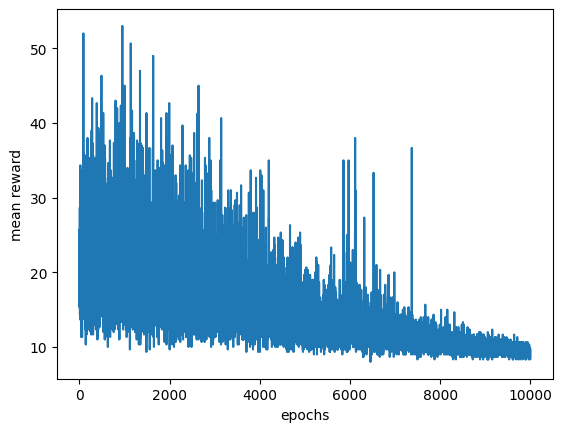

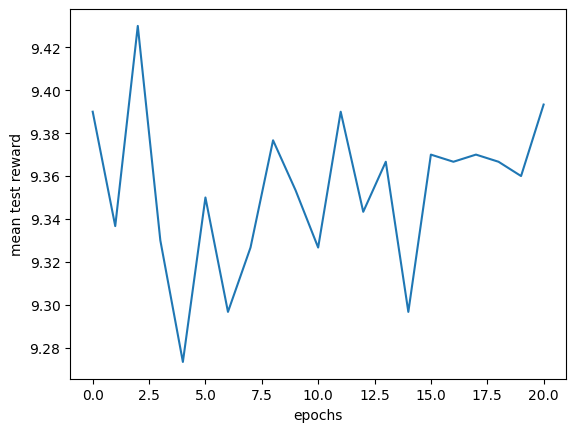

best_res_idx  0   9.37
TIME:  1.7244877815246582  min

HIDDEN SIZE:  5 4
Best rewards so far: 49.0
0  success percent   0.0  mean reward  9.42
Best rewards so far: 14.0
1  success percent   0.0  mean reward  9.16
Best rewards so far: 34.0
2  success percent   0.0  mean reward  9.31
Best rewards so far: 26.0
Best rewards so far: 49.0
Best rewards so far: 63.0
Best rewards so far: 47.0
Best rewards so far: 88.0
Best rewards so far: 84.0
Best rewards so far: 104.0
Best rewards so far: 72.0
0  success percent   0.0  mean reward  9.38
1  success percent   0.0  mean reward  9.34
2  success percent   0.0  mean reward  9.31
Best rewards so far: 75.0
Best rewards so far: 87.0
Best rewards so far: 76.0
Best rewards so far: 92.0
Best rewards so far: 87.0
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  9.36
Episode 1000 Epsilon 0.900300000000011
1  success percent   0.0  mean reward  9.52
Episode 1000 Epsilon 0.900200000000011
2  success percent   0.0  mean reward  9.

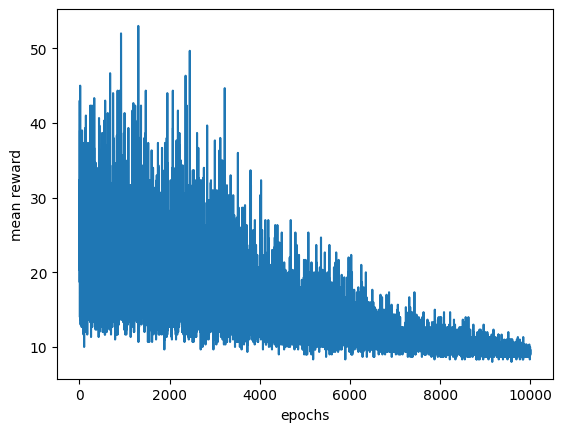

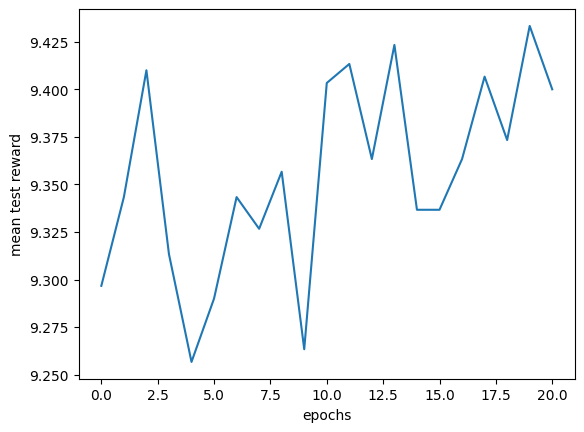

best_res_idx  0   9.43
TIME:  1.5232247630755107  min

HIDDEN SIZE:  5 5
Best rewards so far: 10.0
0  success percent   0.0  mean reward  9.25
Best rewards so far: 23.0
1  success percent   0.0  mean reward  9.39
Best rewards so far: 34.0
2  success percent   0.0  mean reward  9.28
Best rewards so far: 17.0
Best rewards so far: 86.0
Best rewards so far: 37.0
Best rewards so far: 40.0
Best rewards so far: 29.0
Best rewards so far: 60.0
Best rewards so far: 30.0
Best rewards so far: 37.0
Best rewards so far: 64.0
Best rewards so far: 60.0
Best rewards so far: 81.0
Best rewards so far: 95.0
Best rewards so far: 71.0
Best rewards so far: 83.0
Best rewards so far: 77.0
Best rewards so far: 107.0
0  success percent   0.0  mean reward  9.23
1  success percent   0.0  mean reward  9.36
2  success percent   0.0  mean reward  9.41
Best rewards so far: 86.0
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.43
Episode 1000 Epsilon 0.900300000000011
1  success percent  

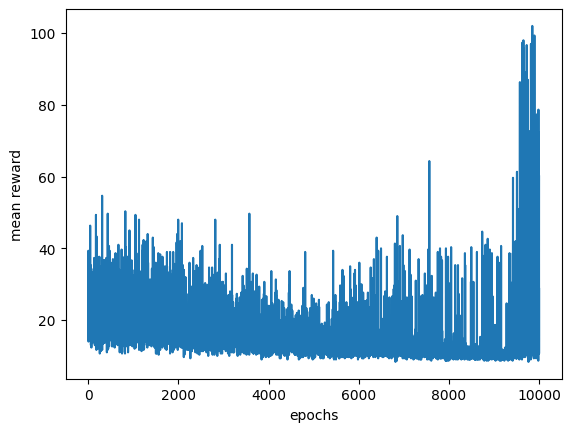

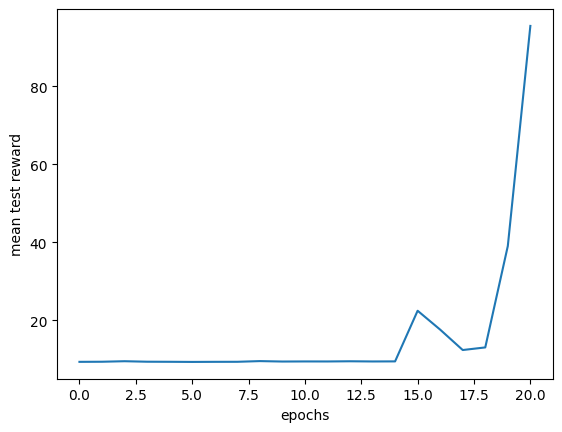

best_res_idx  2   103.81
TIME:  1.9792750398317973  min

HIDDEN SIZE:  6 5
Best rewards so far: 27.0
0  success percent   0.0  mean reward  90.38
Best rewards so far: 17.0
1  success percent   0.0  mean reward  89.94
Best rewards so far: 17.0
2  success percent   0.0  mean reward  89.91
Best rewards so far: 32.0
Best rewards so far: 28.0
Best rewards so far: 36.0
Best rewards so far: 33.0
Best rewards so far: 46.0
Best rewards so far: 35.0
Best rewards so far: 49.0
Best rewards so far: 52.0
Best rewards so far: 38.0
Best rewards so far: 50.0
Best rewards so far: 54.0
Best rewards so far: 54.0
Best rewards so far: 66.0
Best rewards so far: 62.0
Best rewards so far: 65.0
Best rewards so far: 103.0
Best rewards so far: 64.0
Best rewards so far: 65.0
Best rewards so far: 80.0
Best rewards so far: 106.0
Best rewards so far: 73.0
Best rewards so far: 114.0
0  success percent   0.0  mean reward  30.8
1  success percent   0.0  mean reward  9.33
2  success percent   0.0  mean reward  11.43
Best

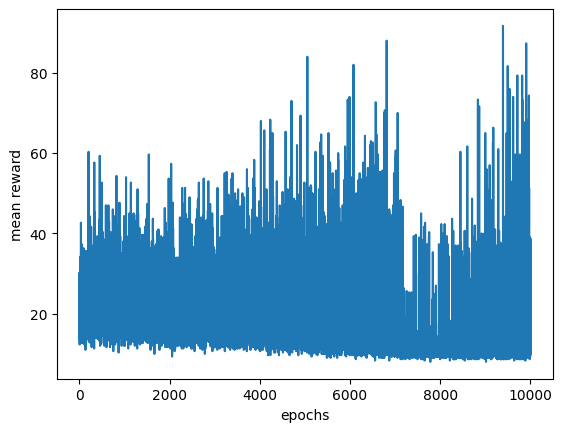

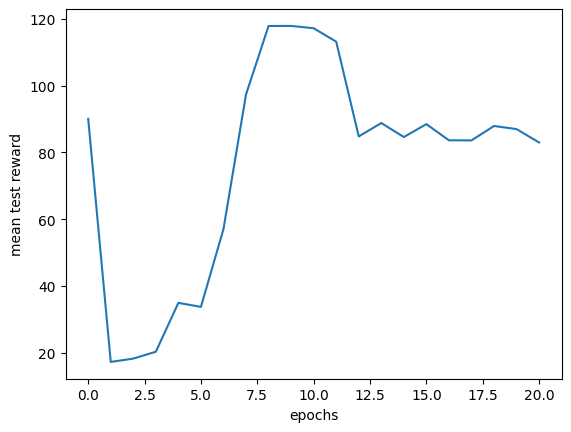

best_res_idx  1   124.2
TIME:  1.9216848611831665  min

HIDDEN SIZE:  6 6
Best rewards so far: 31.0
0  success percent   3.0  mean reward  101.94
Best rewards so far: 18.0
1  success percent   2.0  mean reward  103.74
Best rewards so far: 32.0
2  success percent   7.0  mean reward  105.32
Best rewards so far: 36.0
Best rewards so far: 27.0
Best rewards so far: 37.0
Best rewards so far: 34.0
Best rewards so far: 47.0
Best rewards so far: 37.0
Best rewards so far: 39.0
Best rewards so far: 45.0
Best rewards so far: 55.0
Best rewards so far: 66.0
Best rewards so far: 92.0
Best rewards so far: 56.0
Best rewards so far: 62.0
Best rewards so far: 138.0
Best rewards so far: 85.0
Best rewards so far: 66.0
Best rewards so far: 75.0
Best rewards so far: 102.0
0  success percent   0.0  mean reward  55.39
1  success percent   0.0  mean reward  9.29
2  success percent   0.0  mean reward  35.8
Best rewards so far: 78.0
Best rewards so far: 90.0
Best rewards so far: 100.0
Episode 1000 Epsilon 0.90010

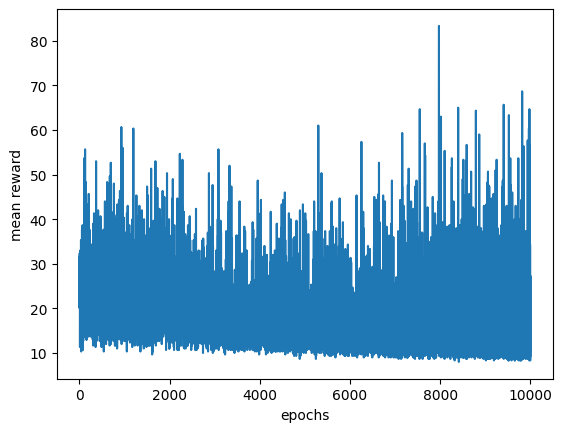

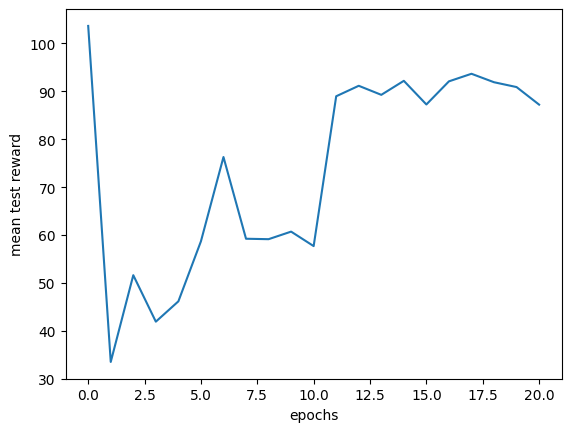

best_res_idx  2   117.73
TIME:  1.6901979923248291  min

HIDDEN SIZE:  7 6
Best rewards so far: 26.0
0  success percent   0.0  mean reward  108.58
Best rewards so far: 19.0
1  success percent   0.0  mean reward  108.25
Best rewards so far: 19.0
2  success percent   0.0  mean reward  108.9
Best rewards so far: 45.0
Best rewards so far: 22.0
Best rewards so far: 31.0
Best rewards so far: 27.0
Best rewards so far: 68.0
Best rewards so far: 61.0
Best rewards so far: 48.0
Best rewards so far: 90.0
Best rewards so far: 70.0
Best rewards so far: 98.0
Best rewards so far: 102.0
Best rewards so far: 80.0
Best rewards so far: 87.0
0  success percent   0.0  mean reward  9.36
1  success percent   0.0  mean reward  9.45
2  success percent   0.0  mean reward  9.26
Best rewards so far: 123.0
Best rewards so far: 105.0
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  92.14
Episode 1000 Epsilon 0.900300000000011
1  success percent   0.0  mean reward  9.33
Episode 1000 Epsil

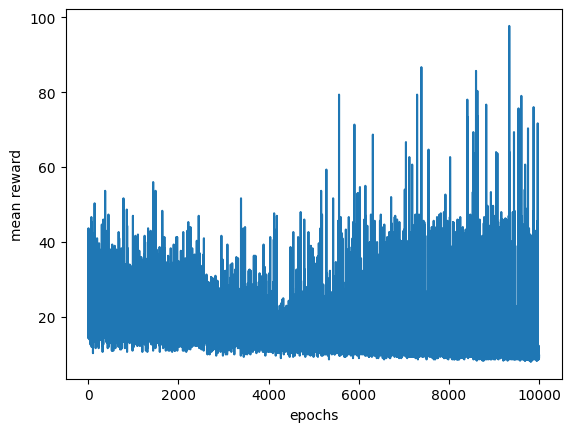

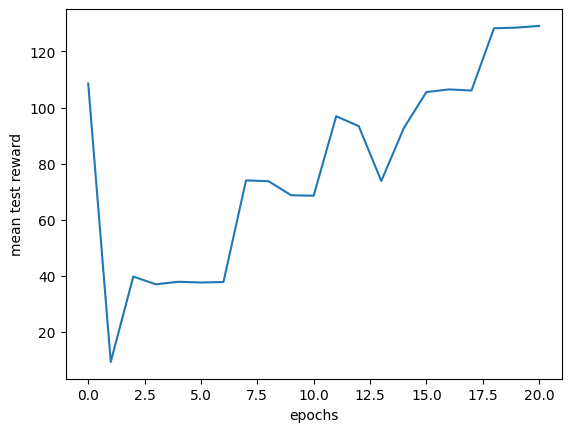

best_res_idx  0   198.38
[4, 7, 6, 2] Good found---------------------------------------------------
TOTAL TIME:  55.80378445784251  min


In [15]:
learning_rate_a = 0.1
game_name = "CartPole-v0"
env = gym.make(game_name)
in_states = env.observation_space.shape[0]
out_actions = env.action_space.n
env.close()
a_types = [ '', 'ReLU', 'ReLU', 'Linear']

num_of_nn = 3

        
episodes = 10000

total_time_start = time.time()
n_tests = 5
TSR = 95

for test in range(n_tests):

    best_SR = 0
    
    loop_cnt = 8
    
    tmp_idx = 0
    t1 = 3
    t2 = 3
    
    optimizer_ = 'Adam'
    for y in range(loop_cnt):
        
        this_time_start = time.time()
        
        print('\nHIDDEN SIZE: ', t1, t2)
        
        h1_nodes = t1
        h2_nodes = t2
        
        dqn_s = []
        
        ct = datetime.datetime.now()
        ct = str(ct)
        ct = ct.replace(":", "-")
        ct = ct.replace(" ", "_")
        ct = ct[:-7]
        ct = roll + '/' + ct + '_' + str(t1)+'_'+str(t2)
        
        # preset models
        for i in range(num_of_nn):
            policy_dqn = plastic_nn(optimizer=optimizer_)
            
    
            topology = [in_states, h1_nodes, h2_nodes,  out_actions]
            dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 1)
            dqn_test.set_tag(str(i))
            dqn_test.save_info(f'lr: {learning_rate_a} \n{topology} \na:{a_types}\n')
            
            dqn_s.append(dqn_test)
            
            if (y == 0):
                layers_net = [input_layer(in_states), 
                layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_types[1]), 
                layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_types[2]), 
                layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_types[3])]
                
                policy_dqn.append_layers(layers_net)
            else:
                policy_dqn = next_load_policy
            policy_dqn.optimizer_reset()
            dqn_s[i].init_train_data(policy_dqn, episodes)
        
        # for i in range(num_of_nn):
        #     dqn_s[i].policy_dqn.print_info()    
        
        summs = np.zeros(shape = episodes+1)
        tests = np.zeros(shape = int(episodes/500) + 1)
        
        
        for e in range(episodes + 1):
            for i in range (num_of_nn):  
                summs[e] += dqn_s[i].run_one_epoch(e)
                if (e % 500 == 0):
                    test_dqn_ = plastic_nn(optimizer=optimizer_)
                    test_dqn_.load(f'{dqn_s[i].path}/mc_policy_best')
                    succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn_, episodes = 100)
                    print(i,' success percent  ', succ_perc, ' mean reward ', mean_reward)
                    tests[int(e/500)] += mean_reward
    
        # for i in range(num_of_nn):
        #     dqn_s[i].policy_dqn.print_info()

        # TESTING
        best_test_result = -1
        best_res_idx = -1
        
        for i in range (num_of_nn):
            test_dqn = plastic_nn(optimizer=optimizer_)
            test_dqn.load(f'{dqn_s[i].path}/mc_policy_best')
            succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn, episodes = 100)
            if (mean_reward > best_test_result):
                best_test_result = mean_reward
                best_res_idx = i
    
                if (succ_perc > best_SR):
                    best_SR = succ_perc
                
            print('final: success percent  ', succ_perc, ' mean reward ', mean_reward)
            dqn_s[i].post_train()
        
       
    
        mean_results = np.asarray(summs) / num_of_nn
        show_plot('epochs', 'mean reward', mean_results, f'{dqn_s[0].ct}/mean_values.png')
    
        mean_test_reward = np.asarray(tests) / num_of_nn
        show_plot('epochs', 'mean test reward', mean_test_reward, f'{dqn_s[0].ct}/mean_test_reward.png')
           
        print('best_res_idx ', best_res_idx, ' ', best_test_result)
        
        if (best_SR > TSR):
            print(topology, 'Good found---------------------------------------------------')
            break
            
        
    
        next_load_policy = plastic_nn(optimizer=optimizer_)
        next_load_policy.load(f'{dqn_s[best_res_idx].path}/mc_policy_best')
    
        next_load_policy.add_neuron(layer_number = (y%2)+1, n_of_neurons = 1, value = 'r')
        #next_load_policy.add_neuron(layer_number = 1, n_of_neurons = 2, value = 'r')
        #next_load_policy.add_neuron(layer_number = 2, n_of_neurons = 2, value = 'r')
        
        if (y%2 == 0):
            t1 += 1
        else:
            t2 += 1
            
        this_time_end = time.time()
        this_time_diff = this_time_end - this_time_start
        print('TIME: ', this_time_diff/60, ' min')
        
    
    
total_time_end = time.time()
total_time_diff = total_time_end - total_time_start
print('TOTAL TIME: ', total_time_diff/60, ' min')

In [24]:
random.random()

0.20806811705455408


HIDDEN SIZE:  3 3
Best rewards so far: 26.0
0  success percent   0.0  mean reward  9.25
Best rewards so far: 35.0
Best rewards so far: 45.0
Best rewards so far: 90.0
Best rewards so far: 107.0
0  success percent   0.0  mean reward  9.23
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.35
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.44
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.35
Episode 4000 Epsilon 0.600400000000044
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.46
Episode 5000 Epsilon 0.500400000000055
0  success percent   0.0  mean reward  9.53
0  success percent   0.0  mean reward  9.25
Episode 6000 Epsilon 0.40040000000006604
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.3

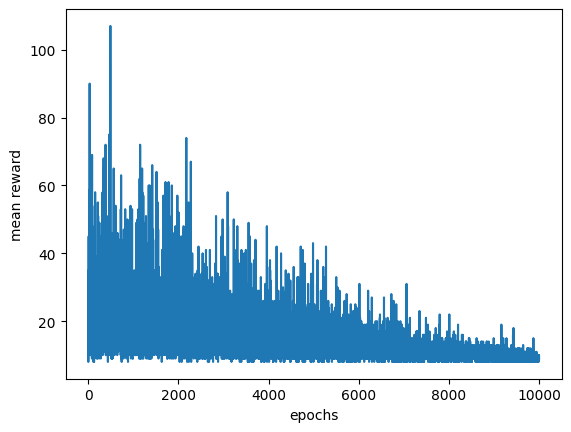

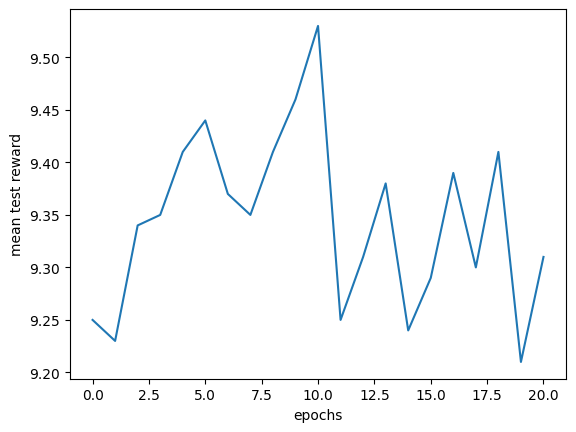

best_res_idx  0   9.32
TIME:  0.9974941452344258  min

HIDDEN SIZE:  4 3
Best rewards so far: 11.0
0  success percent   0.0  mean reward  9.34
Best rewards so far: 40.0
Best rewards so far: 43.0
Best rewards so far: 55.0
Best rewards so far: 60.0
Best rewards so far: 67.0
Best rewards so far: 68.0
Best rewards so far: 70.0
0  success percent   0.0  mean reward  9.43
Best rewards so far: 79.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.33
Best rewards so far: 87.0
0  success percent   0.0  mean reward  9.22
Best rewards so far: 111.0
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.23
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.44
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.41
Episode 5000 Epsilon 0.500200000000055
0  succ

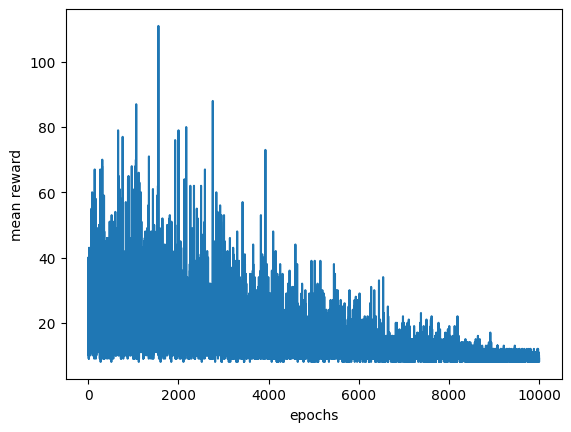

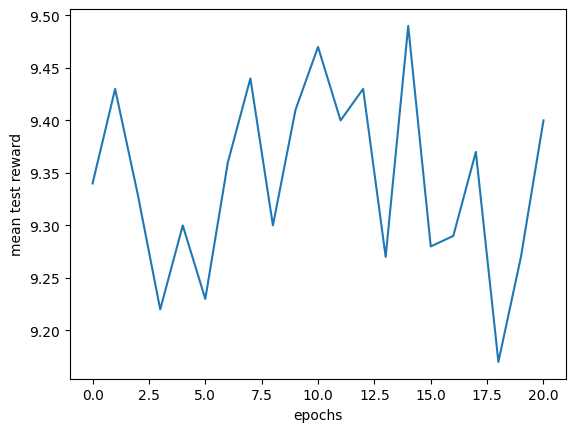

best_res_idx  0   9.43
TIME:  0.9869979540506999  min

HIDDEN SIZE:  4 4
Best rewards so far: 12.0
0  success percent   0.0  mean reward  9.41
Best rewards so far: 14.0
Best rewards so far: 22.0
Best rewards so far: 29.0
Best rewards so far: 41.0
Best rewards so far: 44.0
Best rewards so far: 46.0
Best rewards so far: 59.0
Best rewards so far: 66.0
Best rewards so far: 90.0
0  success percent   0.0  mean reward  9.37
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.26
Best rewards so far: 100.0
0  success percent   0.0  mean reward  9.41
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.23
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.45
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.34
Episode 5000 Epsilon 0.500300000000055
0  suc

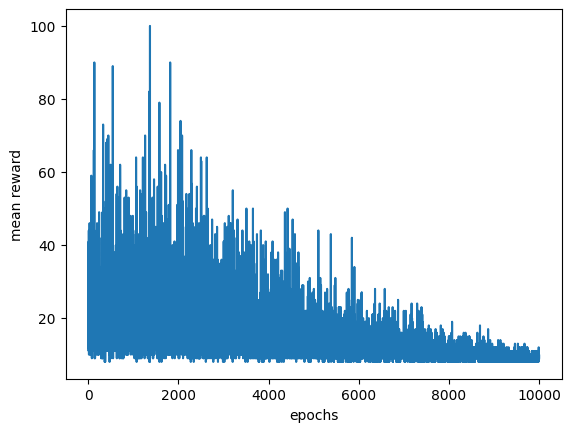

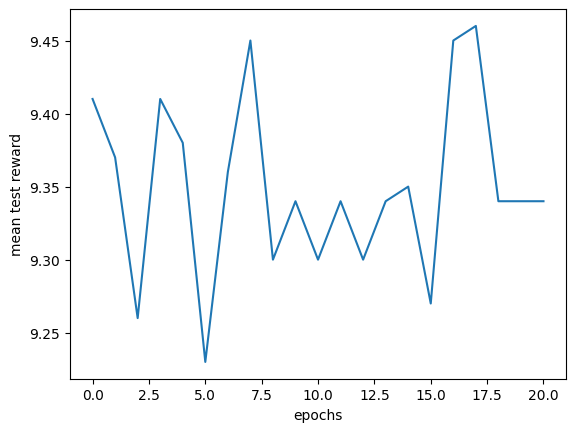

best_res_idx  0   9.42
TIME:  0.9891541322072347  min

HIDDEN SIZE:  5 4
Best rewards so far: 31.0
0  success percent   0.0  mean reward  9.26
Best rewards so far: 44.0
Best rewards so far: 46.0
Best rewards so far: 49.0
Best rewards so far: 59.0
Best rewards so far: 73.0
Best rewards so far: 90.0
0  success percent   0.0  mean reward  9.39
Best rewards so far: 94.0
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.5
Episode 2000 Epsilon 0.800100000000022
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.28
Episode 3000 Epsilon 0.700100000000033
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.45
Best rewards so far: 99.0
Episode 4000 Epsilon 0.600100000000044
0  success percent   100.0  mean reward  200.0
0  success percent   100.0  mean reward  200.0
Episode 5000 Epsilon 0.5001000000000551
0  success percent   100.0  mean reward  200.0
0  su

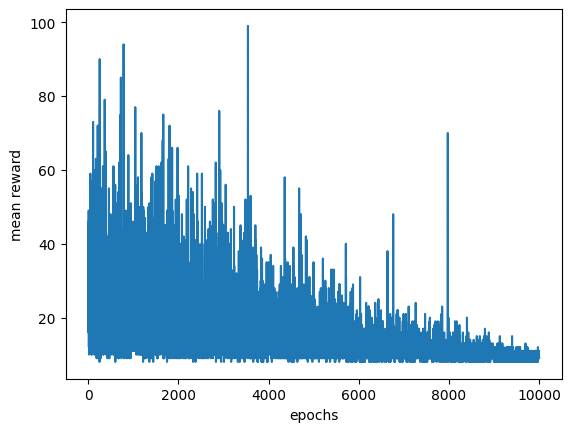

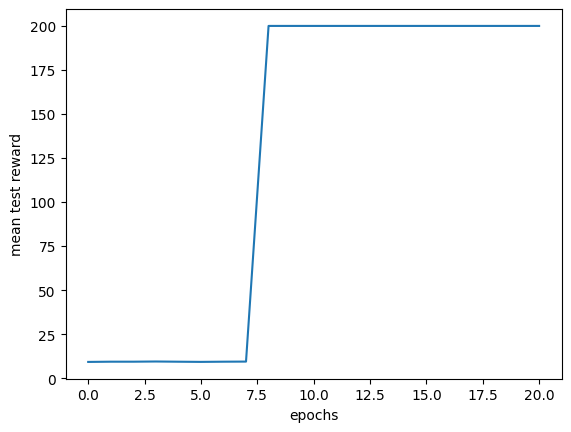

best_res_idx  0   200.0
[4, 5, 4, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 19.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 44.0
Best rewards so far: 52.0
Best rewards so far: 79.0
Best rewards so far: 98.0
0  success percent   0.0  mean reward  9.24
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.45
0  success percent   0.0  mean reward  9.32
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.25
0  success percent   0.0  mean reward  9.46
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.37
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.45
0  success percent   0.0  mean reward  9.35
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.36
Episode 6000 Epsilon 0.400200

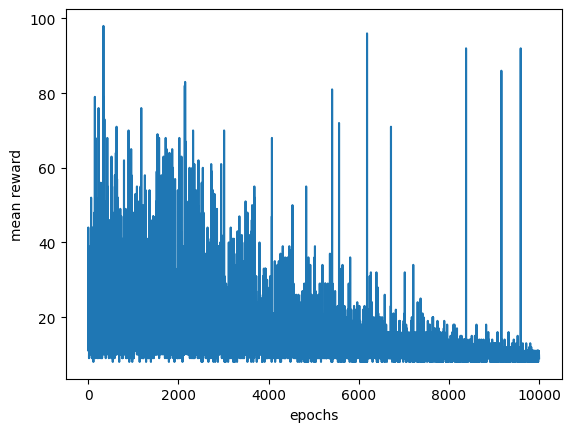

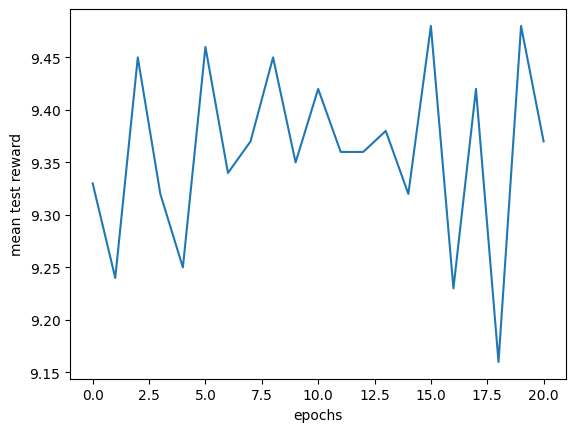

best_res_idx  0   9.38
TIME:  0.969643481572469  min

HIDDEN SIZE:  4 3
Best rewards so far: 15.0
0  success percent   0.0  mean reward  9.32
Best rewards so far: 32.0
Best rewards so far: 34.0
Best rewards so far: 49.0
Best rewards so far: 51.0
Best rewards so far: 56.0
Best rewards so far: 69.0
Best rewards so far: 100.0
Best rewards so far: 113.0
0  success percent   0.0  mean reward  9.32
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.34
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.43
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.34
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.41
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.45
0  success per

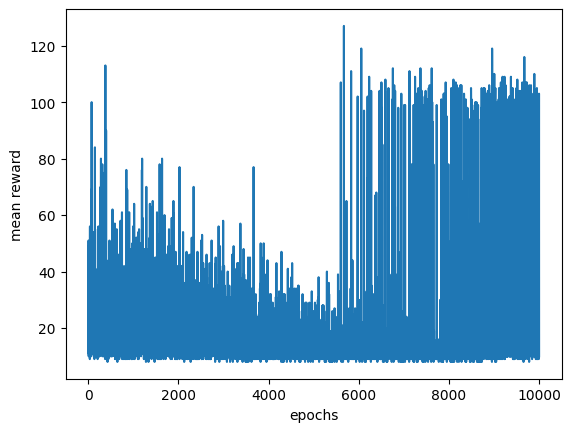

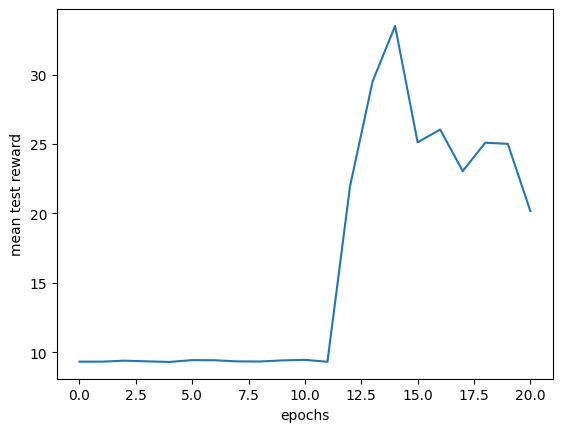

best_res_idx  0   26.68
TIME:  1.0072920401891072  min

HIDDEN SIZE:  4 4
Best rewards so far: 32.0
0  success percent   0.0  mean reward  25.26
Best rewards so far: 35.0
Best rewards so far: 40.0
Best rewards so far: 52.0
Best rewards so far: 69.0
Best rewards so far: 86.0
Best rewards so far: 130.0
0  success percent   0.0  mean reward  9.19
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.36
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.43
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.27
0  success percent   0.0  mean reward  9.45
Best rewards so far: 139.0
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  80.18
0  success percent   0.0  mean reward  78.48
Best rewards so far: 145.0
Best rewards so far: 158.0
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0 

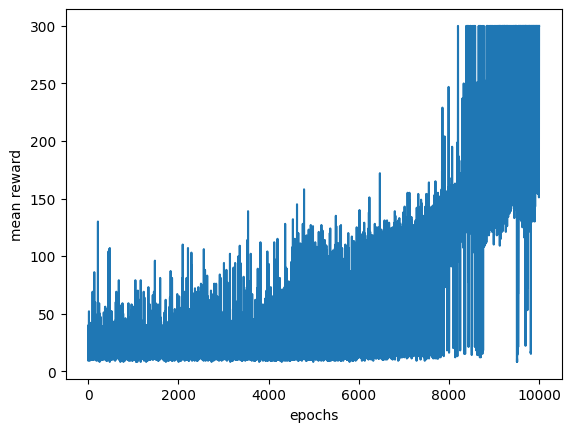

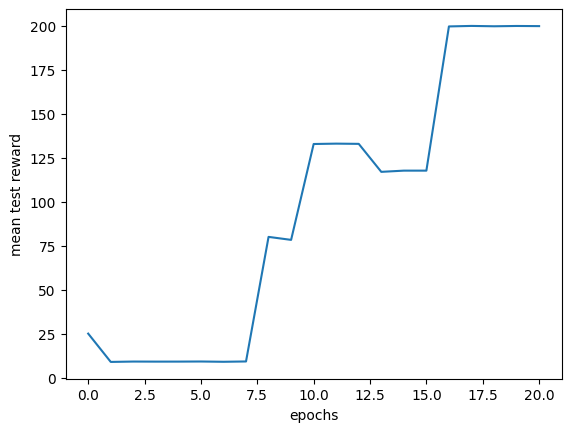

best_res_idx  0   199.82
[4, 4, 4, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 10.0
0  success percent   0.0  mean reward  9.43
Best rewards so far: 20.0
Best rewards so far: 23.0
Best rewards so far: 69.0
Best rewards so far: 90.0
0  success percent   0.0  mean reward  9.48
Best rewards so far: 105.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.39
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.33
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.27
0  success percent   0.0  mean reward  9.4
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.48
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.53
0  success percent   0.0  mean reward  9.4
Epi

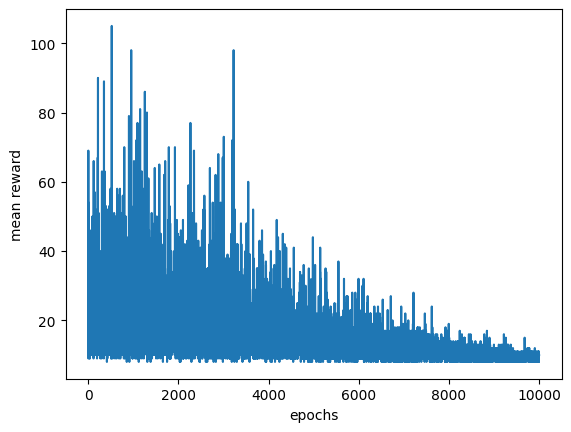

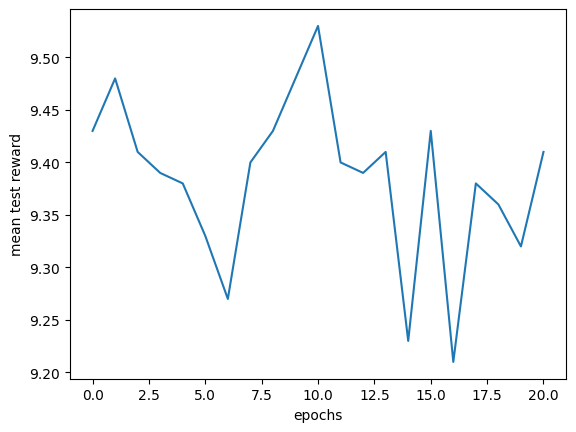

best_res_idx  0   9.42
TIME:  0.9907511035601299  min

HIDDEN SIZE:  4 3
Best rewards so far: 36.0
0  success percent   0.0  mean reward  9.32
Best rewards so far: 47.0
Best rewards so far: 89.0
0  success percent   0.0  mean reward  9.29
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.34
Episode 2000 Epsilon 0.800100000000022
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.37
Best rewards so far: 106.0
Best rewards so far: 128.0
Episode 3000 Epsilon 0.700100000000033
0  success percent   100.0  mean reward  200.0
Best rewards so far: 184.0
0  success percent   31.0  mean reward  71.97
Episode 4000 Epsilon 0.600100000000044
0  success percent   32.0  mean reward  74.01
Best rewards so far: 217.0
0  success percent   100.0  mean reward  200.0
Best rewards so far: 249.0
Best rewards so far: 300.0
Episode 5000 Epsilon 0.5001000000000551
0  success percent   100.0  mean reward  2

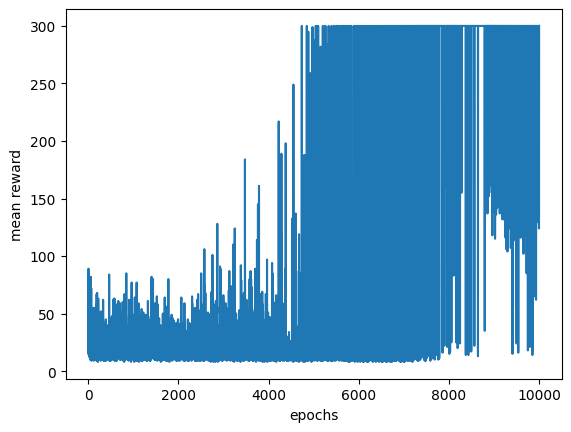

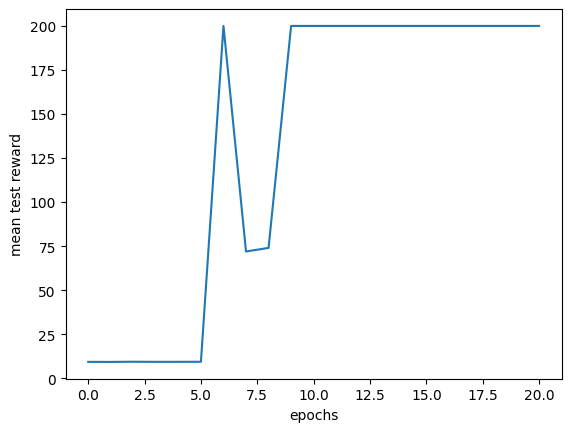

best_res_idx  0   200.0
[4, 4, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 42.0
0  success percent   0.0  mean reward  9.31
Best rewards so far: 52.0
Best rewards so far: 61.0
Best rewards so far: 66.0
Best rewards so far: 71.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 81.0
Best rewards so far: 82.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.41
Best rewards so far: 83.0
0  success percent   0.0  mean reward  9.3
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.39
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.46
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.19
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9

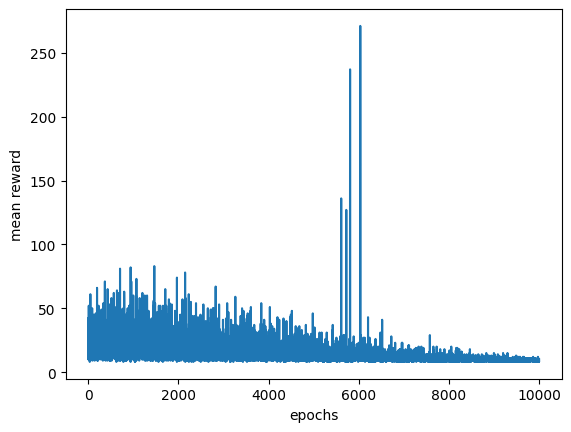

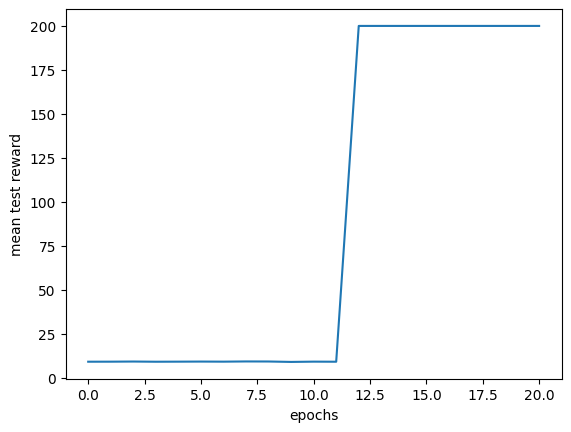

best_res_idx  0   200.0
[4, 3, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 21.0
0  success percent   100.0  mean reward  200.0
Best rewards so far: 25.0
Best rewards so far: 58.0
Best rewards so far: 89.0
0  success percent   0.0  mean reward  13.6
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  14.12
Best rewards so far: 96.0
Best rewards so far: 112.0
0  success percent   0.0  mean reward  9.36
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.45
Best rewards so far: 123.0
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.49
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.27
Best rewards so far: 161.0
Best rewards so far: 250.0
0  success percent   100.0  mean reward  200.0
Best rewards so far: 283.0
Episode 5000 E

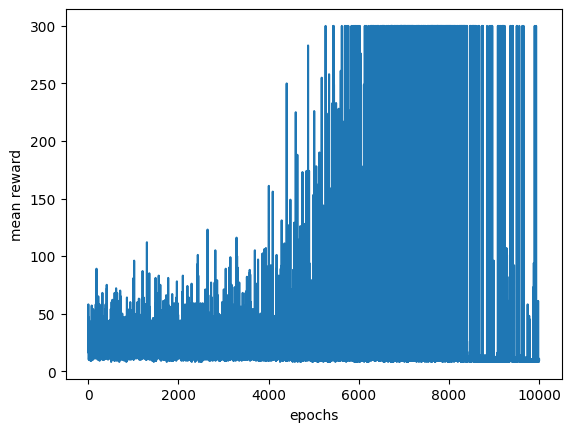

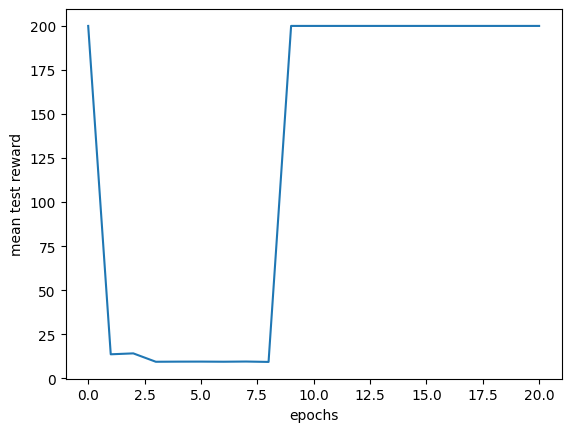

best_res_idx  0   200.0
[4, 3, 3, 2] Good found---------------------------------------------------
TOTAL TIME:  13.048234224319458  min


In [16]:
roll = '112'
learning_rate_a = 0.1
game_name = "CartPole-v0"
env = gym.make(game_name)
in_states = env.observation_space.shape[0]
out_actions = env.action_space.n
env.close()
a_types = [ '', 'ReLU', 'ReLU', 'Linear']

num_of_nn = 1

        
episodes = 10000

total_time_start = time.time()
n_tests = 5
TSR = 95

for test in range(n_tests):

    best_SR = 0
    
    loop_cnt = 8
    
    tmp_idx = 0
    t1 = 3
    t2 = 3
    
    optimizer_ = 'Adam'
    for y in range(loop_cnt):
        
        this_time_start = time.time()
        
        print('\nHIDDEN SIZE: ', t1, t2)
        
        h1_nodes = t1
        h2_nodes = t2
        
        dqn_s = []
        
        ct = datetime.datetime.now()
        ct = str(ct)
        ct = ct.replace(":", "-")
        ct = ct.replace(" ", "_")
        ct = ct[:-7]
        ct = roll + '/' + ct + '_' + str(t1)+'_'+str(t2)
        
        # preset models
        for i in range(num_of_nn):
            policy_dqn = plastic_nn(optimizer=optimizer_)
            
    
            topology = [in_states, h1_nodes, h2_nodes,  out_actions]
            dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 1)
            dqn_test.set_tag(str(i))
            dqn_test.save_info(f'lr: {learning_rate_a} \n{topology} \na:{a_types}\n')
            
            dqn_s.append(dqn_test)
            
            if (y == 0):
                layers_net = [input_layer(in_states), 
                layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_types[1]), 
                layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_types[2]), 
                layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_types[3])]
                
                policy_dqn.append_layers(layers_net)
            else:
                policy_dqn = next_load_policy
            policy_dqn.optimizer_reset()
            dqn_s[i].init_train_data(policy_dqn, episodes)
        
        # for i in range(num_of_nn):
        #     dqn_s[i].policy_dqn.print_info()    
        
        summs = np.zeros(shape = episodes+1)
        tests = np.zeros(shape = int(episodes/500) + 1)
        
        
        for e in range(episodes + 1):
            for i in range (num_of_nn):  
                summs[e] += dqn_s[i].run_one_epoch(e)
                if (e % 500 == 0):
                    test_dqn_ = plastic_nn(optimizer=optimizer_)
                    test_dqn_.load(f'{dqn_s[i].path}/mc_policy_best')
                    succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn_, episodes = 100)
                    print(i,' success percent  ', succ_perc, ' mean reward ', mean_reward)
                    tests[int(e/500)] += mean_reward
    
        # for i in range(num_of_nn):
        #     dqn_s[i].policy_dqn.print_info()

        # TESTING
        best_test_result = -1
        best_res_idx = -1
        
        for i in range (num_of_nn):
            test_dqn = plastic_nn(optimizer=optimizer_)
            test_dqn.load(f'{dqn_s[i].path}/mc_policy_best')
            succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn, episodes = 100)
            if (mean_reward > best_test_result):
                best_test_result = mean_reward
                best_res_idx = i
    
                if (succ_perc > best_SR):
                    best_SR = succ_perc
                
            print('final: success percent  ', succ_perc, ' mean reward ', mean_reward)
            dqn_s[i].post_train()
        
       
    
        mean_results = np.asarray(summs) / num_of_nn
        show_plot('epochs', 'mean reward', mean_results, f'{dqn_s[0].ct}/mean_values.png')
    
        mean_test_reward = np.asarray(tests) / num_of_nn
        show_plot('epochs', 'mean test reward', mean_test_reward, f'{dqn_s[0].ct}/mean_test_reward.png')
           
        print('best_res_idx ', best_res_idx, ' ', best_test_result)
        
        if (best_SR > TSR):
            print(topology, 'Good found---------------------------------------------------')
            break
            
        
    
        next_load_policy = plastic_nn(optimizer=optimizer_)
        next_load_policy.load(f'{dqn_s[best_res_idx].path}/mc_policy_best')
    
        next_load_policy.add_neuron(layer_number = (y%2)+1, n_of_neurons = 1, value = 'r')
        #next_load_policy.add_neuron(layer_number = 1, n_of_neurons = 2, value = 'r')
        #next_load_policy.add_neuron(layer_number = 2, n_of_neurons = 2, value = 'r')
        
        if (y%2 == 0):
            t1 += 1
        else:
            t2 += 1
            
        this_time_end = time.time()
        this_time_diff = this_time_end - this_time_start
        print('TIME: ', this_time_diff/60, ' min')
        
    
    
total_time_end = time.time()
total_time_diff = total_time_end - total_time_start
print('TOTAL TIME: ', total_time_diff/60, ' min')


HIDDEN SIZE:  3 3
Best rewards so far: 44.0
0  success percent   0.0  mean reward  9.26
Best rewards so far: 52.0
Best rewards so far: 72.0
Best rewards so far: 94.0
Best rewards so far: 98.0
0  success percent   0.0  mean reward  9.43
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.38
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.47
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.4
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.24
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.23
Episode 6000 Epsilon 0.40020000000006606
0  success percent   0.0  mean reward  9.22
0  success percent   0.0  mean reward  9.36
E

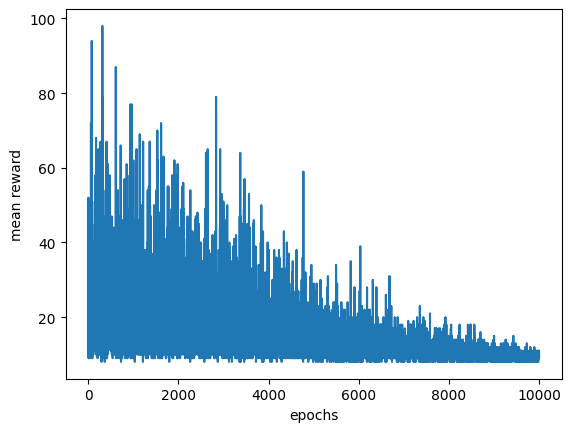

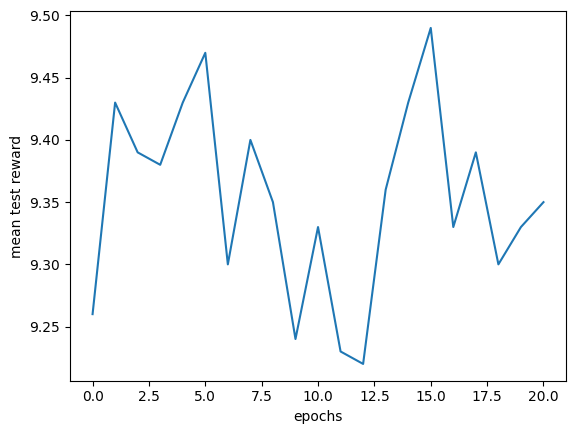

best_res_idx  0   9.35
TIME:  0.8746472517649333  min

HIDDEN SIZE:  4 3
Best rewards so far: 39.0
0  success percent   0.0  mean reward  9.3
Best rewards so far: 72.0
Best rewards so far: 79.0
Best rewards so far: 82.0
0  success percent   0.0  mean reward  9.32
Best rewards so far: 108.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.28
0  success percent   0.0  mean reward  9.39
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.22
0  success percent   0.0  mean reward  9.41
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.27
0  success percent   0.0  mean reward  9.44
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.44
0  success percent   0.0  mean reward  9.23
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.41
Episode 6000 Epsilon 0.40030000000006605
0  success percent   0.0  mean re

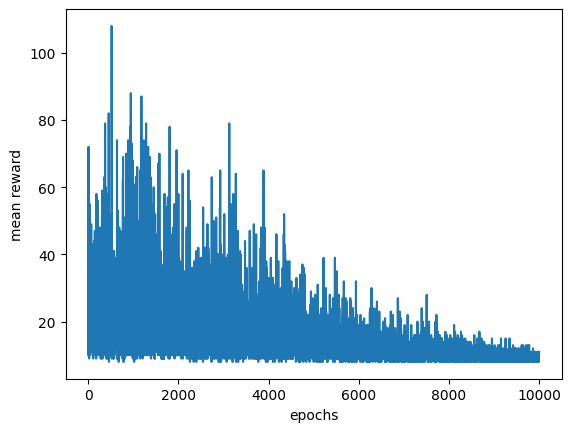

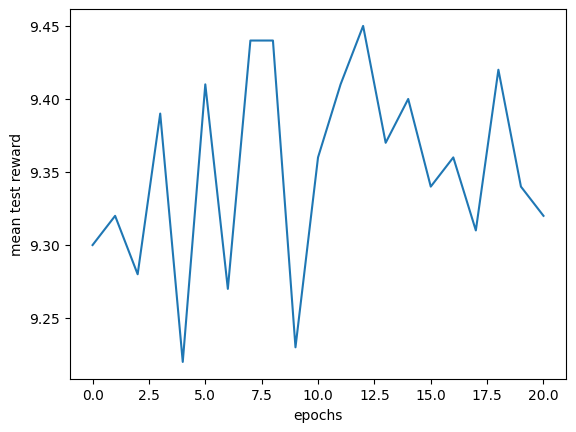

best_res_idx  0   9.4
TIME:  0.8448086778322855  min

HIDDEN SIZE:  4 4
Best rewards so far: 10.0
0  success percent   0.0  mean reward  9.35
Best rewards so far: 17.0
Best rewards so far: 22.0
Best rewards so far: 28.0
Best rewards so far: 67.0
Best rewards so far: 70.0
0  success percent   0.0  mean reward  9.29
Best rewards so far: 93.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.35
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.46
0  success percent   0.0  mean reward  9.43
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.44
0  success percent   0.0  mean reward  9.38
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.39
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.32
0  success percent   0.0  mean reward  9.42
Episode 6000 Epsilon 0.40

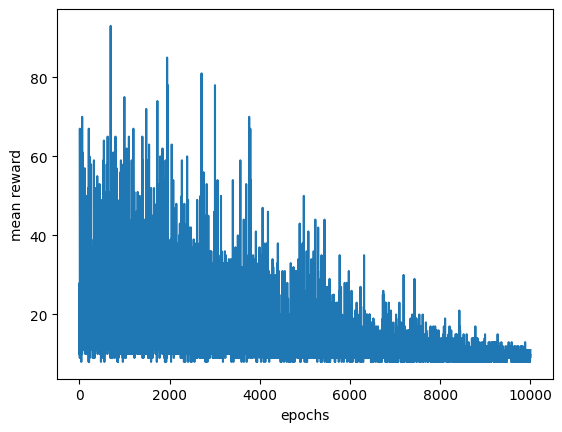

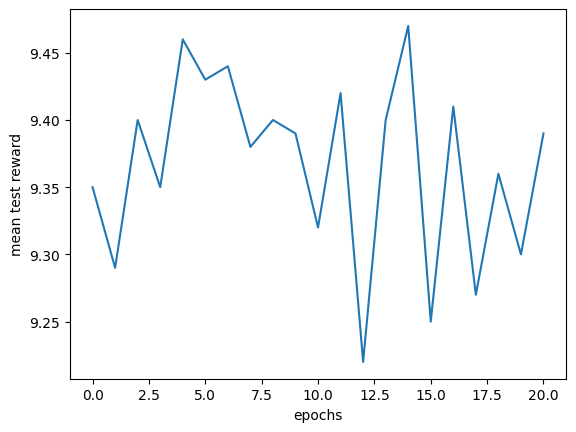

best_res_idx  0   9.36
TIME:  0.8382428924242655  min

HIDDEN SIZE:  5 4
Best rewards so far: 14.0
0  success percent   0.0  mean reward  9.32
Best rewards so far: 18.0
Best rewards so far: 20.0
Best rewards so far: 22.0
Best rewards so far: 34.0
Best rewards so far: 40.0
Best rewards so far: 54.0
Best rewards so far: 62.0
Best rewards so far: 87.0
0  success percent   0.0  mean reward  9.38
Best rewards so far: 117.0
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.31
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  9.22
0  success percent   0.0  mean reward  9.28
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.29
Episode 4000 Epsilon 0.600400000000044
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.36
Episode 5000 Epsilon 0.500400000000055
0  success percent   0.0  mean 

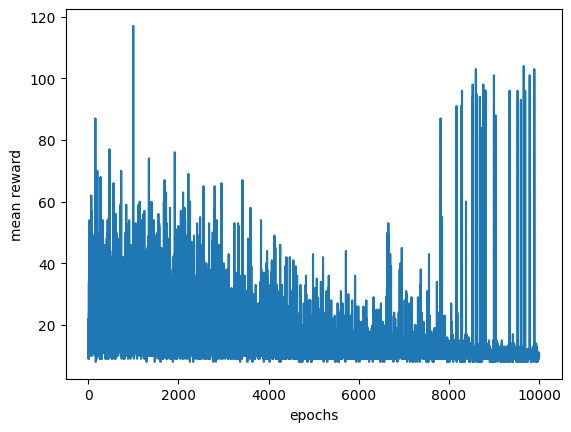

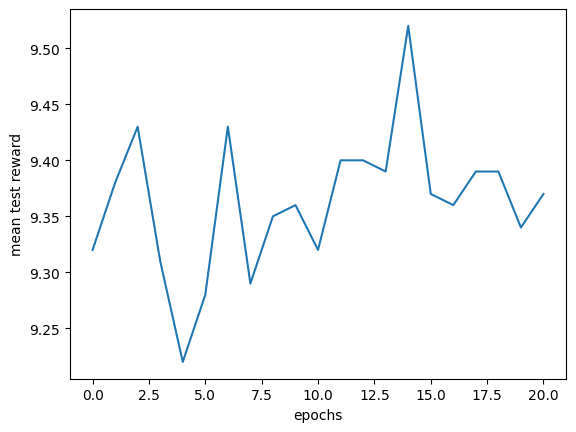

best_res_idx  0   9.38
TIME:  0.8483664075533549  min

HIDDEN SIZE:  5 5
Best rewards so far: 78.0
0  success percent   0.0  mean reward  9.48
Best rewards so far: 126.0
0  success percent   0.0  mean reward  9.31
Episode 1000 Epsilon 0.900000000000011
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.32
Episode 2000 Epsilon 0.800000000000022
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.33
Episode 3000 Epsilon 0.700000000000033
0  success percent   0.0  mean reward  9.4
Best rewards so far: 141.0
0  success percent   0.0  mean reward  9.76
Episode 4000 Epsilon 0.600000000000044
0  success percent   0.0  mean reward  9.89
0  success percent   0.0  mean reward  9.78
Episode 5000 Epsilon 0.5000000000000551
0  success percent   0.0  mean reward  9.76
0  success percent   0.0  mean reward  9.81
Episode 6000 Epsilon 0.4000000000000661
0  success percent   0.0  mean reward  9.83
0  success percent   0.0  mean reward  9

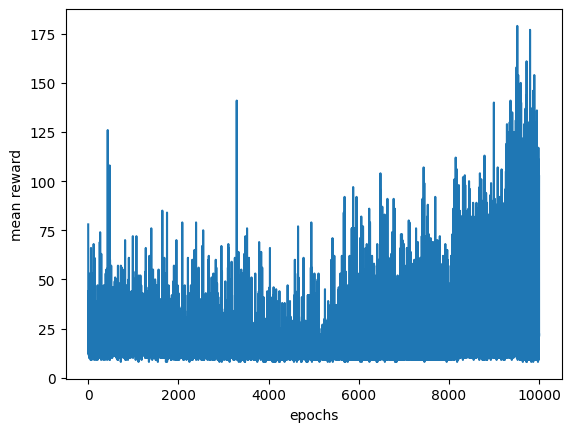

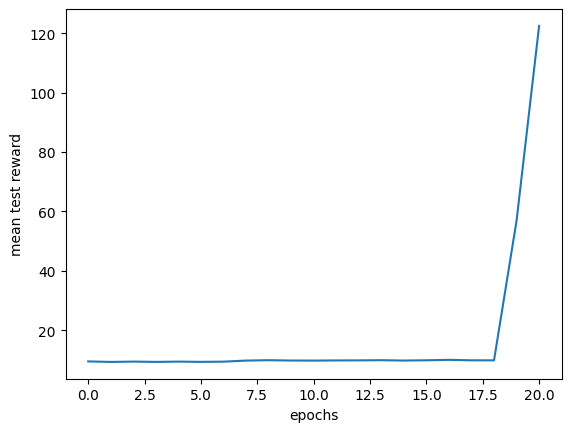

best_res_idx  0   122.37
TIME:  0.9685949603716533  min

HIDDEN SIZE:  6 5
Best rewards so far: 28.0
0  success percent   0.0  mean reward  105.67
Best rewards so far: 38.0
Best rewards so far: 85.0
0  success percent   3.0  mean reward  135.44
Best rewards so far: 107.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  84.53
Best rewards so far: 114.0
0  success percent   0.0  mean reward  87.03
Best rewards so far: 127.0
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  123.75
0  success percent   2.0  mean reward  124.61
Best rewards so far: 158.0
Episode 3000 Epsilon 0.700200000000033
0  success percent   4.0  mean reward  89.62
0  success percent   1.0  mean reward  108.41
Episode 4000 Epsilon 0.600200000000044
0  success percent   1.0  mean reward  105.21
0  success percent   1.0  mean reward  97.59
Episode 5000 Epsilon 0.500200000000055
0  success percent   2.0  mean reward  100.26
0  success percent   0.0  mean reward  101

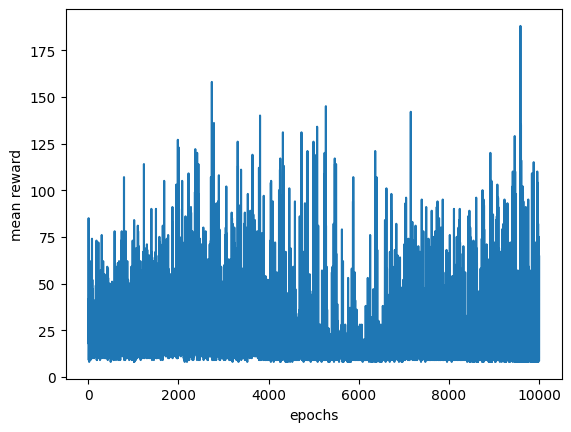

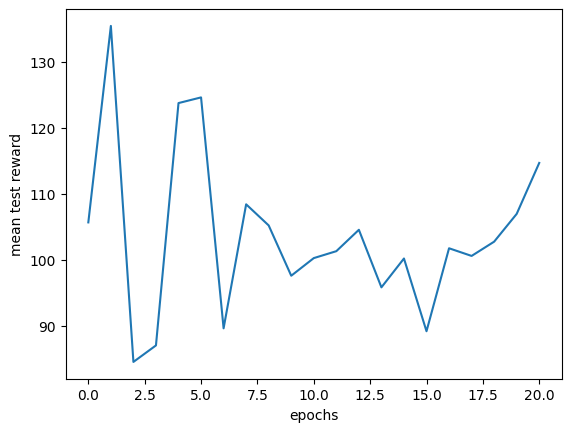

best_res_idx  0   110.02
TIME:  1.0090667883555093  min

HIDDEN SIZE:  6 6
Best rewards so far: 17.0
0  success percent   7.0  mean reward  104.28
Best rewards so far: 29.0
Best rewards so far: 46.0
Best rewards so far: 72.0
Best rewards so far: 94.0
0  success percent   0.0  mean reward  9.64
Best rewards so far: 97.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  161.42
Best rewards so far: 131.0
Best rewards so far: 151.0
0  success percent   91.0  mean reward  199.13
Episode 2000 Epsilon 0.800200000000022
0  success percent   97.0  mean reward  199.79
0  success percent   91.0  mean reward  199.07
Best rewards so far: 202.0
Episode 3000 Epsilon 0.700200000000033
0  success percent   3.0  mean reward  174.0
0  success percent   2.0  mean reward  173.93
Episode 4000 Epsilon 0.600200000000044
0  success percent   6.0  mean reward  174.31
0  success percent   4.0  mean reward  174.64
Best rewards so far: 206.0
Episode 5000 Epsilon 0.500200000000055
0  suc

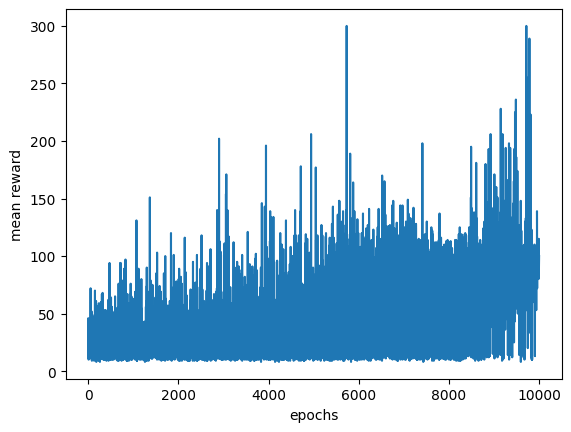

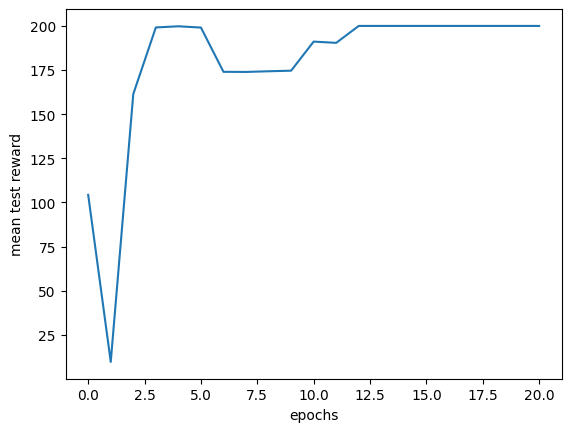

best_res_idx  0   200.0
[4, 6, 6, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 19.0
0  success percent   0.0  mean reward  9.34
Best rewards so far: 34.0
Best rewards so far: 36.0
Best rewards so far: 37.0
Best rewards so far: 43.0
Best rewards so far: 62.0
Best rewards so far: 65.0
Best rewards so far: 78.0
Best rewards so far: 79.0
0  success percent   0.0  mean reward  9.3
Best rewards so far: 80.0
Best rewards so far: 96.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  16.06
0  success percent   0.0  mean reward  16.64
Best rewards so far: 98.0
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  11.68
Best rewards so far: 101.0
0  success percent   0.0  mean reward  9.35
Best rewards so far: 103.0
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.31
Episode 4000 Epsilon 0.600200000000044
0  suc

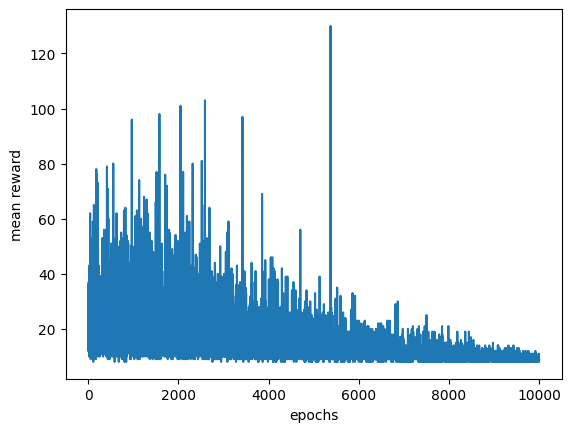

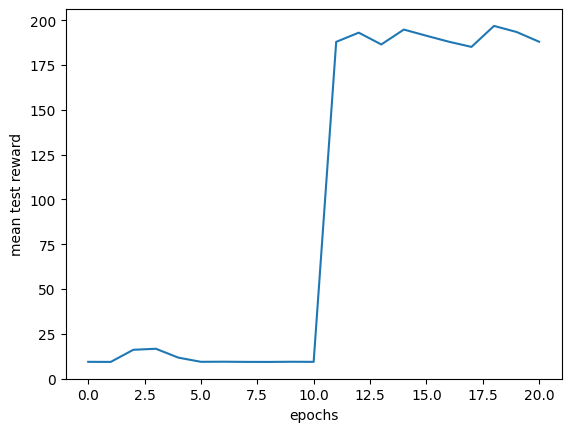

best_res_idx  0   193.85
[4, 3, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 17.0
0  success percent   0.0  mean reward  9.34
Best rewards so far: 31.0
Best rewards so far: 39.0
Best rewards so far: 73.0
Best rewards so far: 82.0
0  success percent   0.0  mean reward  9.27
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.17
Best rewards so far: 100.0
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.41
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.3
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.21
0  success percent   0.0  mean reward  9.32
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.34
Epi

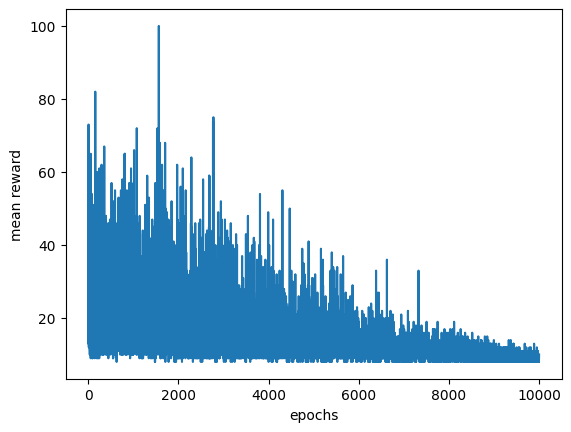

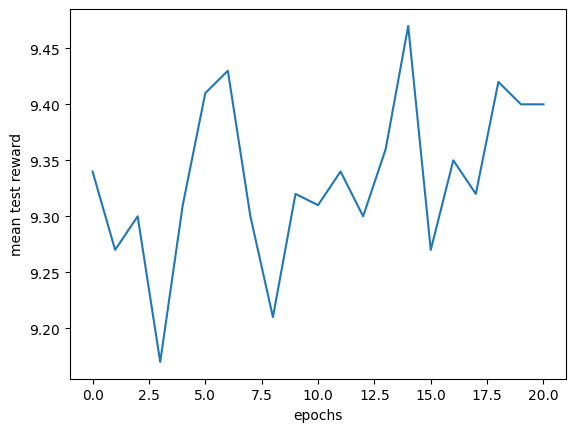

best_res_idx  0   9.4
TIME:  0.8452922423680623  min

HIDDEN SIZE:  4 3
Best rewards so far: 20.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 40.0
Best rewards so far: 78.0
Best rewards so far: 80.0
0  success percent   0.0  mean reward  9.39
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.33
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.21
0  success percent   0.0  mean reward  9.26
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.41
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.41
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.49
0  success percent   0.0  mean reward  9.19
Episode 6000 Epsilon 0.40020000000006606
0  success percent   0.0  mean reward  9.45
0  success perce

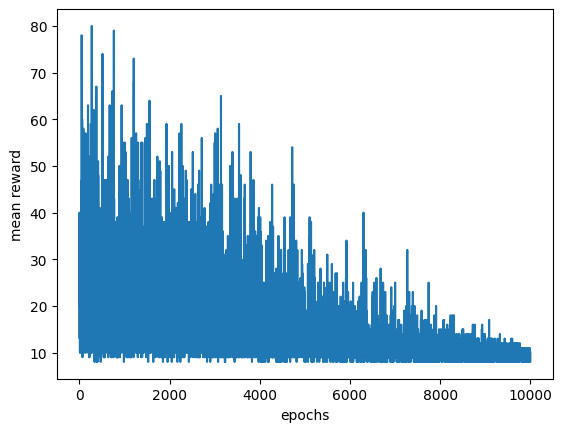

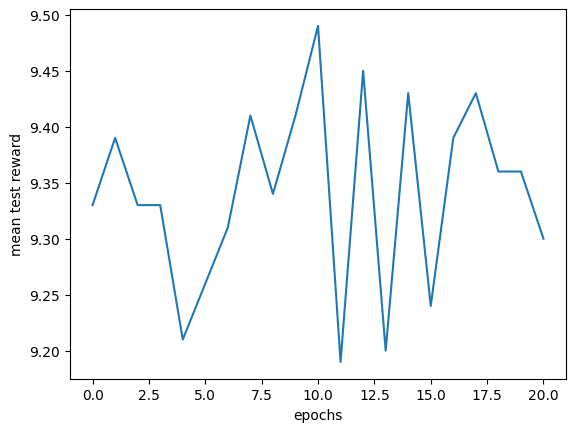

best_res_idx  0   9.38
TIME:  0.6943728844324748  min

HIDDEN SIZE:  4 4
Best rewards so far: 15.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 17.0
Best rewards so far: 20.0
Best rewards so far: 48.0
Best rewards so far: 57.0
Best rewards so far: 58.0
Best rewards so far: 62.0
Best rewards so far: 80.0
0  success percent   0.0  mean reward  9.41
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.42
Best rewards so far: 90.0
Best rewards so far: 99.0
0  success percent   0.0  mean reward  9.39
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.25
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.35
Episode 4000 Epsilon 0.600400000000044
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.3
Episode 5000 Epsilon 0.500400000000055
0  success percent   0.0  mean re

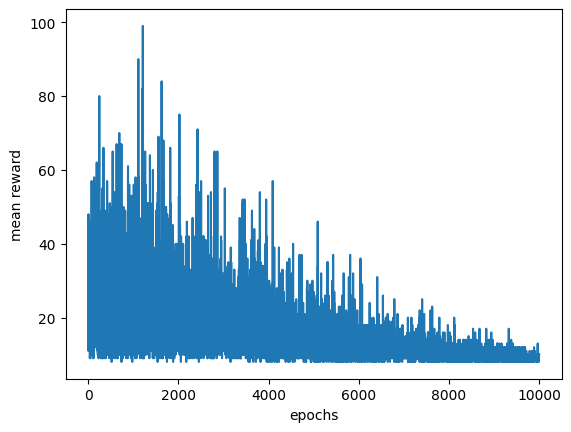

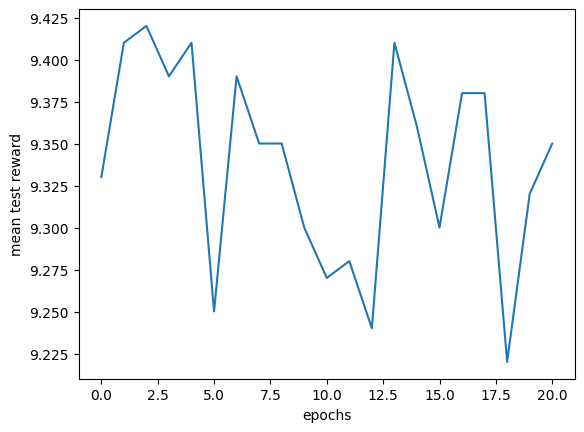

best_res_idx  0   9.45
TIME:  0.7076472640037537  min

HIDDEN SIZE:  5 4
Best rewards so far: 20.0
0  success percent   0.0  mean reward  9.29
Best rewards so far: 43.0
Best rewards so far: 93.0
0  success percent   0.0  mean reward  9.25
Best rewards so far: 96.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.46
0  success percent   0.0  mean reward  9.39
Best rewards so far: 98.0
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.28
0  success percent   0.0  mean reward  9.34
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.5
0  success percent   0.0  mean reward  9.38
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.41
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.33
Episode 6000 Epsilon 0.40030000000006605
0  success percent   0.0  mean rew

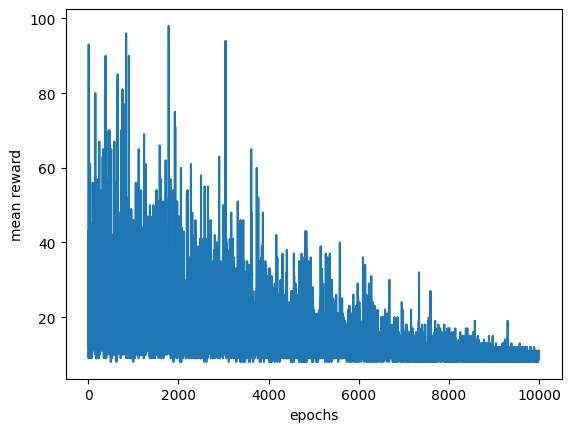

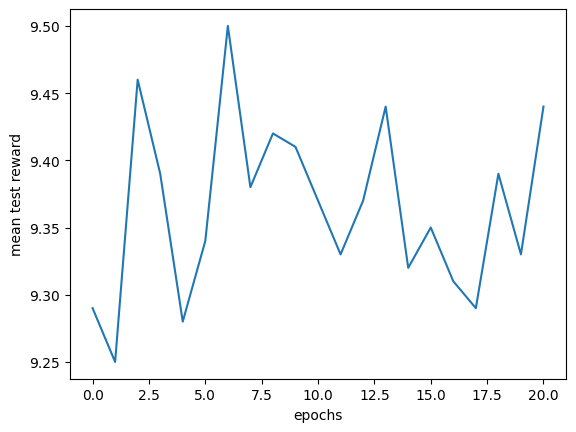

best_res_idx  0   9.23
TIME:  0.8873146931330363  min

HIDDEN SIZE:  5 5
Best rewards so far: 23.0
0  success percent   0.0  mean reward  9.47
Best rewards so far: 28.0
Best rewards so far: 46.0
Best rewards so far: 54.0
Best rewards so far: 55.0
Best rewards so far: 61.0
Best rewards so far: 62.0
Best rewards so far: 86.0
0  success percent   0.0  mean reward  9.3
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.41
Best rewards so far: 108.0
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.28
0  success percent   0.0  mean reward  9.35
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.16
0  success percent   0.0  mean reward  9.26
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.2
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.26
0  success perce

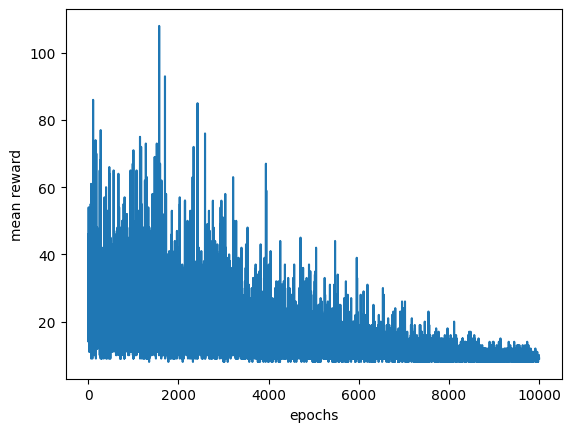

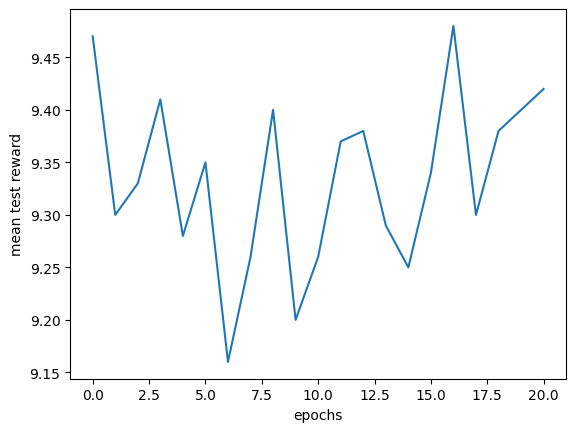

best_res_idx  0   9.28
TIME:  0.865174126625061  min

HIDDEN SIZE:  6 5
Best rewards so far: 27.0
0  success percent   0.0  mean reward  9.37
Best rewards so far: 36.0
Best rewards so far: 39.0
Best rewards so far: 42.0
Best rewards so far: 62.0
Best rewards so far: 65.0
Best rewards so far: 67.0
Best rewards so far: 81.0
0  success percent   0.0  mean reward  9.27
Best rewards so far: 101.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.44
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.46
0  success percent   0.0  mean reward  9.42
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.21
0  success percent   0.0  mean reward  9.35
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.46
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.38
0  success per

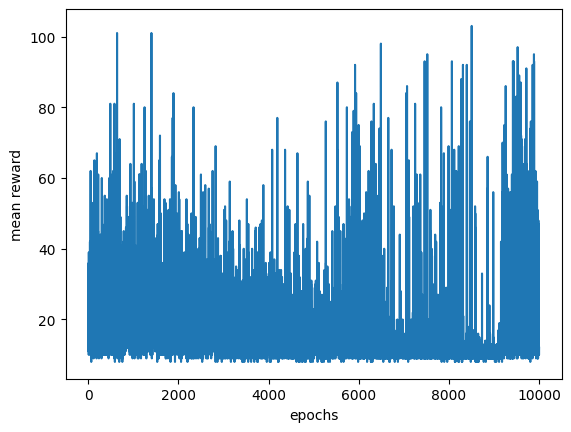

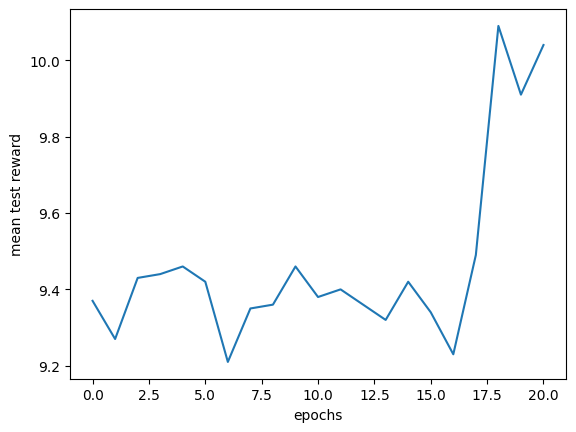

best_res_idx  0   10.06
TIME:  0.868552815914154  min

HIDDEN SIZE:  6 6
Best rewards so far: 13.0
0  success percent   0.0  mean reward  9.99
Best rewards so far: 19.0
Best rewards so far: 21.0
Best rewards so far: 24.0
Best rewards so far: 26.0
Best rewards so far: 30.0
Best rewards so far: 40.0
Best rewards so far: 67.0
Best rewards so far: 87.0
Best rewards so far: 94.0
0  success percent   0.0  mean reward  19.49
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  26.03
0  success percent   0.0  mean reward  20.15
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  24.54
Best rewards so far: 112.0
0  success percent   0.0  mean reward  32.78
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  25.81
0  success percent   0.0  mean reward  32.11
Best rewards so far: 115.0
Episode 4000 Epsilon 0.600400000000044
0  success percent   26.0  mean reward  141.87
Best rewards so far: 144.0
0  success percent   100

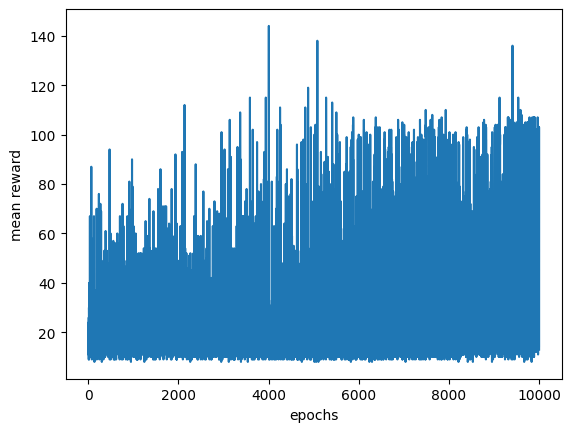

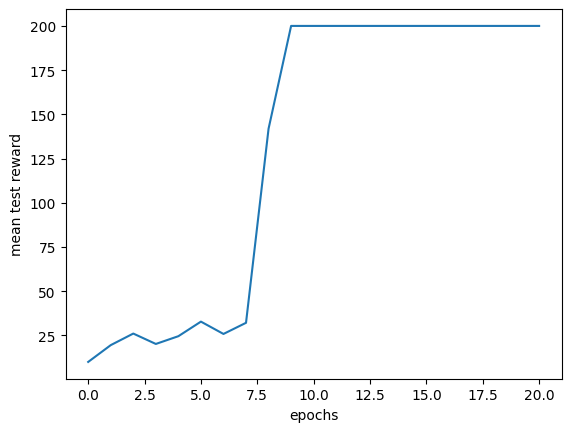

best_res_idx  0   200.0
[4, 6, 6, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 25.0
0  success percent   0.0  mean reward  9.36
Best rewards so far: 32.0
Best rewards so far: 42.0
Best rewards so far: 44.0
Best rewards so far: 50.0
Best rewards so far: 54.0
Best rewards so far: 60.0
Best rewards so far: 85.0
Best rewards so far: 102.0
0  success percent   0.0  mean reward  9.36
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.26
0  success percent   0.0  mean reward  9.31
Best rewards so far: 120.0
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.32
0  success percent   0.0  mean reward  9.45
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.29
0  success percent   0.0  mean reward  9.2
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.19
0  success percent   0.0  mean reward  9.27
Episode 5000 Epsilon 0.50

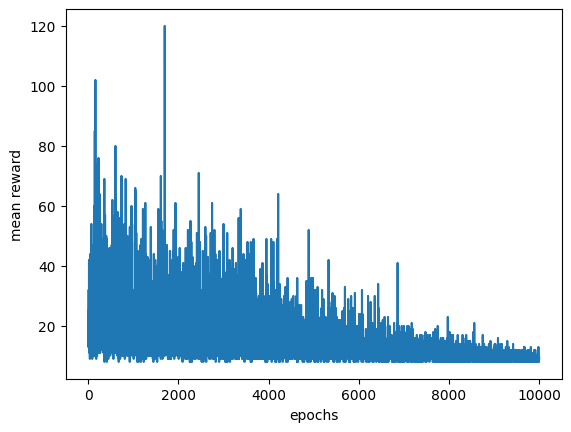

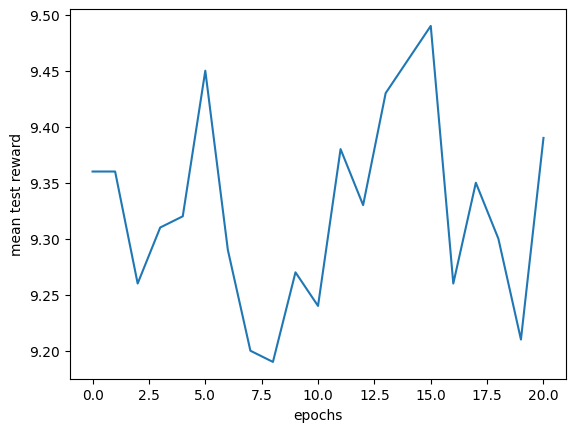

best_res_idx  0   9.15
TIME:  1.1305758396784464  min

HIDDEN SIZE:  4 3
Best rewards so far: 18.0
0  success percent   0.0  mean reward  9.42
Best rewards so far: 37.0
Best rewards so far: 45.0
Best rewards so far: 48.0
Best rewards so far: 60.0
Best rewards so far: 65.0
Best rewards so far: 74.0
0  success percent   0.0  mean reward  9.21
Best rewards so far: 85.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.3
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.3
Best rewards so far: 101.0
Best rewards so far: 109.0
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.24
0  success percent   0.0  mean reward  9.31
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.33
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean re

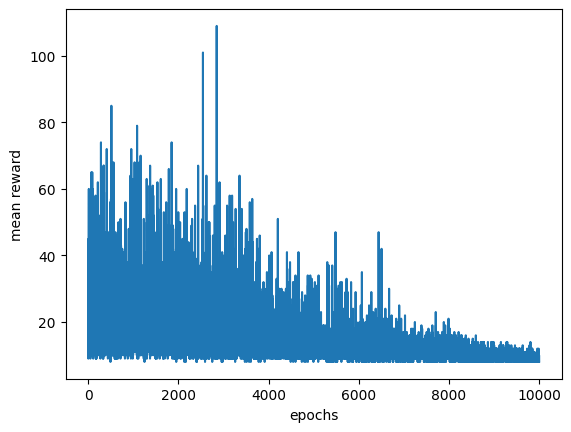

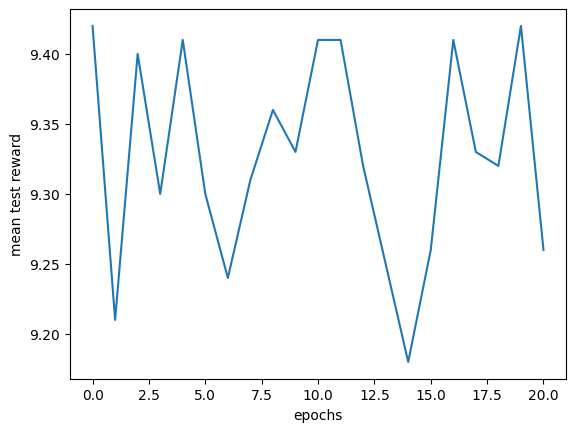

best_res_idx  0   9.39
TIME:  0.8718956867853801  min

HIDDEN SIZE:  4 4
Best rewards so far: 56.0
0  success percent   0.0  mean reward  9.36
Best rewards so far: 62.0
Best rewards so far: 81.0
Best rewards so far: 91.0
Best rewards so far: 99.0
0  success percent   0.0  mean reward  9.39
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  9.18
0  success percent   0.0  mean reward  9.15
Episode 2000 Epsilon 0.800100000000022
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.25
Episode 3000 Epsilon 0.700100000000033
0  success percent   0.0  mean reward  9.22
0  success percent   0.0  mean reward  9.29
Episode 4000 Epsilon 0.600100000000044
0  success percent   0.0  mean reward  9.25
0  success percent   0.0  mean reward  9.18
Episode 5000 Epsilon 0.5001000000000551
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.27
Episode 6000 Epsilon 0.40010000000006607
0  success percent   0.0  mean r

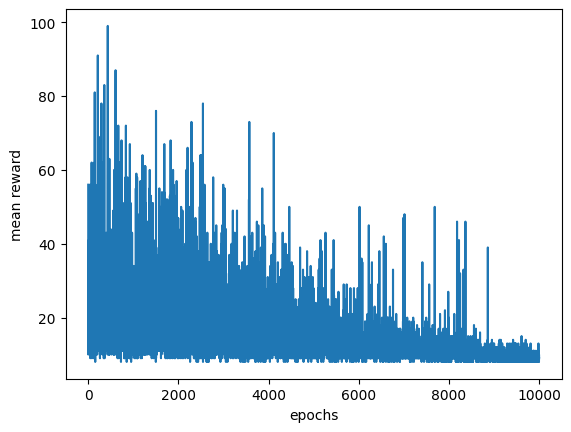

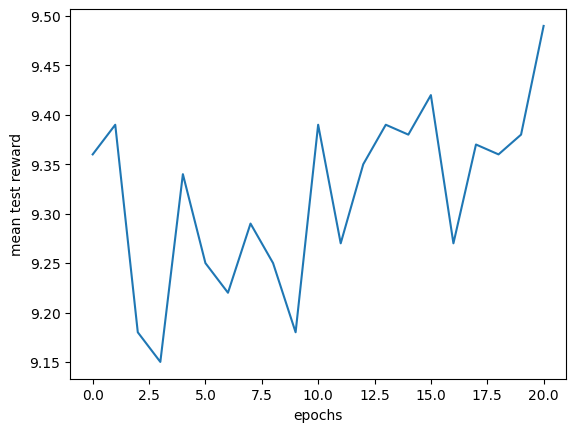

best_res_idx  0   9.39
TIME:  0.8541767875353495  min

HIDDEN SIZE:  5 4
Best rewards so far: 15.0
0  success percent   0.0  mean reward  9.54
Best rewards so far: 34.0
Best rewards so far: 45.0
Best rewards so far: 60.0
Best rewards so far: 66.0
Best rewards so far: 68.0
Best rewards so far: 72.0
Best rewards so far: 73.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 93.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.62
0  success percent   0.0  mean reward  9.65
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.69
Best rewards so far: 102.0
0  success percent   0.0  mean reward  9.32
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.43
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.33
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean 

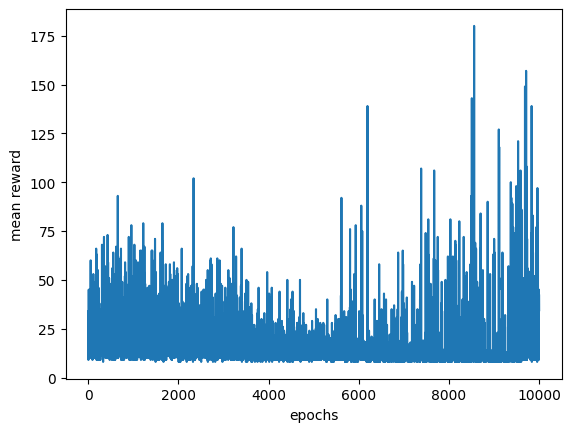

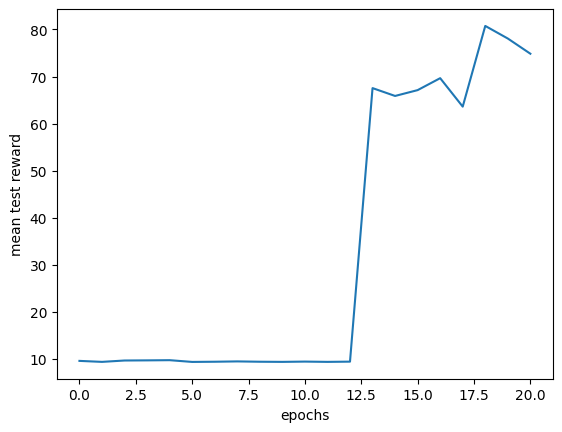

best_res_idx  0   77.63
TIME:  0.8742405374844869  min

HIDDEN SIZE:  5 5
Best rewards so far: 11.0
0  success percent   0.0  mean reward  75.75
Best rewards so far: 44.0
Best rewards so far: 49.0
Best rewards so far: 67.0
Best rewards so far: 68.0
Best rewards so far: 71.0
Best rewards so far: 77.0
0  success percent   0.0  mean reward  40.81
Best rewards so far: 80.0
Best rewards so far: 85.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  27.22
Best rewards so far: 97.0
0  success percent   0.0  mean reward  9.33
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.41
Best rewards so far: 102.0
0  success percent   1.0  mean reward  100.48
Best rewards so far: 118.0
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  69.26
0  success percent   1.0  mean reward  67.76
Best rewards so far: 133.0
Episode 4000 Epsilon 0.600200000000044
0  success percent   2.0  mean reward  107.42
Best rewards so far: 146

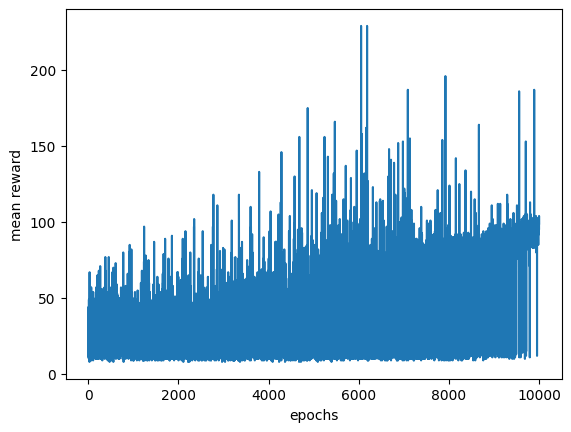

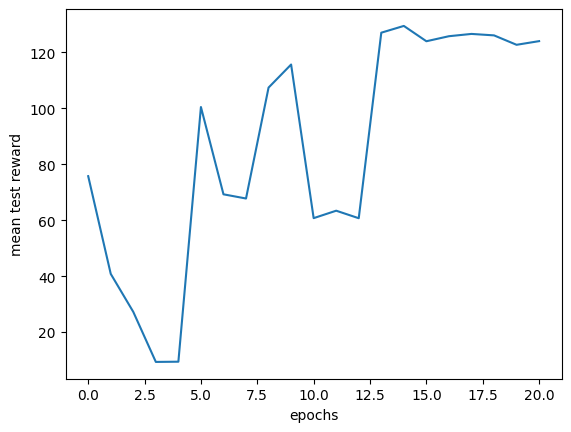

best_res_idx  0   125.95
TIME:  0.964477292696635  min

HIDDEN SIZE:  6 5
Best rewards so far: 9.0
0  success percent   0.0  mean reward  74.17
Best rewards so far: 27.0
Best rewards so far: 36.0
Best rewards so far: 40.0
Best rewards so far: 56.0
Best rewards so far: 88.0
0  success percent   0.0  mean reward  80.92
Best rewards so far: 114.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  69.6
0  success percent   0.0  mean reward  68.66
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  69.9
0  success percent   0.0  mean reward  68.97
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  69.96
Best rewards so far: 118.0
0  success percent   0.0  mean reward  75.24
Best rewards so far: 122.0
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  107.84
0  success percent   3.0  mean reward  112.18
Best rewards so far: 135.0
Best rewards so far: 173.0
Episode 5000 Epsilon 0.5003000

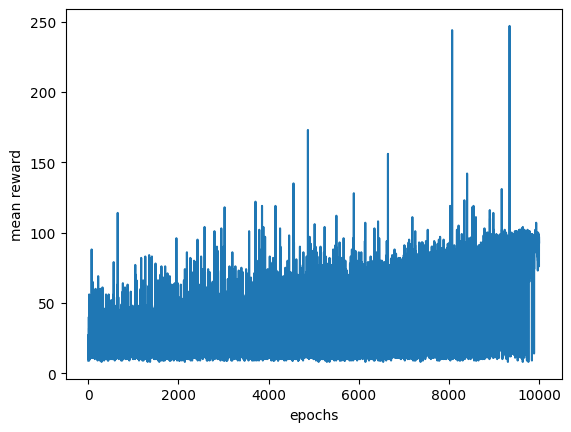

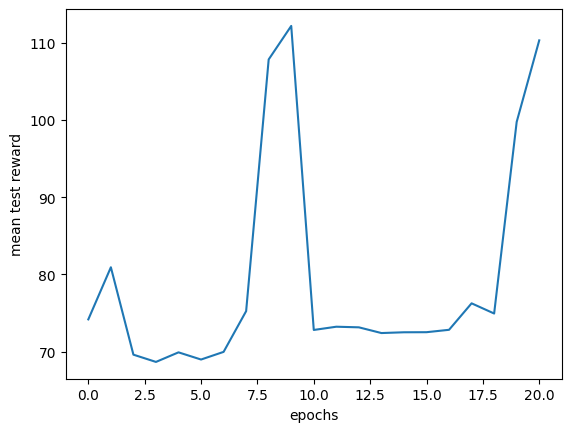

best_res_idx  0   101.56
TIME:  1.001278579235077  min

HIDDEN SIZE:  6 6
Best rewards so far: 31.0
0  success percent   4.0  mean reward  104.18
Best rewards so far: 46.0
Best rewards so far: 59.0
Best rewards so far: 65.0
Best rewards so far: 66.0
Best rewards so far: 70.0
Best rewards so far: 74.0
Best rewards so far: 77.0
Best rewards so far: 84.0
0  success percent   0.0  mean reward  90.2
Best rewards so far: 97.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  76.6
0  success percent   0.0  mean reward  76.27
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  76.37
Best rewards so far: 102.0
0  success percent   0.0  mean reward  89.37
Best rewards so far: 104.0
Episode 3000 Epsilon 0.700300000000033
0  success percent   3.0  mean reward  108.61
Best rewards so far: 119.0
0  success percent   0.0  mean reward  81.92
Best rewards so far: 136.0
Episode 4000 Epsilon 0.600300000000044
0  success percent   6.0  mean reward  126

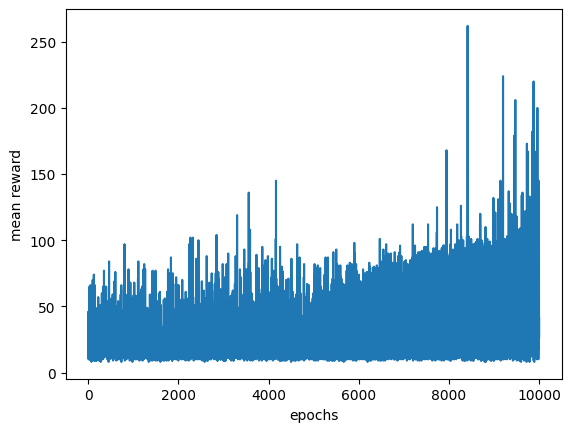

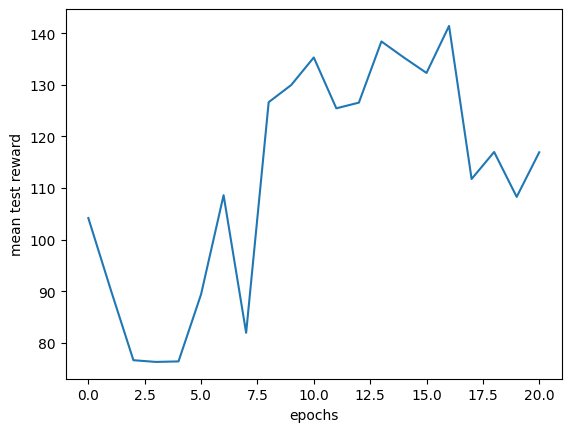

best_res_idx  0   114.62
TIME:  1.0723556399345398  min

HIDDEN SIZE:  7 6
Best rewards so far: 33.0
0  success percent   0.0  mean reward  106.67
Best rewards so far: 39.0
Best rewards so far: 40.0
Best rewards so far: 43.0
Best rewards so far: 54.0
Best rewards so far: 61.0
Best rewards so far: 84.0
Best rewards so far: 91.0
0  success percent   0.0  mean reward  73.97
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  74.22
0  success percent   0.0  mean reward  73.84
Best rewards so far: 103.0
Episode 2000 Epsilon 0.800100000000022
0  success percent   0.0  mean reward  87.47
Best rewards so far: 120.0
Best rewards so far: 153.0
0  success percent   0.0  mean reward  105.89
Episode 3000 Epsilon 0.700100000000033
0  success percent   0.0  mean reward  104.74
0  success percent   0.0  mean reward  105.14
Episode 4000 Epsilon 0.600100000000044
0  success percent   0.0  mean reward  104.79
Best rewards so far: 300.0
0  success percent   0.0  mean reward  147.

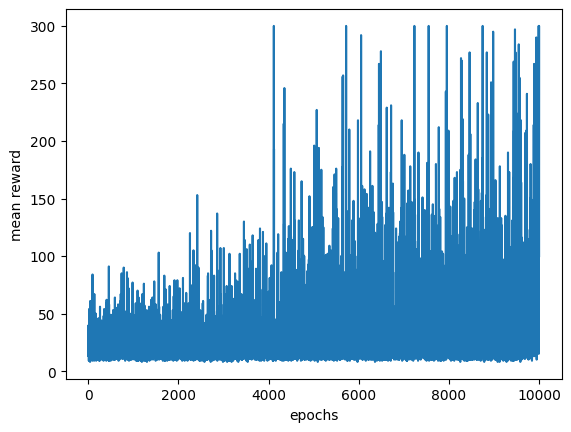

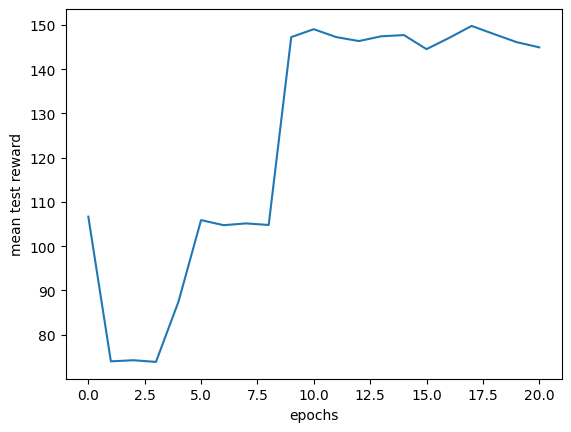

best_res_idx  0   147.09
TIME:  1.0966161251068116  min

HIDDEN SIZE:  3 3
Best rewards so far: 16.0
0  success percent   0.0  mean reward  9.6
Best rewards so far: 24.0
Best rewards so far: 28.0
Best rewards so far: 44.0
Best rewards so far: 57.0
Best rewards so far: 62.0
Best rewards so far: 79.0
0  success percent   0.0  mean reward  8.99
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.09
Best rewards so far: 95.0
0  success percent   0.0  mean reward  9.47
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.32
0  success percent   0.0  mean reward  9.48
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.3
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.39
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9

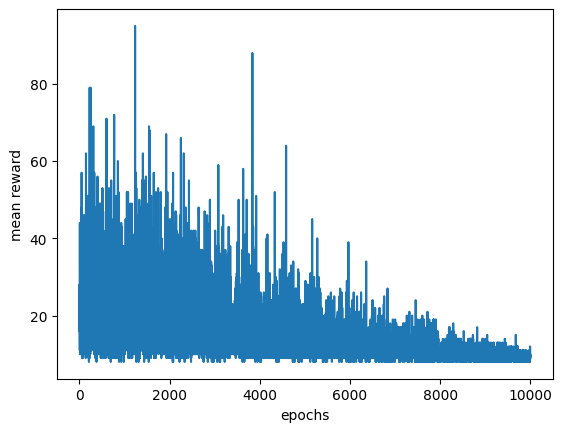

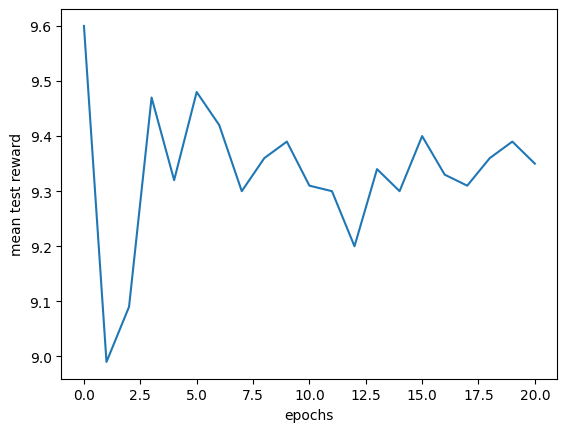

best_res_idx  0   9.35
TIME:  0.8121522466341654  min

HIDDEN SIZE:  4 3
Best rewards so far: 17.0
0  success percent   0.0  mean reward  9.41
Best rewards so far: 39.0
Best rewards so far: 54.0
Best rewards so far: 58.0
Best rewards so far: 69.0
Best rewards so far: 80.0
0  success percent   0.0  mean reward  9.31
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.46
Best rewards so far: 81.0
Best rewards so far: 104.0
0  success percent   0.0  mean reward  47.64
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  48.62
0  success percent   0.0  mean reward  46.88
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  46.5
0  success percent   0.0  mean reward  47.34
Best rewards so far: 105.0
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  23.84
Best rewards so far: 107.0
0  success percent   0.0  mean reward  27.84
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.

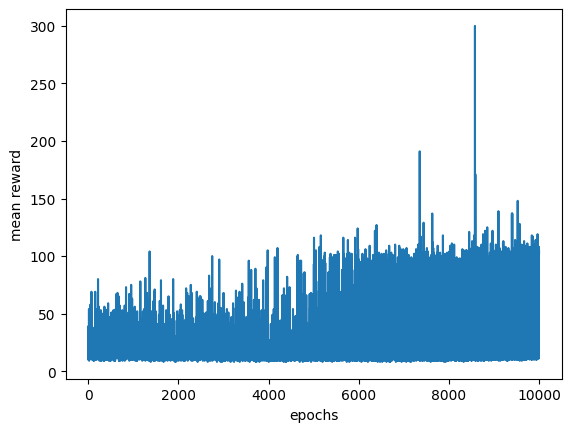

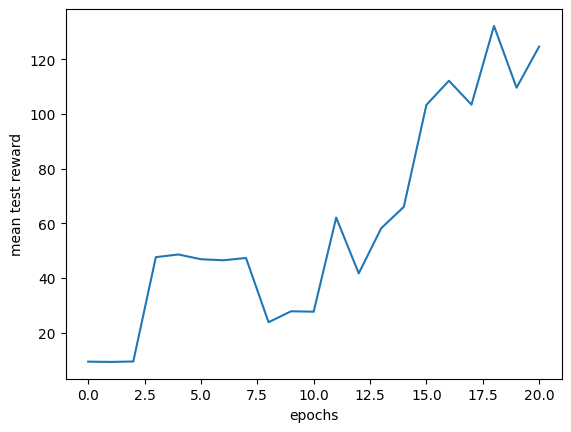

best_res_idx  0   121.01
TIME:  0.9532185912132263  min

HIDDEN SIZE:  4 4
Best rewards so far: 25.0
0  success percent   48.0  mean reward  102.06
Best rewards so far: 30.0
Best rewards so far: 41.0
Best rewards so far: 49.0
Best rewards so far: 55.0
Best rewards so far: 70.0
Best rewards so far: 73.0
Best rewards so far: 80.0
0  success percent   0.0  mean reward  121.96
Best rewards so far: 81.0
Best rewards so far: 113.0
Episode 1000 Epsilon 0.900400000000011
0  success percent   73.0  mean reward  196.83
0  success percent   77.0  mean reward  197.06
Best rewards so far: 118.0
Episode 2000 Epsilon 0.800400000000022
0  success percent   3.0  mean reward  175.04
0  success percent   5.0  mean reward  174.73
Episode 3000 Epsilon 0.700400000000033
0  success percent   3.0  mean reward  171.28
0  success percent   4.0  mean reward  174.28
Best rewards so far: 132.0
Episode 4000 Epsilon 0.600400000000044
0  success percent   1.0  mean reward  162.45
Best rewards so far: 137.0
Best rewar

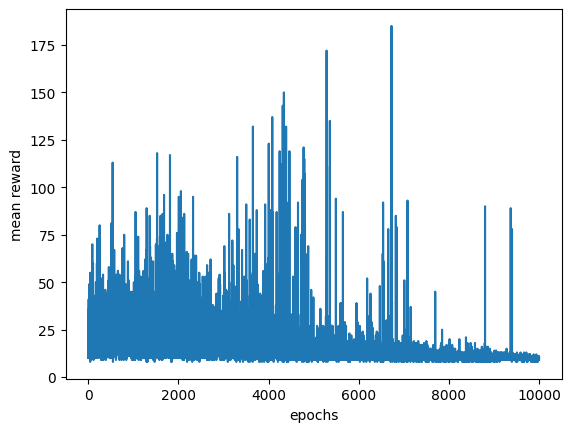

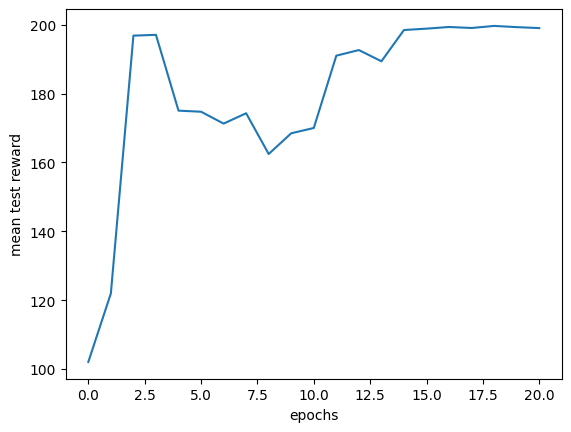

best_res_idx  0   198.43
TIME:  1.0436551014582316  min

HIDDEN SIZE:  5 4
Best rewards so far: 11.0
0  success percent   0.0  mean reward  163.72
Best rewards so far: 26.0
Best rewards so far: 41.0
Best rewards so far: 45.0
Best rewards so far: 56.0
Best rewards so far: 86.0
Best rewards so far: 88.0
0  success percent   0.0  mean reward  86.05
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  87.26
0  success percent   0.0  mean reward  81.83
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  84.62
Best rewards so far: 90.0
Best rewards so far: 104.0
0  success percent   0.0  mean reward  135.95
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  135.41
Best rewards so far: 106.0
0  success percent   0.0  mean reward  94.71
Best rewards so far: 119.0
Episode 4000 Epsilon 0.600300000000044
0  success percent   28.0  mean reward  181.97
Best rewards so far: 143.0
0  success percent   0.0  mean reward  137.

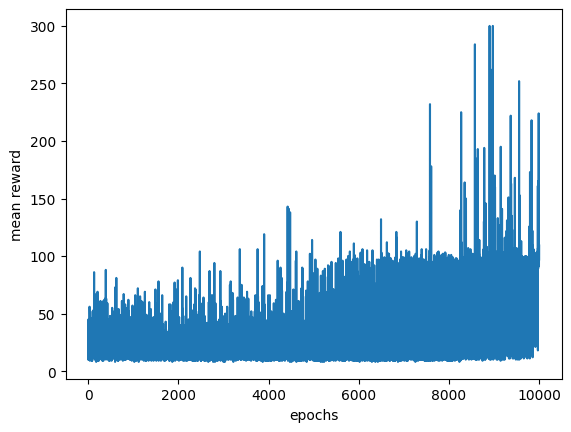

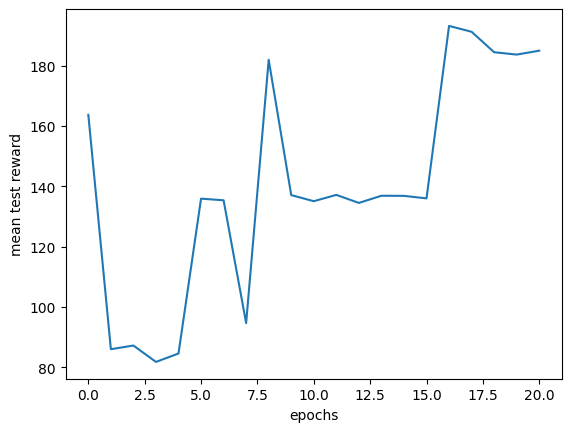

best_res_idx  0   185.43
TIME:  1.0982618133227031  min

HIDDEN SIZE:  5 5
Best rewards so far: 11.0
0  success percent   55.0  mean reward  186.2
Best rewards so far: 14.0
Best rewards so far: 17.0
Best rewards so far: 21.0
Best rewards so far: 25.0
Best rewards so far: 27.0
Best rewards so far: 42.0
Best rewards so far: 55.0
Best rewards so far: 70.0
Best rewards so far: 82.0
0  success percent   0.0  mean reward  88.63
Best rewards so far: 92.0
Best rewards so far: 97.0
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  89.54
Best rewards so far: 103.0
0  success percent   0.0  mean reward  98.2
Best rewards so far: 116.0
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  93.85
0  success percent   0.0  mean reward  93.93
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  92.89
Best rewards so far: 126.0
0  success percent   0.0  mean reward  91.4
Best rewards so far: 173.0
Episode 4000 Epsilon 0.600400

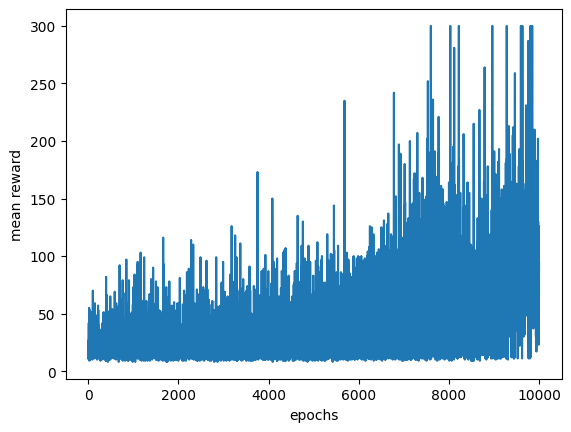

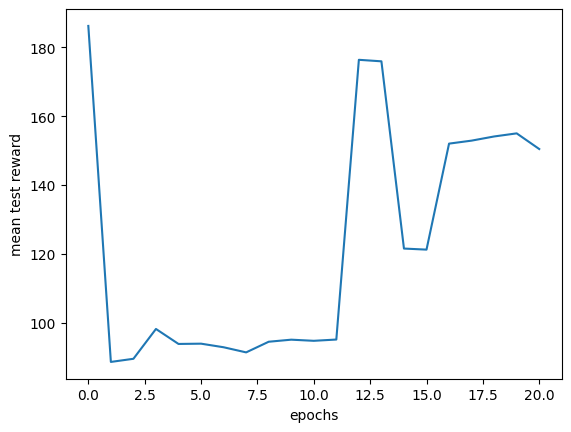

best_res_idx  0   153.35
TIME:  1.1300119360287983  min

HIDDEN SIZE:  6 5
Best rewards so far: 17.0
0  success percent   0.0  mean reward  109.37
Best rewards so far: 20.0
Best rewards so far: 33.0
Best rewards so far: 39.0
Best rewards so far: 45.0
Best rewards so far: 52.0
Best rewards so far: 72.0
Best rewards so far: 79.0
Best rewards so far: 83.0
0  success percent   0.0  mean reward  104.08
Best rewards so far: 99.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  96.0
Best rewards so far: 101.0
0  success percent   0.0  mean reward  100.58
Best rewards so far: 109.0
Best rewards so far: 131.0
Episode 2000 Epsilon 0.800300000000022
0  success percent   35.0  mean reward  165.67
Best rewards so far: 156.0
0  success percent   0.0  mean reward  135.89
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  133.11
Best rewards so far: 165.0
0  success percent   42.0  mean reward  182.38
Episode 4000 Epsilon 0.600300000000044
0  suc

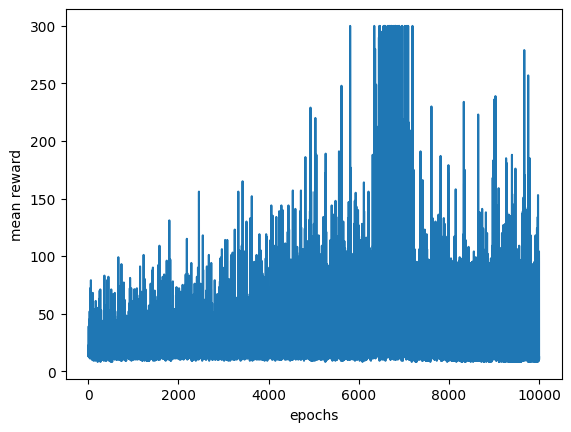

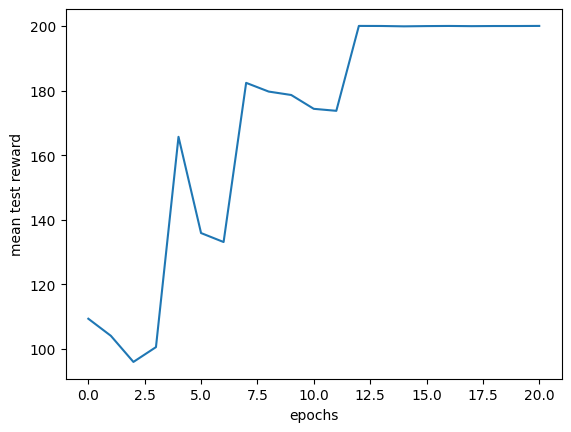

best_res_idx  0   199.92
[4, 6, 5, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 21.0
0  success percent   0.0  mean reward  9.34
Best rewards so far: 24.0
Best rewards so far: 36.0
Best rewards so far: 40.0
Best rewards so far: 49.0
Best rewards so far: 74.0
Best rewards so far: 86.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 98.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.4
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.5
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.53
0  success percent   0.0  mean reward  9.23
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.27
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9

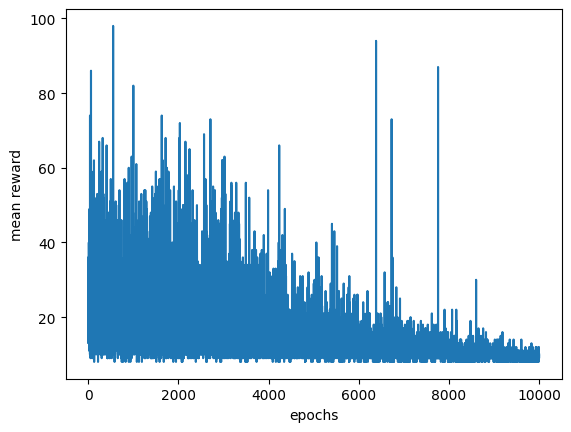

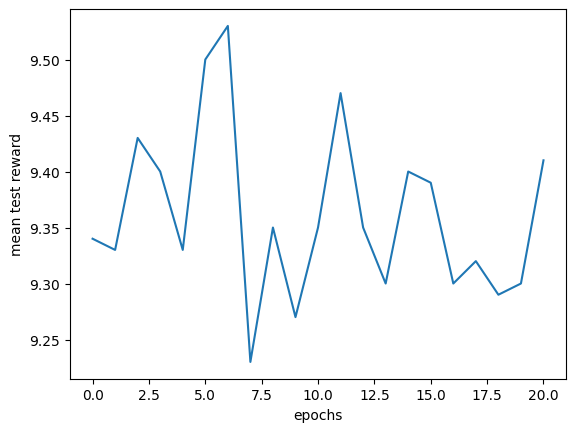

best_res_idx  0   9.3
TIME:  0.8369450728098552  min

HIDDEN SIZE:  4 3
Best rewards so far: 21.0
0  success percent   0.0  mean reward  9.36
Best rewards so far: 29.0
Best rewards so far: 48.0
Best rewards so far: 64.0
Best rewards so far: 86.0
0  success percent   0.0  mean reward  9.44
Best rewards so far: 105.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.27
0  success percent   0.0  mean reward  9.38
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.42
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.29
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.44
0  success percent   0.0  mean reward  9.31
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.31
Episode 6000 Epsilon 0.40030000000006605
0  succ

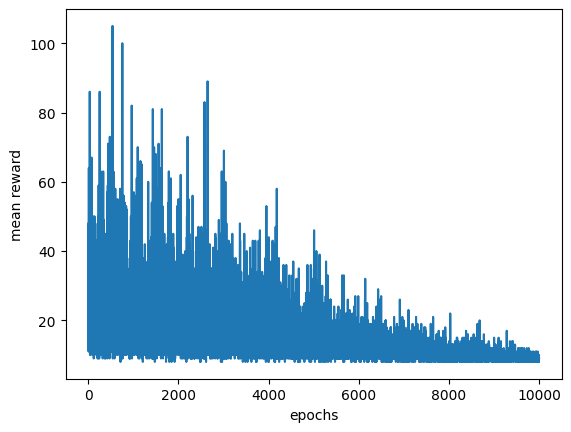

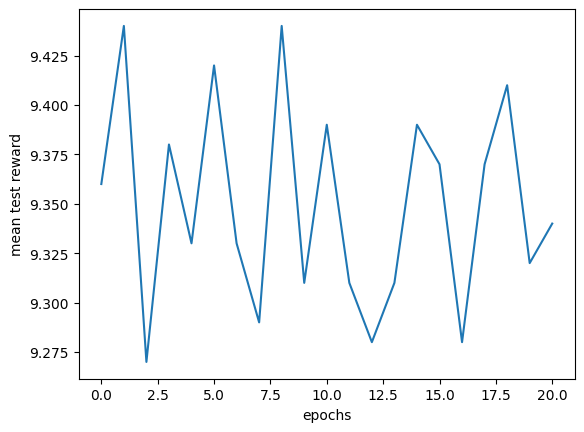

best_res_idx  0   9.3
TIME:  0.8009984254837036  min

HIDDEN SIZE:  4 4
Best rewards so far: 40.0
0  success percent   0.0  mean reward  9.28
Best rewards so far: 67.0
Best rewards so far: 83.0
Best rewards so far: 99.0
0  success percent   0.0  mean reward  9.38
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  9.27
Best rewards so far: 101.0
0  success percent   0.0  mean reward  9.41
Episode 2000 Epsilon 0.800100000000022
0  success percent   0.0  mean reward  9.23
0  success percent   0.0  mean reward  9.33
Episode 3000 Epsilon 0.700100000000033
0  success percent   0.0  mean reward  9.47
0  success percent   0.0  mean reward  9.44
Episode 4000 Epsilon 0.600100000000044
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.43
Episode 5000 Epsilon 0.5001000000000551
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.52
Episode 6000 Epsilon 0.40010000000006607
0  success percent   0.0  mean r

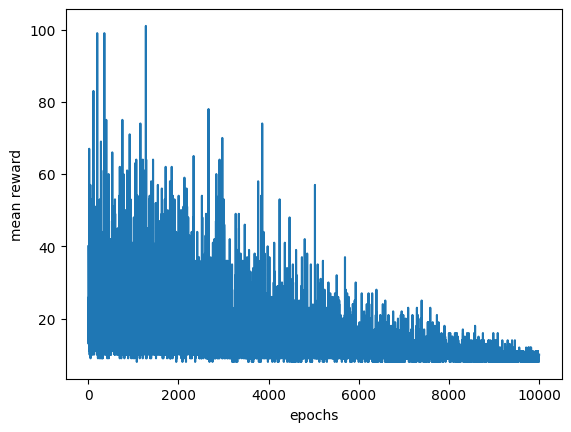

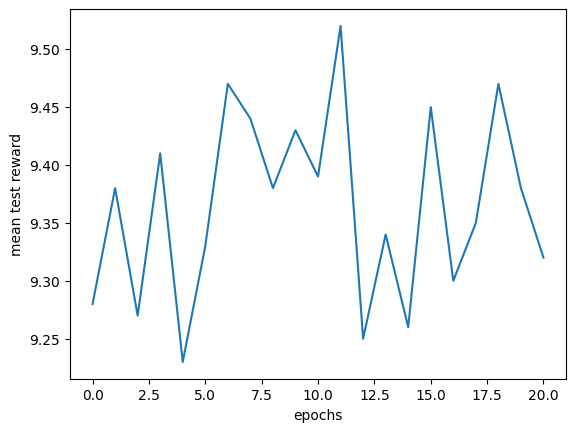

best_res_idx  0   9.41
TIME:  0.8162259300549825  min

HIDDEN SIZE:  5 4
Best rewards so far: 39.0
0  success percent   0.0  mean reward  9.57
Best rewards so far: 61.0
Best rewards so far: 66.0
Best rewards so far: 75.0
Best rewards so far: 78.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 120.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.38
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.32
0  success percent   0.0  mean reward  9.37
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.28
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.43
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.32
0  success percent   0.0  mean reward  9.41
Episode 6000 Epsilon 0.40020000000006606
0  suc

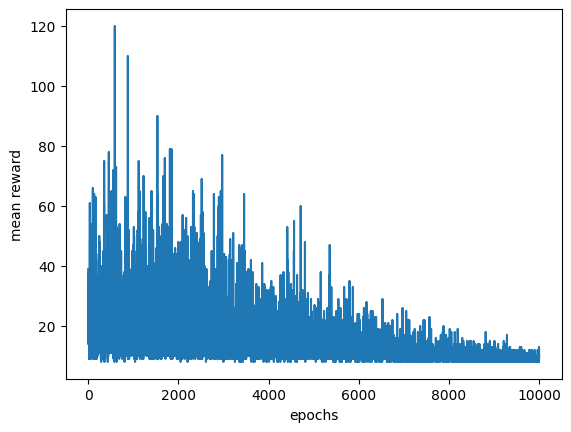

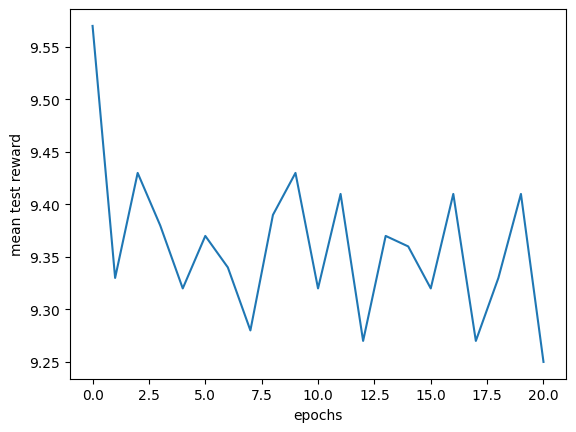

best_res_idx  0   9.28
TIME:  0.8186020294825236  min

HIDDEN SIZE:  5 5
Best rewards so far: 22.0
0  success percent   0.0  mean reward  9.28
Best rewards so far: 23.0
Best rewards so far: 28.0
Best rewards so far: 30.0
Best rewards so far: 49.0
Best rewards so far: 113.0
0  success percent   0.0  mean reward  9.41
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.32
0  success percent   0.0  mean reward  9.4
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  9.27
0  success percent   0.0  mean reward  9.42
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  9.27
0  success percent   0.0  mean reward  9.47
Episode 4000 Epsilon 0.600400000000044
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.41
Episode 5000 Epsilon 0.500400000000055
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.27
Episode 6000 Epsilon 0.40040000000006604
0  succe

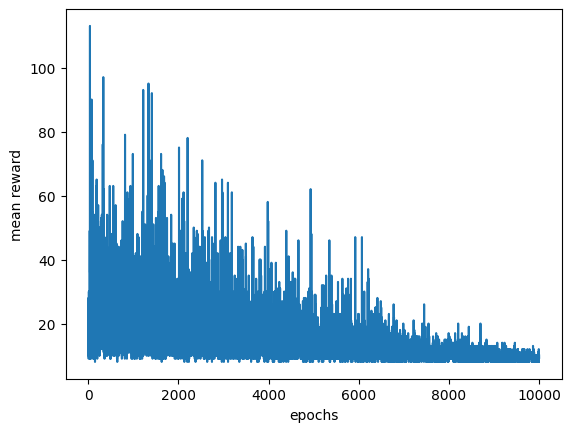

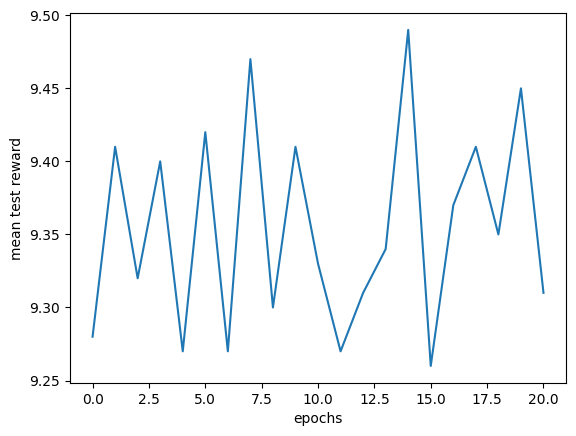

best_res_idx  0   9.35
TIME:  0.8230299154917399  min

HIDDEN SIZE:  6 5
Best rewards so far: 35.0
0  success percent   0.0  mean reward  9.29
Best rewards so far: 86.0
0  success percent   0.0  mean reward  9.43
Best rewards so far: 88.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.41
Best rewards so far: 127.0
0  success percent   0.0  mean reward  9.43
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.4
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.35
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.4
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.35
Episode 6000 Epsilon 0.40020000000006606
0  success percent   0.0  mean reward  9.46
0  success perce

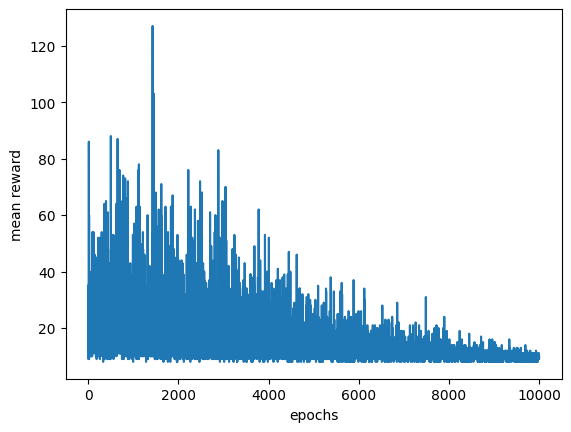

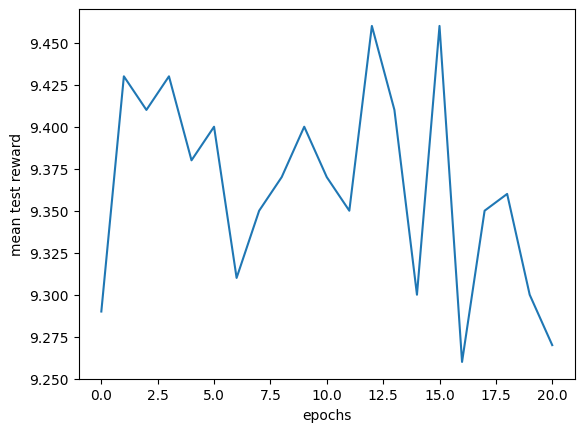

best_res_idx  0   9.3
TIME:  0.8235637625058492  min

HIDDEN SIZE:  6 6
Best rewards so far: 13.0
0  success percent   0.0  mean reward  9.47
Best rewards so far: 18.0
Best rewards so far: 48.0
Best rewards so far: 52.0
Best rewards so far: 62.0
Best rewards so far: 76.0
Best rewards so far: 80.0
Best rewards so far: 86.0
0  success percent   0.0  mean reward  9.4
Best rewards so far: 117.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.4
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.34
Best rewards so far: 123.0
0  success percent   0.0  mean reward  122.13
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  124.61
0  success percent   0.0  mean reward  123.15
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  122.57
0  success percent   0.0  mean reward  123.66
Best rewards so far: 128.0
Episode 5000 Epsilon 0.500300000000

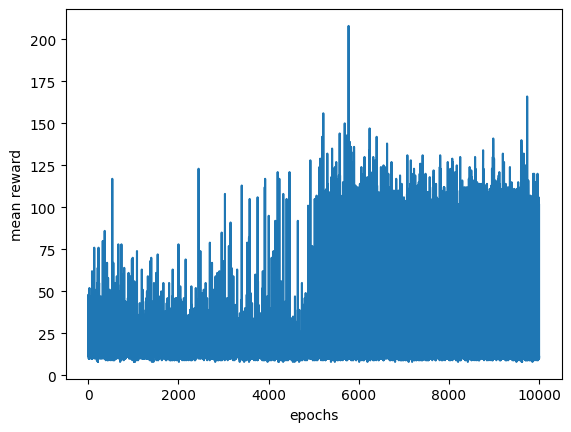

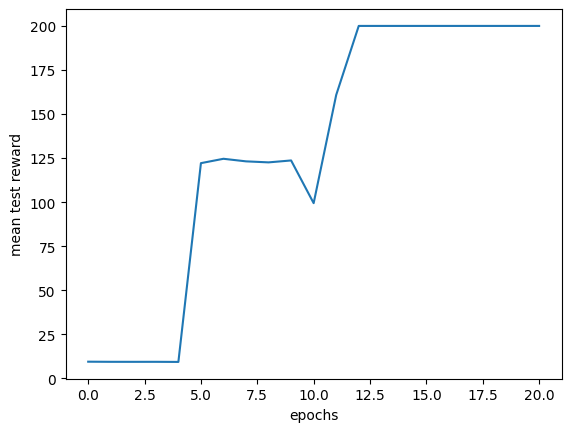

best_res_idx  0   200.0
[4, 6, 6, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 27.0
0  success percent   0.0  mean reward  12.75
Best rewards so far: 28.0
Best rewards so far: 47.0
Best rewards so far: 69.0
Best rewards so far: 83.0
Best rewards so far: 101.0
0  success percent   0.0  mean reward  11.93
Best rewards so far: 126.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.91
0  success percent   0.0  mean reward  9.9
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.76
0  success percent   0.0  mean reward  10.02
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.79
0  success percent   0.0  mean reward  9.89
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.85
0  success percent   0.0  mean reward  9.93
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.87
0  success percen

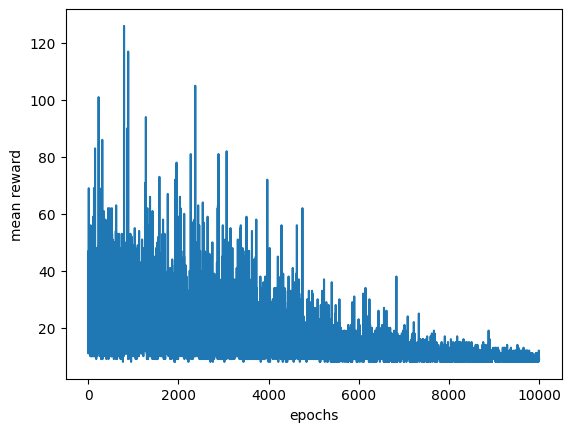

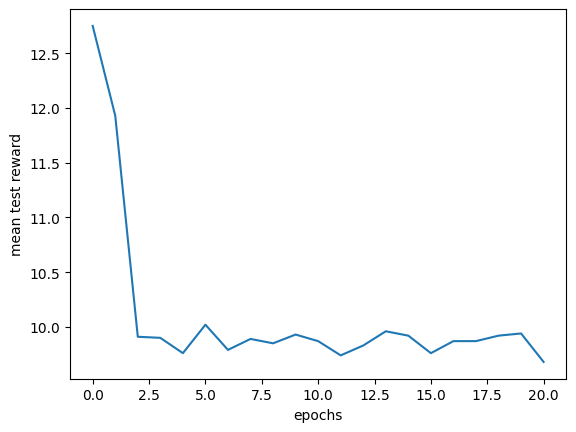

best_res_idx  0   9.8
TIME:  0.8129302938779195  min

HIDDEN SIZE:  4 3
Best rewards so far: 15.0
0  success percent   0.0  mean reward  10.0
Best rewards so far: 19.0
Best rewards so far: 23.0
Best rewards so far: 58.0
Best rewards so far: 104.0
0  success percent   0.0  mean reward  9.29
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.26
0  success percent   0.0  mean reward  9.28
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.39
Best rewards so far: 112.0
0  success percent   0.0  mean reward  18.85
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  17.63
Best rewards so far: 118.0
0  success percent   100.0  mean reward  200.0
Episode 4000 Epsilon 0.600300000000044
0  success percent   100.0  mean reward  200.0
0  success percent   100.0  mean reward  200.0
Episode 5000 Epsilon 0.500300000000055
0  success percent   100.0  mean reward  200.0
Best rewards so far: 189.0
Best rewards so far: 30

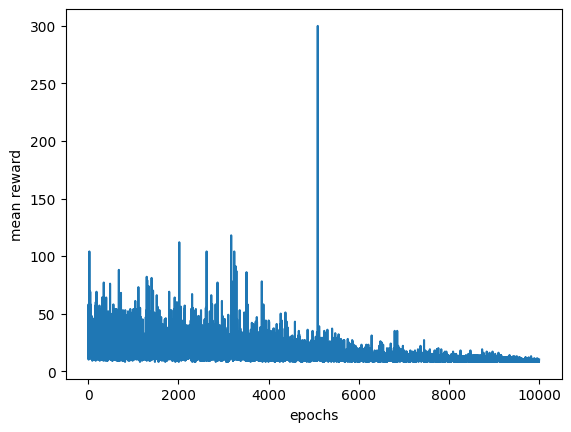

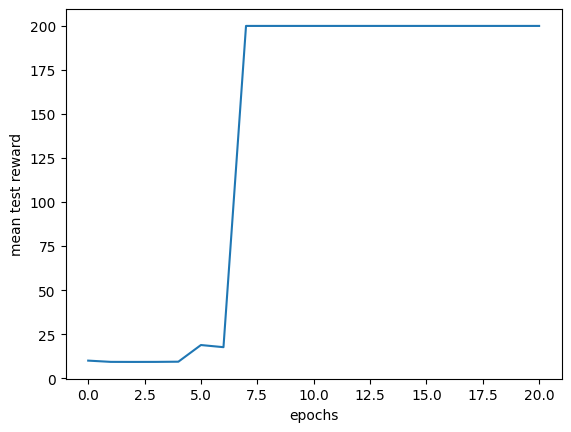

best_res_idx  0   200.0
[4, 4, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 11.0
0  success percent   0.0  mean reward  9.37
Best rewards so far: 29.0
Best rewards so far: 30.0
Best rewards so far: 31.0
Best rewards so far: 44.0
Best rewards so far: 64.0
Best rewards so far: 87.0
0  success percent   0.0  mean reward  14.02
Best rewards so far: 92.0
Best rewards so far: 93.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.36
Best rewards so far: 104.0
0  success percent   0.0  mean reward  9.27
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.39
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.38
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.48
Best rewards so far: 125.0
0  success percent   76.0  mean reward  1

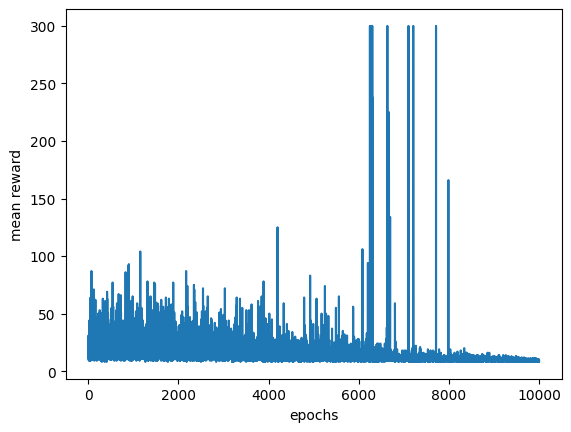

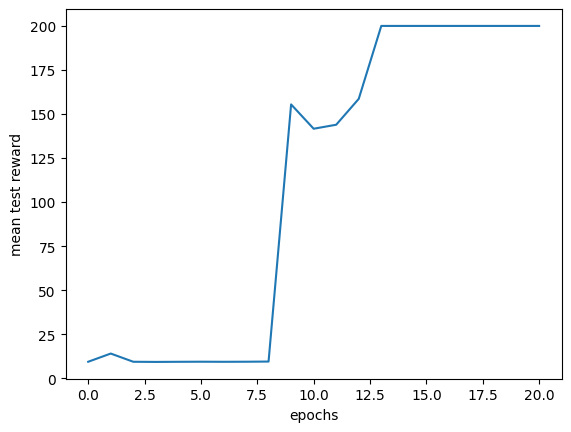

best_res_idx  0   200.0
[4, 3, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 9.0
0  success percent   0.0  mean reward  9.42
Best rewards so far: 25.0
Best rewards so far: 37.0
Best rewards so far: 39.0
Best rewards so far: 50.0
Best rewards so far: 78.0
0  success percent   0.0  mean reward  9.34
Best rewards so far: 93.0
Best rewards so far: 100.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.46
0  success percent   0.0  mean reward  9.39
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.41
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.45
0  success percent   0.0  mean reward  9.43
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.46
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9

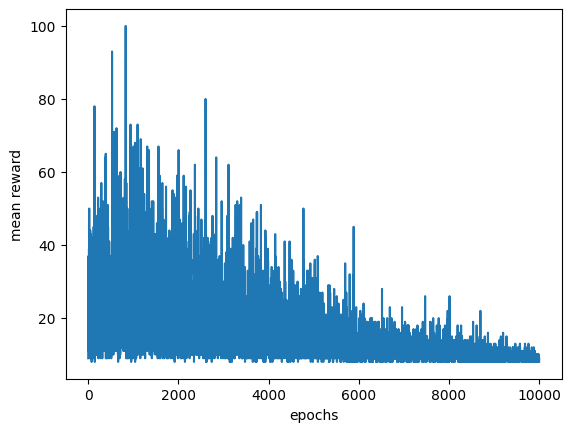

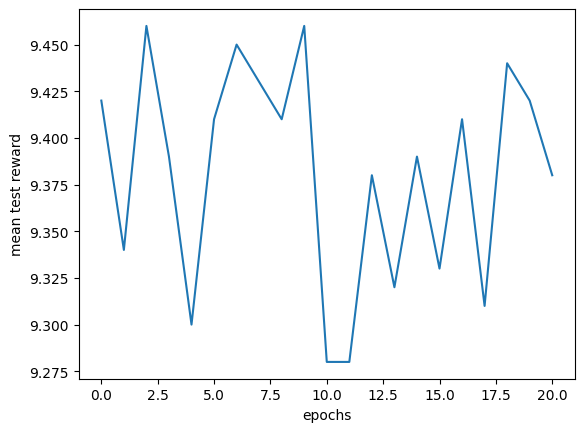

best_res_idx  0   9.35
TIME:  0.8164839426676432  min

HIDDEN SIZE:  4 3
Best rewards so far: 20.0
0  success percent   0.0  mean reward  9.31
Best rewards so far: 28.0
Best rewards so far: 31.0
Best rewards so far: 46.0
Best rewards so far: 52.0
Best rewards so far: 57.0
Best rewards so far: 58.0
Best rewards so far: 72.0
Best rewards so far: 73.0
0  success percent   0.0  mean reward  9.57
Best rewards so far: 86.0
Best rewards so far: 89.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.4
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.28
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.17
0  success percent   0.0  mean reward  9.49
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.39
Best rewards so far: 105.0
0  success percent   30.0  mean reward  68.18
Episode 5000 Epsi

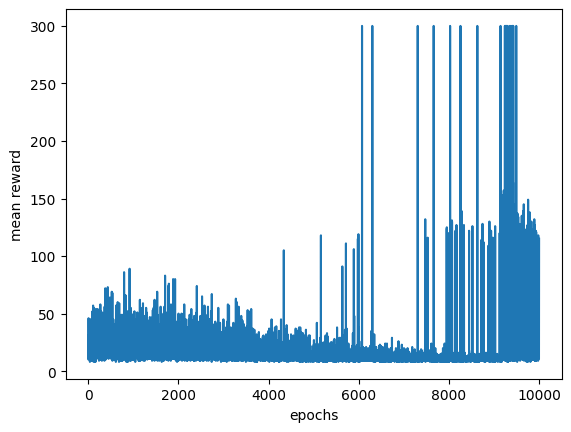

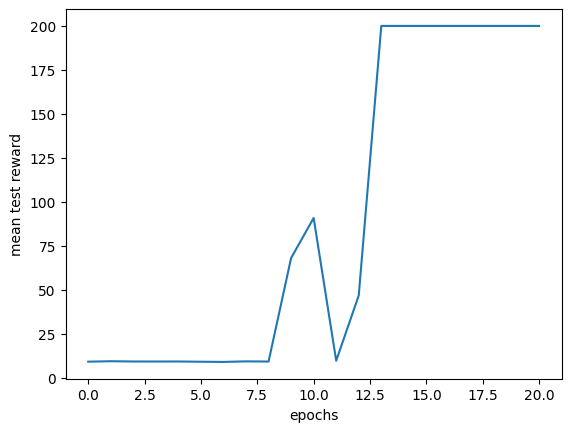

best_res_idx  0   200.0
[4, 4, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 24.0
0  success percent   0.0  mean reward  9.34
Best rewards so far: 33.0
Best rewards so far: 39.0
Best rewards so far: 48.0
Best rewards so far: 54.0
Best rewards so far: 77.0
Best rewards so far: 94.0
0  success percent   0.0  mean reward  9.36
Best rewards so far: 116.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   100.0  mean reward  200.0
0  success percent   100.0  mean reward  200.0
Episode 2000 Epsilon 0.800200000000022
0  success percent   100.0  mean reward  200.0
0  success percent   100.0  mean reward  200.0
Episode 3000 Epsilon 0.700200000000033
0  success percent   100.0  mean reward  200.0
0  success percent   100.0  mean reward  200.0
Episode 4000 Epsilon 0.600200000000044
0  success percent   100.0  mean reward  200.0
0  success percent   100.0  mean reward  200.0
Episode 5000 Epsilon 0.500200000000055
0  success per

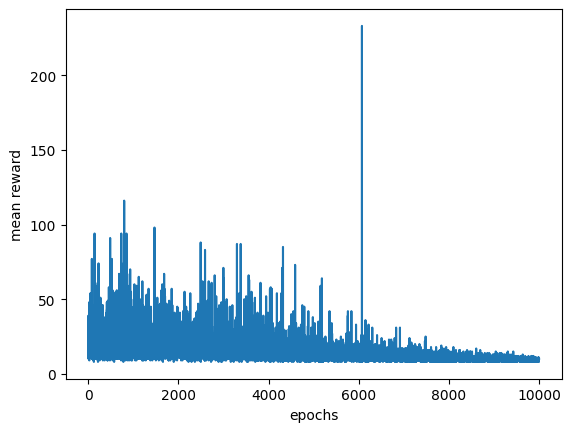

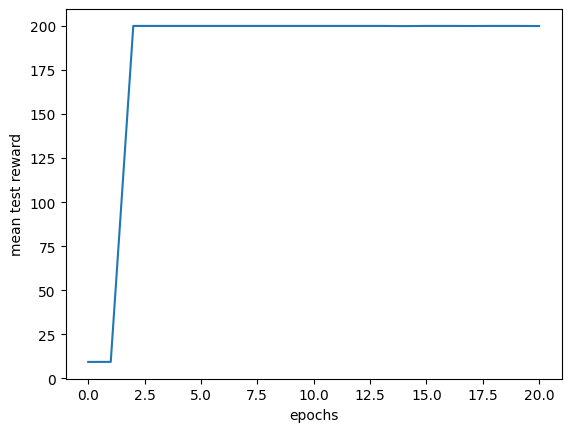

best_res_idx  0   200.0
[4, 3, 3, 2] Good found---------------------------------------------------
TOTAL TIME:  39.07430145740509  min


In [17]:
roll = '113'
learning_rate_a = 0.1
game_name = "CartPole-v0"
env = gym.make(game_name)
in_states = env.observation_space.shape[0]
out_actions = env.action_space.n
env.close()
a_types = [ '', 'ReLU', 'ReLU', 'Linear']

num_of_nn = 1

        
episodes = 10000

total_time_start = time.time()
n_tests = 10
TSR = 95

for test in range(n_tests):

    best_SR = 0
    
    loop_cnt = 8
    
    tmp_idx = 0
    t1 = 3
    t2 = 3
    
    optimizer_ = 'Adam'
    for y in range(loop_cnt):
        
        this_time_start = time.time()
        
        print('\nHIDDEN SIZE: ', t1, t2)
        
        h1_nodes = t1
        h2_nodes = t2
        
        dqn_s = []
        
        ct = datetime.datetime.now()
        ct = str(ct)
        ct = ct.replace(":", "-")
        ct = ct.replace(" ", "_")
        ct = ct[:-7]
        ct = roll + '/' + ct + '_' + str(t1)+'_'+str(t2)
        
        # preset models
        for i in range(num_of_nn):
            policy_dqn = plastic_nn(optimizer=optimizer_)
            
    
            topology = [in_states, h1_nodes, h2_nodes,  out_actions]
            dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 1)
            dqn_test.set_tag(str(i))
            dqn_test.save_info(f'lr: {learning_rate_a} \n{topology} \na:{a_types}\n')
            
            dqn_s.append(dqn_test)
            
            if (y == 0):
                layers_net = [input_layer(in_states), 
                layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_types[1]), 
                layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_types[2]), 
                layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_types[3])]
                
                policy_dqn.append_layers(layers_net)
            else:
                policy_dqn = next_load_policy
            policy_dqn.optimizer_reset()
            dqn_s[i].init_train_data(policy_dqn, episodes)
        
        # for i in range(num_of_nn):
        #     dqn_s[i].policy_dqn.print_info()    
        
        summs = np.zeros(shape = episodes+1)
        tests = np.zeros(shape = int(episodes/500) + 1)
        
        
        for e in range(episodes + 1):
            for i in range (num_of_nn):  
                summs[e] += dqn_s[i].run_one_epoch(e)
                if (e % 500 == 0):
                    test_dqn_ = plastic_nn(optimizer=optimizer_)
                    test_dqn_.load(f'{dqn_s[i].path}/mc_policy_best')
                    succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn_, episodes = 100)
                    print(i,' success percent  ', succ_perc, ' mean reward ', mean_reward)
                    tests[int(e/500)] += mean_reward
    
        # for i in range(num_of_nn):
        #     dqn_s[i].policy_dqn.print_info()

        # TESTING
        best_test_result = -1
        best_res_idx = -1
        
        for i in range (num_of_nn):
            test_dqn = plastic_nn(optimizer=optimizer_)
            test_dqn.load(f'{dqn_s[i].path}/mc_policy_best')
            succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn, episodes = 100)
            if (mean_reward > best_test_result):
                best_test_result = mean_reward
                best_res_idx = i
    
                if (succ_perc > best_SR):
                    best_SR = succ_perc
                
            print('final: success percent  ', succ_perc, ' mean reward ', mean_reward)
            dqn_s[i].post_train()
        
       
    
        mean_results = np.asarray(summs) / num_of_nn
        show_plot('epochs', 'mean reward', mean_results, f'{dqn_s[0].ct}/mean_values.png')
    
        mean_test_reward = np.asarray(tests) / num_of_nn
        show_plot('epochs', 'mean test reward', mean_test_reward, f'{dqn_s[0].ct}/mean_test_reward.png')
           
        print('best_res_idx ', best_res_idx, ' ', best_test_result)
        
        if (best_SR > TSR):
            print(topology, 'Good found---------------------------------------------------')
            break
            
        
    
        next_load_policy = plastic_nn(optimizer=optimizer_)
        next_load_policy.load(f'{dqn_s[best_res_idx].path}/mc_policy_best')
    
        next_load_policy.add_neuron(layer_number = (y%2)+1, n_of_neurons = 1, value = 'r')
        #next_load_policy.add_neuron(layer_number = 1, n_of_neurons = 2, value = 'r')
        #next_load_policy.add_neuron(layer_number = 2, n_of_neurons = 2, value = 'r')
        
        if (y%2 == 0):
            t1 += 1
        else:
            t2 += 1
            
        this_time_end = time.time()
        this_time_diff = this_time_end - this_time_start
        print('TIME: ', this_time_diff/60, ' min')
        
    
    
total_time_end = time.time()
total_time_diff = total_time_end - total_time_start
print('TOTAL TIME: ', total_time_diff/60, ' min')


HIDDEN SIZE:  3 3
Best rewards so far: 15.0
0  success percent   0.0  mean reward  9.3
Best rewards so far: 26.0
Best rewards so far: 28.0
Best rewards so far: 32.0
Best rewards so far: 46.0
Best rewards so far: 47.0
Best rewards so far: 56.0
Best rewards so far: 71.0
Best rewards so far: 80.0
Best rewards so far: 81.0
Best rewards so far: 86.0
0  success percent   0.0  mean reward  9.24
Best rewards so far: 101.0
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.47
0  success percent   0.0  mean reward  9.45
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.18
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  9.48
0  success percent   0.0  mean reward  9.39
Episode 4000 Epsilon 0.600400000000044
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.44
Episode 5000 Epsilon 0.500400000000055
0  success percent   0.0  mean rew

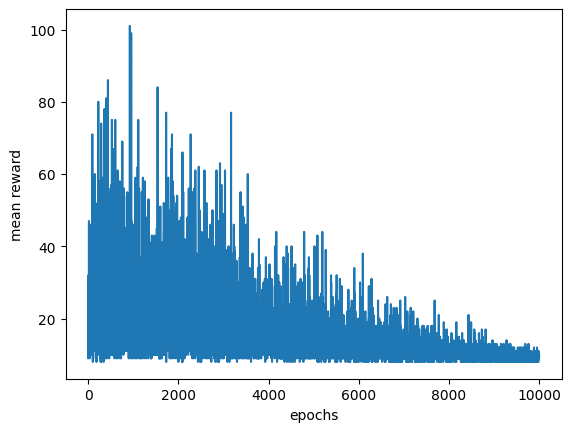

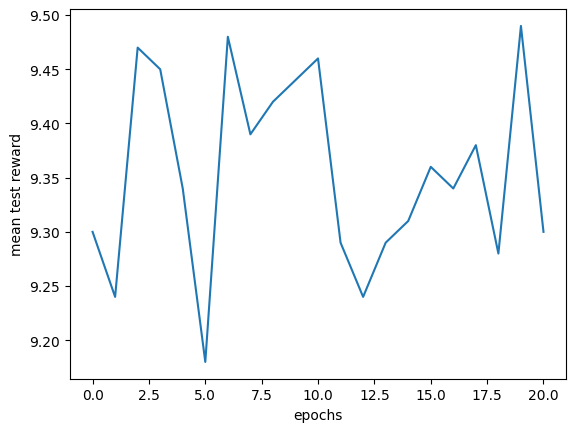

best_res_idx  0   9.41
TIME:  0.7679248690605164  min

HIDDEN SIZE:  4 3
Best rewards so far: 15.0
0  success percent   0.0  mean reward  9.39
Best rewards so far: 39.0
Best rewards so far: 57.0
Best rewards so far: 60.0
Best rewards so far: 72.0
Best rewards so far: 75.0
Best rewards so far: 82.0
0  success percent   0.0  mean reward  9.25
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.46
0  success percent   0.0  mean reward  9.41
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.34
Best rewards so far: 88.0
0  success percent   0.0  mean reward  9.35
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.38
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.49
0  success percent   0.0  mean reward  9.25
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.

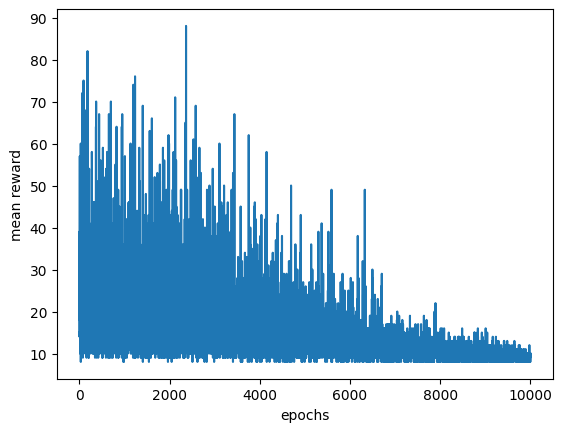

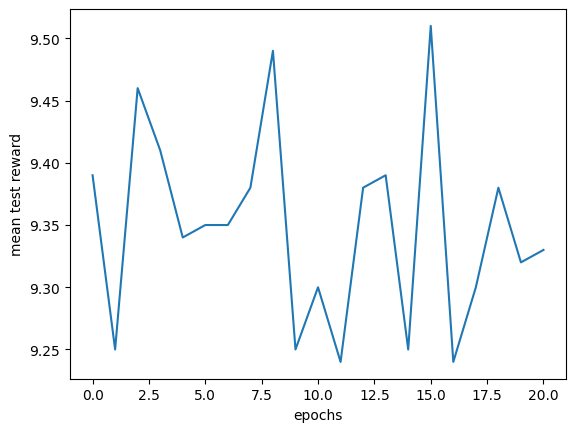

best_res_idx  0   9.31
TIME:  0.7446306149164835  min

HIDDEN SIZE:  4 4
Best rewards so far: 14.0
0  success percent   0.0  mean reward  9.29
Best rewards so far: 35.0
Best rewards so far: 44.0
Best rewards so far: 45.0
Best rewards so far: 85.0
0  success percent   0.0  mean reward  9.29
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.36
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.33
Best rewards so far: 97.0
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.4
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.29
0  success percent   0.0  mean reward  9.35
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.34
Episode 6000 Epsilon 0.40020000000006606
0  succe

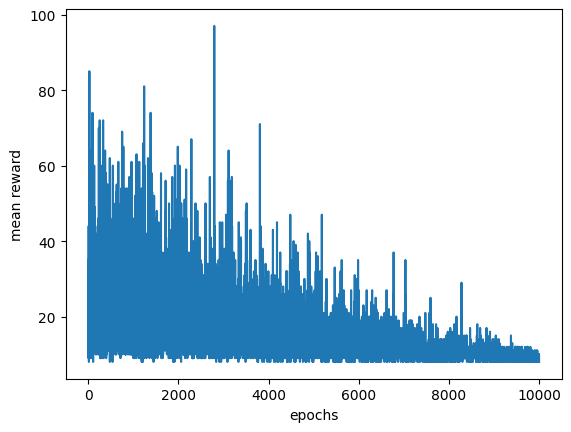

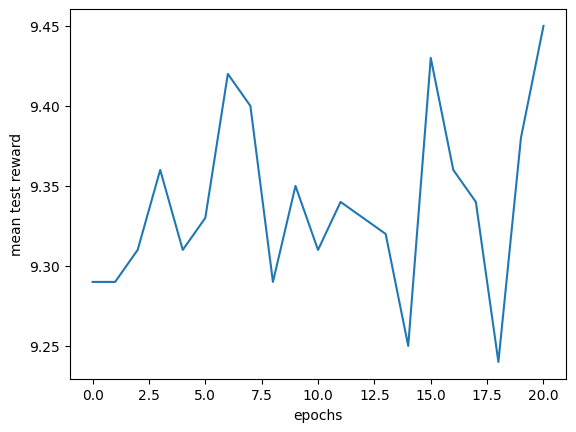

best_res_idx  0   9.26
TIME:  0.7147125562032064  min

HIDDEN SIZE:  5 4
Best rewards so far: 44.0
0  success percent   0.0  mean reward  9.45
Best rewards so far: 56.0
Best rewards so far: 59.0
Best rewards so far: 82.0
Best rewards so far: 85.0
0  success percent   0.0  mean reward  9.25
Best rewards so far: 99.0
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.37
Episode 2000 Epsilon 0.800100000000022
0  success percent   0.0  mean reward  9.49
0  success percent   0.0  mean reward  9.33
Episode 3000 Epsilon 0.700100000000033
0  success percent   0.0  mean reward  9.26
0  success percent   0.0  mean reward  9.34
Episode 4000 Epsilon 0.600100000000044
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.38
Episode 5000 Epsilon 0.5001000000000551
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.39
Episode 6000 Epsilon 0.40010000000006607
0  suc

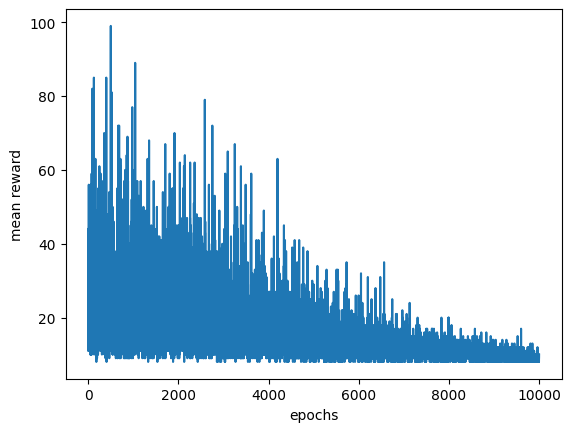

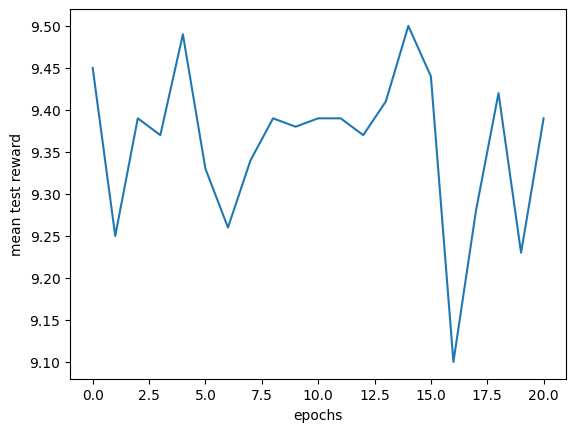

best_res_idx  0   9.27
TIME:  0.7227758447329203  min

HIDDEN SIZE:  5 5
Best rewards so far: 11.0
0  success percent   0.0  mean reward  9.37
Best rewards so far: 26.0
Best rewards so far: 29.0
Best rewards so far: 63.0
Best rewards so far: 104.0
0  success percent   0.0  mean reward  9.3
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.28
Best rewards so far: 113.0
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.3
Best rewards so far: 116.0
0  success percent   0.0  mean reward  71.02
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  68.32
0  success percent   0.0  mean reward  75.86
Best rewards so far: 158.0
Episode 4000 Epsilon 0.600300000000044
0  success percent   100.0  mean reward  200.0
0  success percent   100.0  mean reward  200.0
Best rewards so far: 169.0
Best rewards so far: 185.0
Best rewards so far: 203.0
Episode 5000 Epsilon 0.50030000

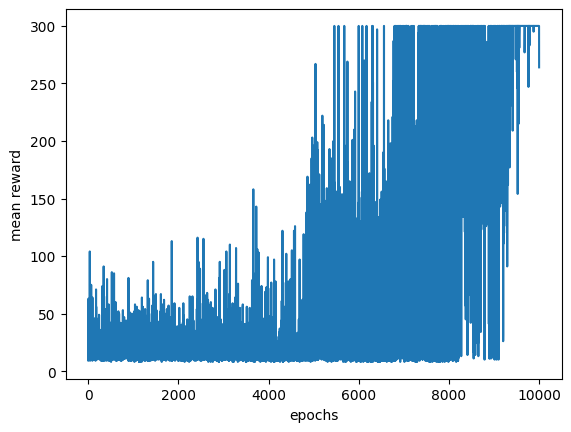

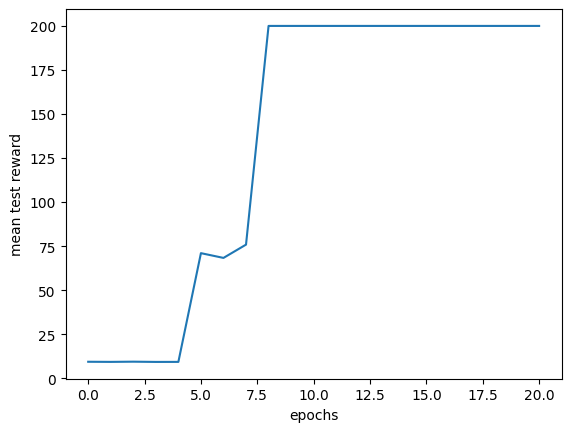

best_res_idx  0   200.0
[4, 5, 5, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 15.0
0  success percent   0.0  mean reward  9.25
Best rewards so far: 16.0
Best rewards so far: 38.0
Best rewards so far: 50.0
Best rewards so far: 59.0
Best rewards so far: 61.0
Best rewards so far: 94.0
0  success percent   0.0  mean reward  9.49
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.27
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.36
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.38
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.47
Best rewards so far: 104.0
Episode 5000 Epsilon 0.500300000000055
0  success percent   100.0  mean reward 

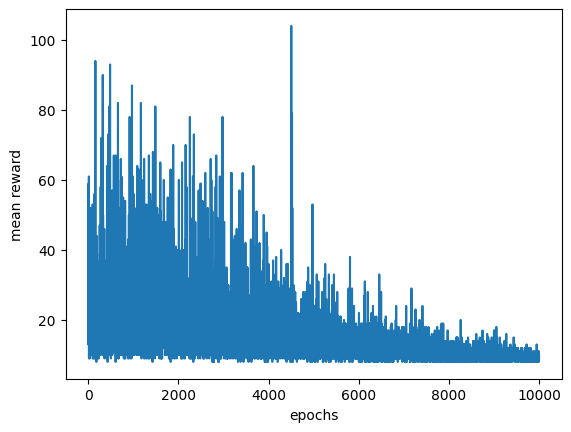

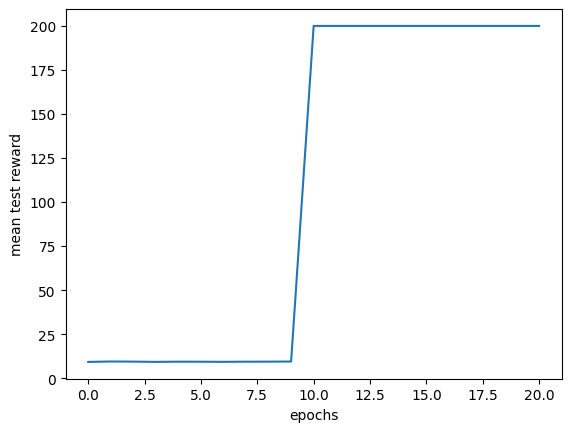

best_res_idx  0   200.0
[4, 3, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 50.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 73.0
Best rewards so far: 88.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 93.0
Best rewards so far: 100.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.32
Best rewards so far: 123.0
0  success percent   0.0  mean reward  9.46
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.5
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.27
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.41
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.35
Ep

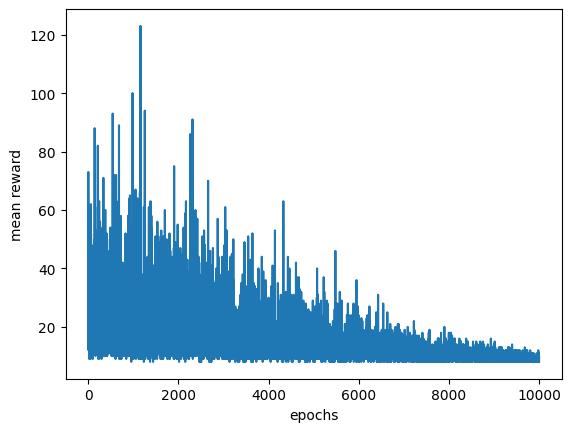

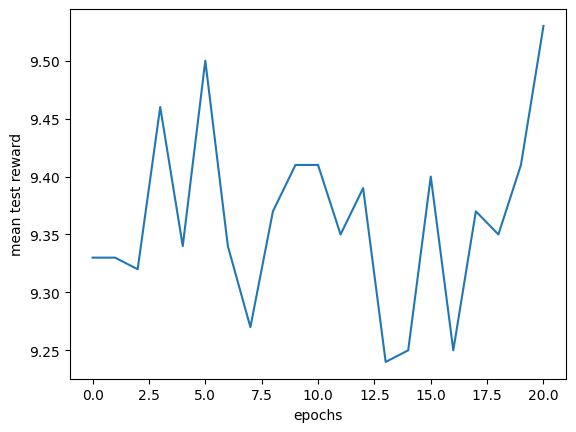

best_res_idx  0   9.16
TIME:  0.7233871062596638  min

HIDDEN SIZE:  4 3
Best rewards so far: 24.0
0  success percent   0.0  mean reward  9.4
Best rewards so far: 38.0
Best rewards so far: 68.0
0  success percent   0.0  mean reward  9.32
Best rewards so far: 97.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.32
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.26
0  success percent   0.0  mean reward  9.37
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.29
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.36
Best rewards so far: 99.0
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  37.32
0  success percent   0.0  mean reward  36.9
Best rewards so far: 112.0
Best rewards so far: 113.0
Episode 6000 Epsilon

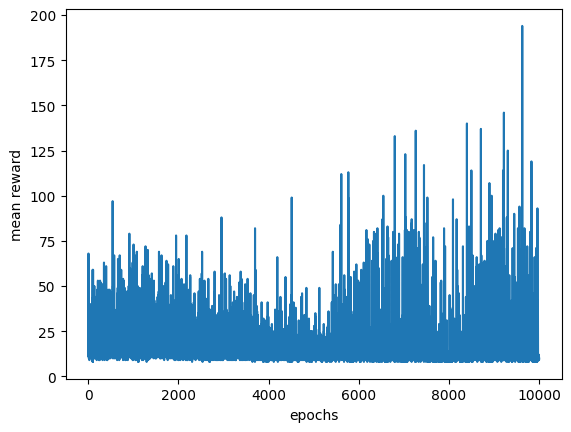

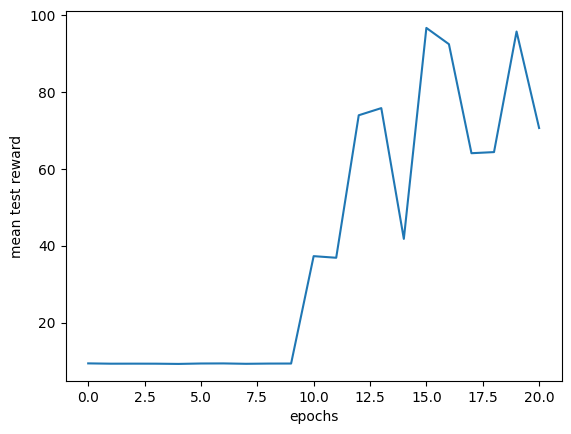

best_res_idx  0   69.14
TIME:  0.7826423724492391  min

HIDDEN SIZE:  4 4
Best rewards so far: 29.0
0  success percent   0.0  mean reward  71.19
Best rewards so far: 90.0
Best rewards so far: 120.0
0  success percent   0.0  mean reward  73.23
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  75.15
0  success percent   0.0  mean reward  71.08
Best rewards so far: 124.0
Episode 2000 Epsilon 0.800100000000022
0  success percent   0.0  mean reward  80.28
Best rewards so far: 139.0
0  success percent   3.0  mean reward  112.54
Best rewards so far: 157.0
Episode 3000 Epsilon 0.700100000000033
0  success percent   2.0  mean reward  111.12
Best rewards so far: 189.0
0  success percent   0.0  mean reward  112.95
Episode 4000 Epsilon 0.600100000000044
0  success percent   3.0  mean reward  115.29
Best rewards so far: 225.0
0  success percent   3.0  mean reward  126.12
Episode 5000 Epsilon 0.5001000000000551
0  success percent   5.0  mean reward  128.41
0  success perc

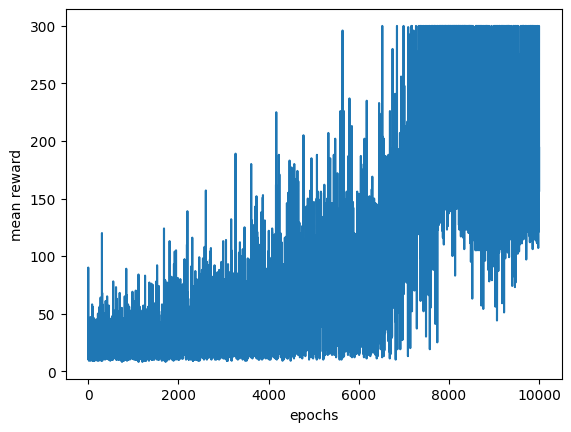

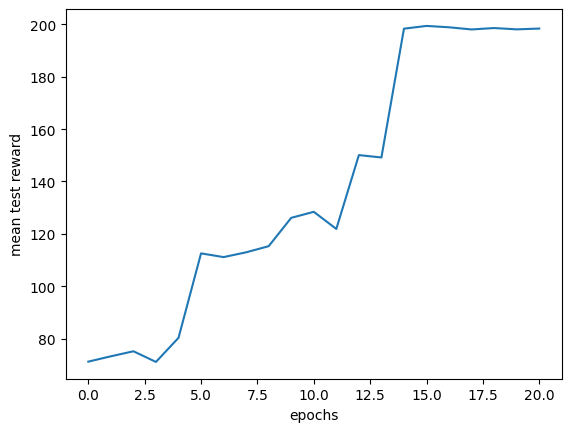

best_res_idx  0   198.86
TIME:  1.2451642235120137  min

HIDDEN SIZE:  5 4
Best rewards so far: 11.0
0  success percent   33.0  mean reward  181.73
Best rewards so far: 25.0
Best rewards so far: 28.0
Best rewards so far: 57.0
Best rewards so far: 60.0
Best rewards so far: 81.0
Best rewards so far: 82.0
0  success percent   96.0  mean reward  199.55
Best rewards so far: 113.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  151.5
Best rewards so far: 147.0
0  success percent   70.0  mean reward  196.17
Best rewards so far: 173.0
Episode 2000 Epsilon 0.800300000000022
0  success percent   1.0  mean reward  174.1
Best rewards so far: 198.0
0  success percent   100.0  mean reward  200.0
Best rewards so far: 246.0
Episode 3000 Epsilon 0.700300000000033
0  success percent   81.0  mean reward  196.87
0  success percent   84.0  mean reward  198.23
Episode 4000 Epsilon 0.600300000000044
0  success percent   79.0  mean reward  196.98
Best rewards so far: 264.0
Best r

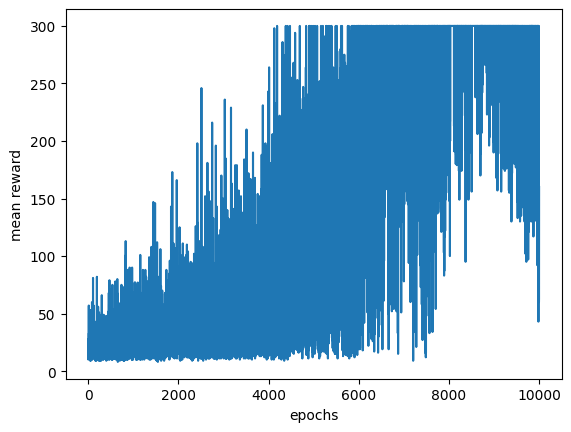

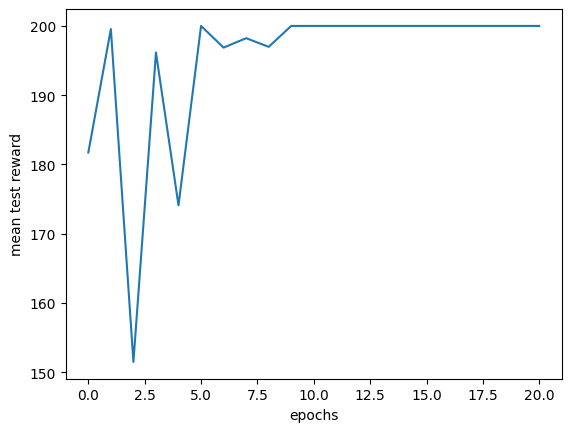

best_res_idx  0   200.0
[4, 5, 4, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 21.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 24.0
Best rewards so far: 26.0
Best rewards so far: 42.0
Best rewards so far: 46.0
Best rewards so far: 76.0
Best rewards so far: 78.0
0  success percent   0.0  mean reward  9.38
Best rewards so far: 87.0
Best rewards so far: 92.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.46
0  success percent   0.0  mean reward  9.28
Best rewards so far: 100.0
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.36
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.35
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.32
Episode 5000 Epsilon 0.50

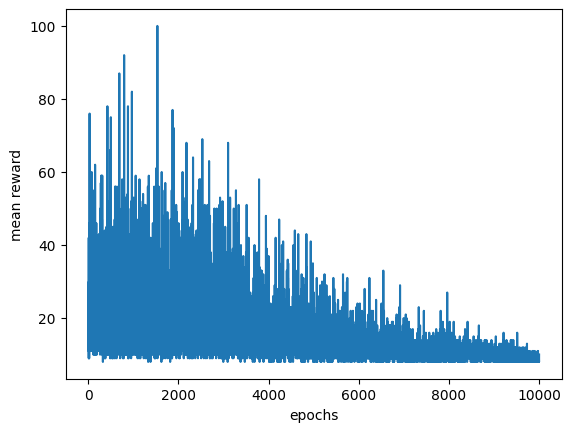

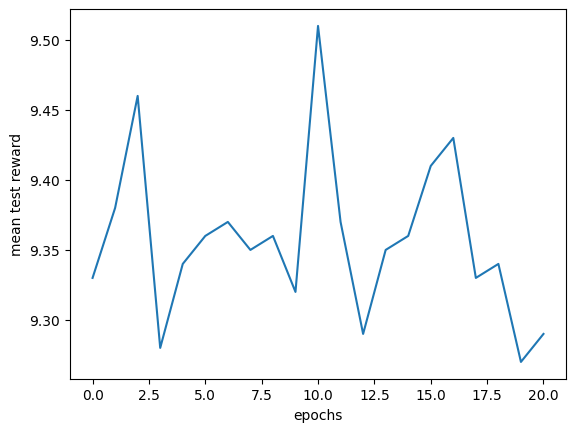

best_res_idx  0   9.28
TIME:  0.725861418247223  min

HIDDEN SIZE:  4 3
Best rewards so far: 20.0
0  success percent   0.0  mean reward  9.26
Best rewards so far: 25.0
Best rewards so far: 51.0
Best rewards so far: 88.0
0  success percent   0.0  mean reward  9.28
Best rewards so far: 89.0
Best rewards so far: 110.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.28
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.37
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.32
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.53
0  success percent   0.0  mean reward  9.28
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.25
0  success percent   0.0  mean reward  9.28
Episode 6000 Epsilon 0.40030000000006605
0  succe

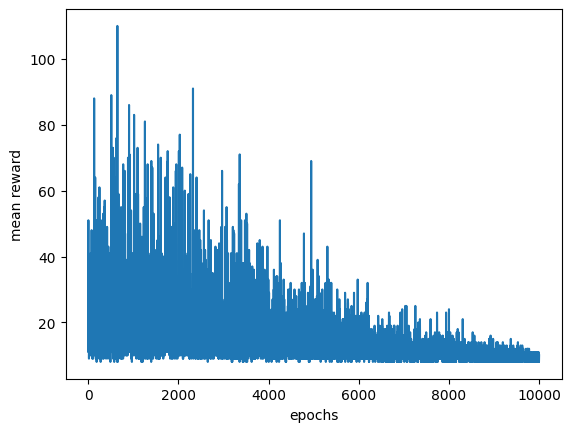

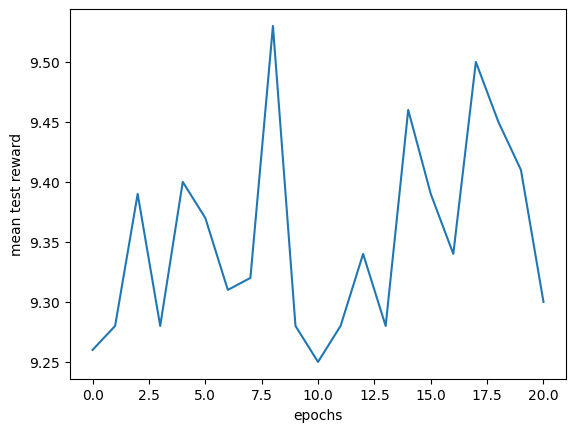

best_res_idx  0   9.39
TIME:  0.7120359381039937  min

HIDDEN SIZE:  4 4
Best rewards so far: 11.0
0  success percent   0.0  mean reward  9.39
Best rewards so far: 37.0
Best rewards so far: 39.0
Best rewards so far: 62.0
Best rewards so far: 65.0
Best rewards so far: 77.0
Best rewards so far: 80.0
Best rewards so far: 90.0
0  success percent   0.0  mean reward  9.3
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.43
Best rewards so far: 97.0
0  success percent   0.0  mean reward  9.31
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.21
0  success percent   0.0  mean reward  9.43
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.35
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.32
0  success percent   0.0  mean reward  9.38
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.35
0  success perc

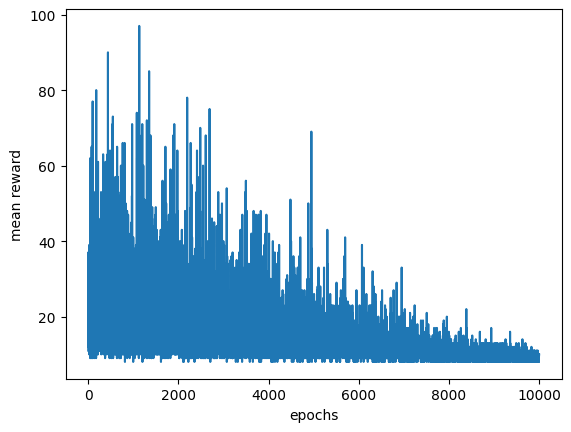

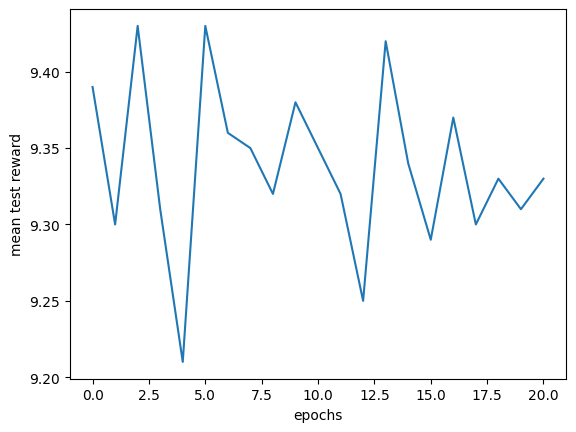

best_res_idx  0   9.29
TIME:  0.7043174386024476  min

HIDDEN SIZE:  5 4
Best rewards so far: 19.0
0  success percent   0.0  mean reward  9.29
Best rewards so far: 29.0
Best rewards so far: 89.0
0  success percent   0.0  mean reward  9.48
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.33
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.5
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.38
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.32
0  success percent   0.0  mean reward  9.37
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.28
0  success percent   0.0  mean reward  9.4
Episode 6000 Epsilon 0.40020000000006606
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.57
E

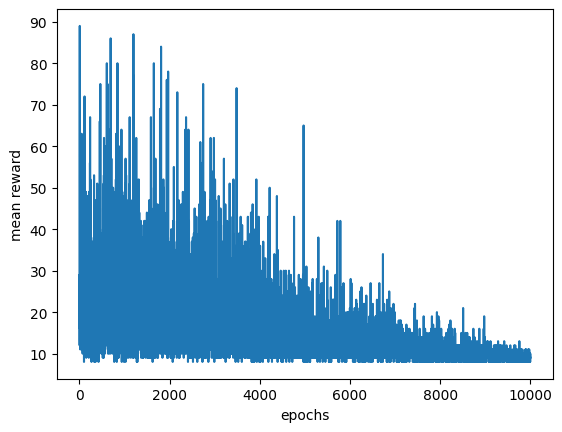

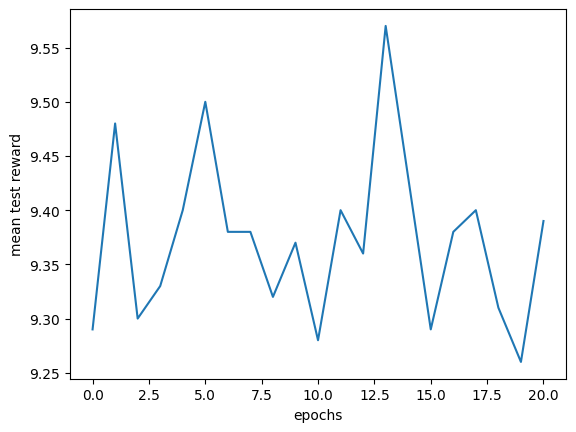

best_res_idx  0   9.28
TIME:  0.7294554074605306  min

HIDDEN SIZE:  5 5
Best rewards so far: 22.0
0  success percent   0.0  mean reward  9.26
Best rewards so far: 28.0
Best rewards so far: 63.0
Best rewards so far: 64.0
Best rewards so far: 71.0
Best rewards so far: 72.0
0  success percent   0.0  mean reward  9.27
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.41
Best rewards so far: 91.0
Best rewards so far: 100.0
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.44
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.25
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.23
0  success percent   0.0  mean reward  9.42
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9

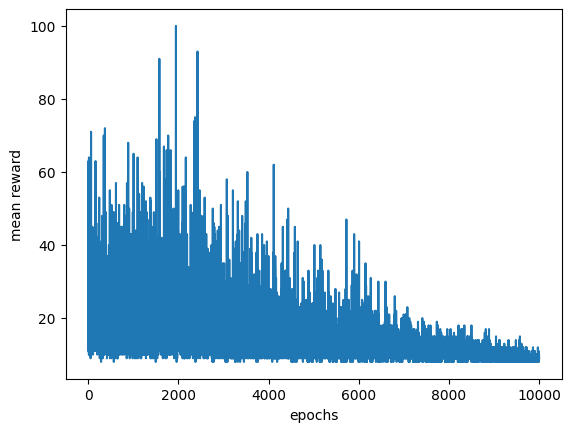

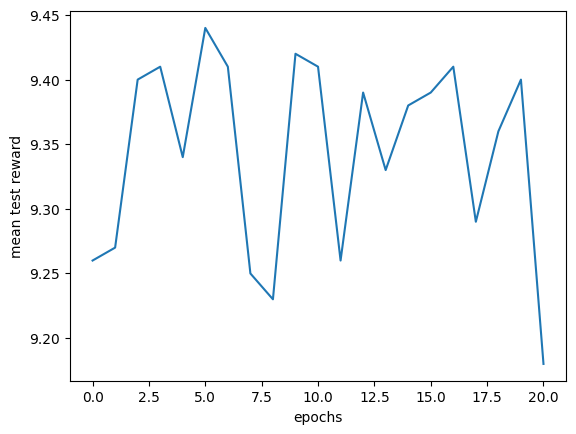

best_res_idx  0   9.38
TIME:  0.7320104519526164  min

HIDDEN SIZE:  6 5
Best rewards so far: 18.0
0  success percent   0.0  mean reward  9.49
Best rewards so far: 29.0
Best rewards so far: 31.0
Best rewards so far: 43.0
Best rewards so far: 47.0
Best rewards so far: 53.0
Best rewards so far: 64.0
Best rewards so far: 74.0
0  success percent   0.0  mean reward  9.37
Best rewards so far: 77.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.45
Best rewards so far: 80.0
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.23
0  success percent   0.0  mean reward  9.44
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.31
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.36
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean r

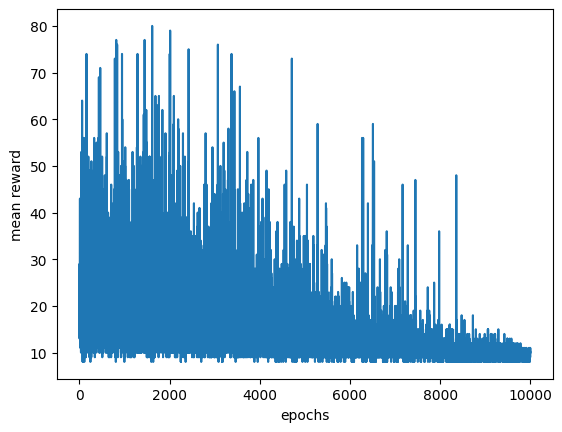

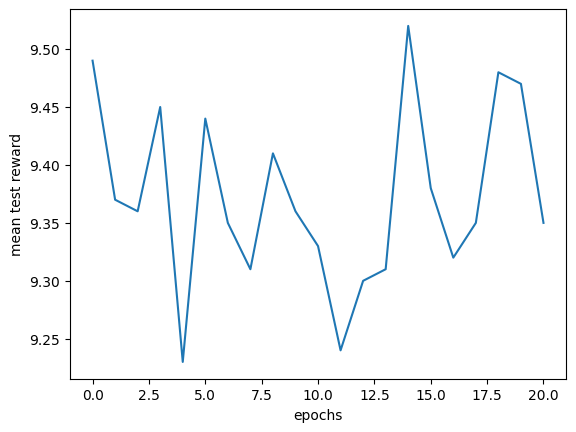

best_res_idx  0   9.36
TIME:  0.7218475540479025  min

HIDDEN SIZE:  6 6
Best rewards so far: 27.0
0  success percent   0.0  mean reward  9.47
Best rewards so far: 31.0
Best rewards so far: 37.0
Best rewards so far: 53.0
Best rewards so far: 55.0
Best rewards so far: 61.0
Best rewards so far: 78.0
Best rewards so far: 79.0
Best rewards so far: 132.0
0  success percent   0.0  mean reward  9.34
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.42
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.48
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.33
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.31
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.4
0  success per

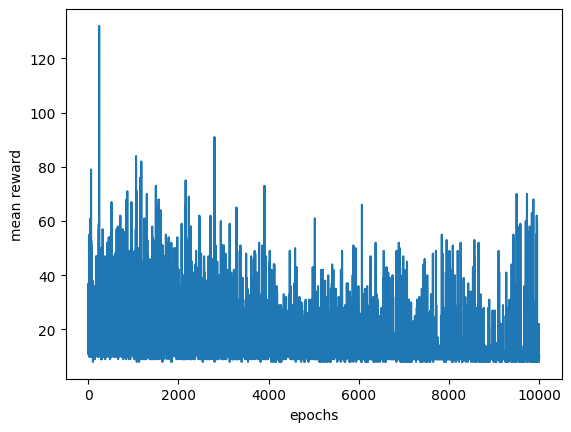

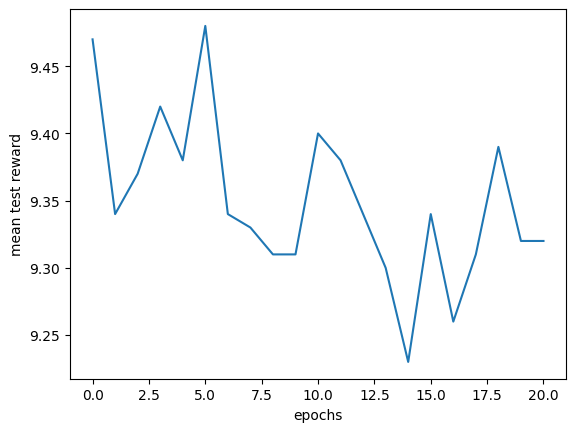

best_res_idx  0   9.44
TIME:  0.7353500604629517  min

HIDDEN SIZE:  7 6
Best rewards so far: 29.0
0  success percent   0.0  mean reward  9.34
Best rewards so far: 31.0
Best rewards so far: 36.0
Best rewards so far: 46.0
Best rewards so far: 52.0
Best rewards so far: 60.0
Best rewards so far: 79.0
0  success percent   0.0  mean reward  9.53
Best rewards so far: 96.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.26
0  success percent   0.0  mean reward  9.43
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.29
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.32
0  success percent   0.0  mean reward  9.49
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.45
0  success percent   0.0  mean reward  9.32
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9

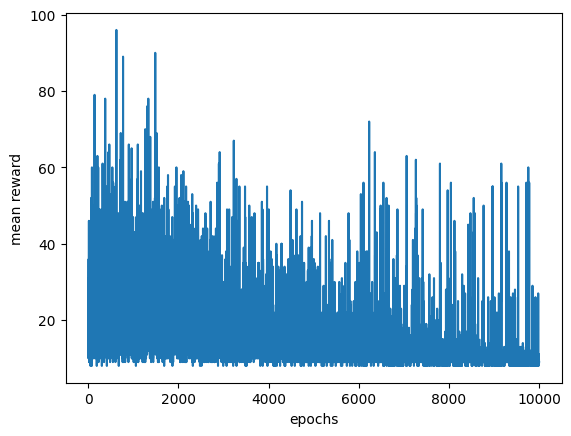

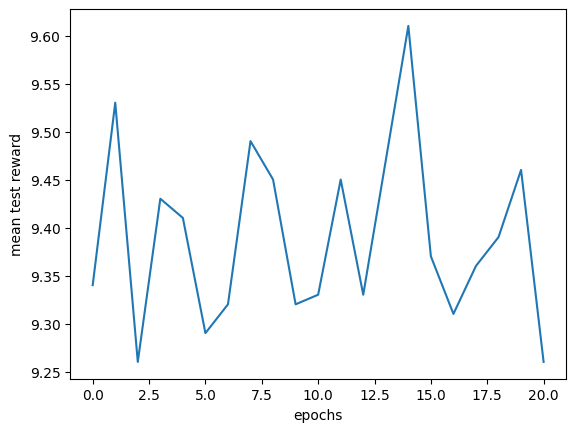

best_res_idx  0   9.48
TIME:  0.7203892827033996  min

HIDDEN SIZE:  3 3
Best rewards so far: 60.0
0  success percent   0.0  mean reward  9.35
Best rewards so far: 67.0
Best rewards so far: 73.0
Best rewards so far: 77.0
Best rewards so far: 96.0
0  success percent   0.0  mean reward  9.42
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.44
Episode 2000 Epsilon 0.800100000000022
0  success percent   0.0  mean reward  9.26
0  success percent   0.0  mean reward  9.34
Episode 3000 Epsilon 0.700100000000033
0  success percent   0.0  mean reward  9.25
0  success percent   0.0  mean reward  9.37
Episode 4000 Epsilon 0.600100000000044
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.48
Episode 5000 Epsilon 0.5001000000000551
0  success percent   0.0  mean reward  9.28
0  success percent   0.0  mean reward  9.33
Episode 6000 Epsilon 0.40010000000006607
0  success percent   0.0  mean r

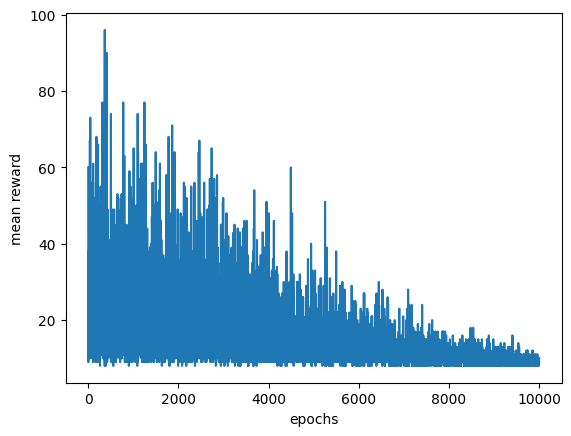

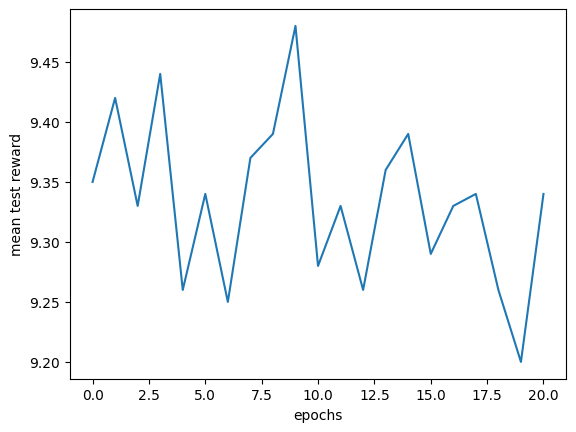

best_res_idx  0   9.34
TIME:  0.7128190040588379  min

HIDDEN SIZE:  4 3
Best rewards so far: 23.0
0  success percent   0.0  mean reward  9.46
Best rewards so far: 36.0
Best rewards so far: 75.0
Best rewards so far: 83.0
0  success percent   0.0  mean reward  9.33
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.41
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.3
Best rewards so far: 91.0
0  success percent   0.0  mean reward  9.38
Best rewards so far: 102.0
Best rewards so far: 106.0
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  73.72
Best rewards so far: 145.0
0  success percent   0.0  mean reward  156.84
Best rewards so far: 167.0
Episode 4000 Epsilon 0.600300000000044
0  success percent   100.0  mean reward  200.0
0  success percent   100.0  mean reward  200.0
Episode 5000 Epsilon 0.500300000000055
0  success percent   100.0  mean reward  200.0

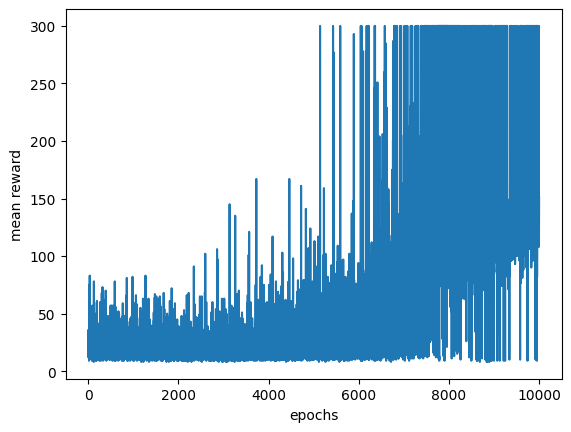

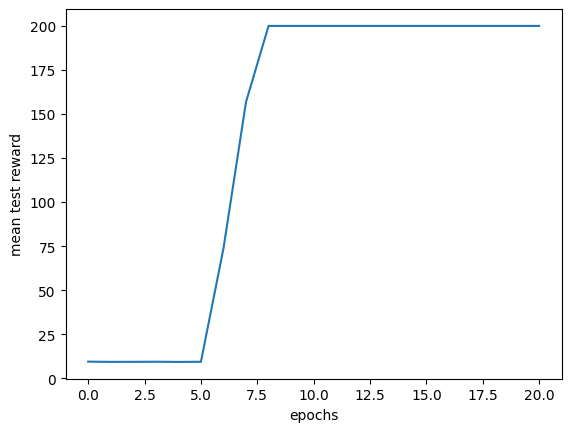

best_res_idx  0   200.0
[4, 4, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 26.0
0  success percent   0.0  mean reward  9.31
Best rewards so far: 29.0
Best rewards so far: 36.0
Best rewards so far: 59.0
Best rewards so far: 76.0
Best rewards so far: 77.0
0  success percent   0.0  mean reward  9.4
Best rewards so far: 78.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.4
Best rewards so far: 83.0
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.29
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.35
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.32
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.4

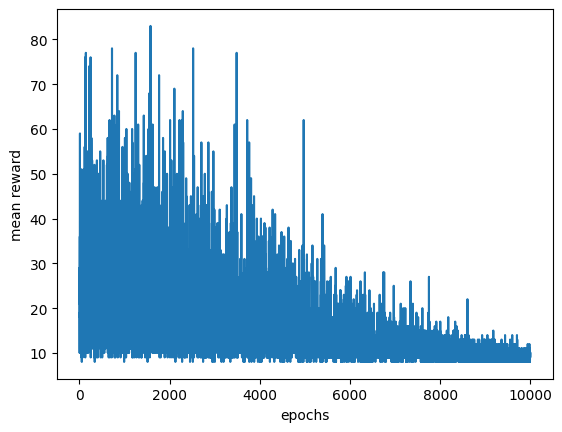

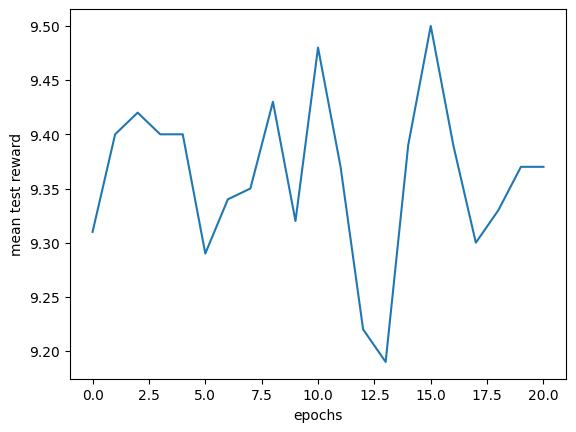

best_res_idx  0   9.26
TIME:  0.7591834584871928  min

HIDDEN SIZE:  4 3
Best rewards so far: 22.0
0  success percent   0.0  mean reward  9.24
Best rewards so far: 53.0
Best rewards so far: 76.0
Best rewards so far: 82.0
0  success percent   0.0  mean reward  9.43
Best rewards so far: 84.0
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  9.39
Best rewards so far: 100.0
0  success percent   0.0  mean reward  9.43
Episode 2000 Epsilon 0.800100000000022
0  success percent   0.0  mean reward  9.44
0  success percent   0.0  mean reward  9.35
Episode 3000 Epsilon 0.700100000000033
0  success percent   0.0  mean reward  9.28
0  success percent   0.0  mean reward  9.23
Episode 4000 Epsilon 0.600100000000044
0  success percent   0.0  mean reward  9.49
0  success percent   0.0  mean reward  9.3
Episode 5000 Epsilon 0.5001000000000551
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.51
Episode 6000 Epsilon 0.40010000000006607
0  suc

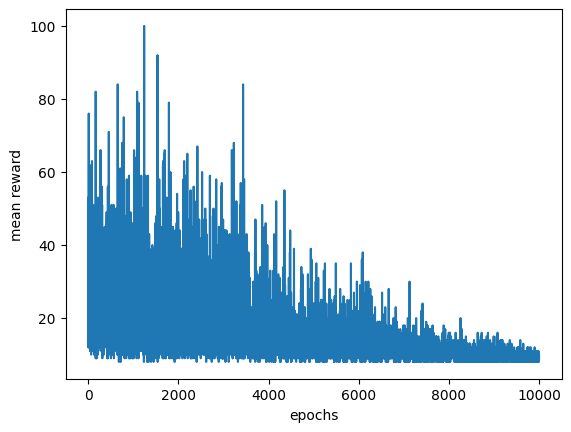

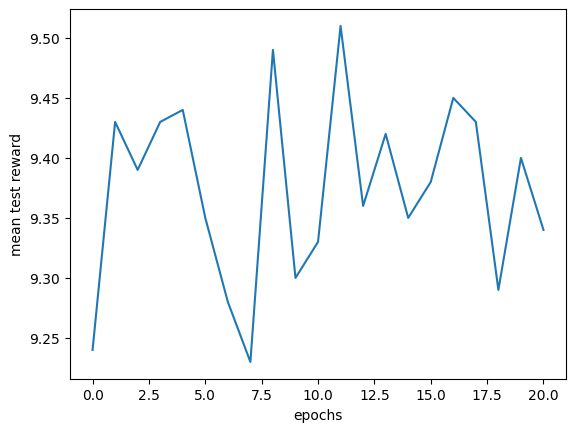

best_res_idx  0   9.34
TIME:  0.7446362813313802  min

HIDDEN SIZE:  4 4
Best rewards so far: 13.0
0  success percent   0.0  mean reward  9.29
Best rewards so far: 14.0
Best rewards so far: 20.0
Best rewards so far: 23.0
Best rewards so far: 31.0
Best rewards so far: 39.0
Best rewards so far: 55.0
Best rewards so far: 63.0
Best rewards so far: 68.0
Best rewards so far: 72.0
Best rewards so far: 76.0
0  success percent   0.0  mean reward  9.41
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.29
Best rewards so far: 92.0
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.26
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.48
Episode 4000 Epsilon 0.600400000000044
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.27
Episode 5000 Epsilon 

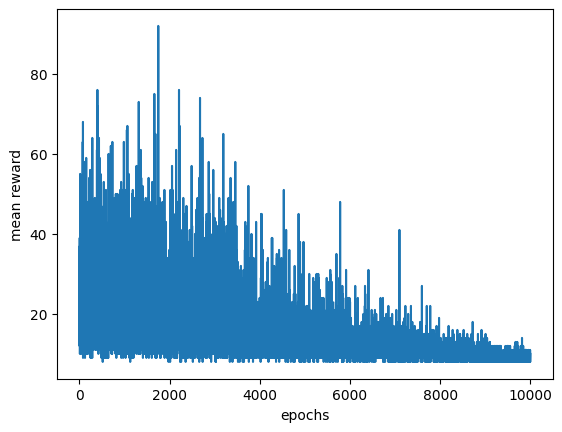

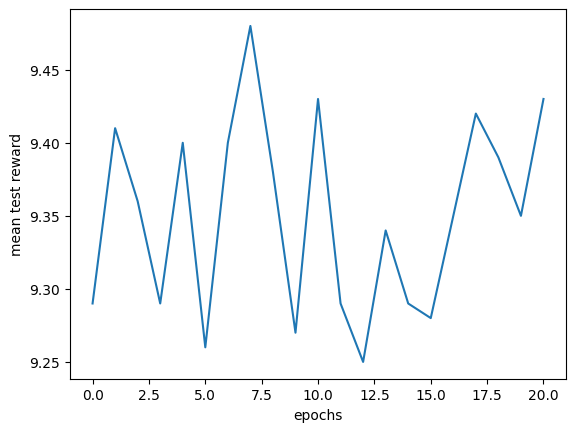

best_res_idx  0   9.31
TIME:  0.7207374970118204  min

HIDDEN SIZE:  5 4
Best rewards so far: 15.0
0  success percent   0.0  mean reward  9.47
Best rewards so far: 22.0
Best rewards so far: 24.0
Best rewards so far: 26.0
Best rewards so far: 32.0
Best rewards so far: 44.0
Best rewards so far: 59.0
Best rewards so far: 61.0
Best rewards so far: 95.0
0  success percent   0.0  mean reward  9.29
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.41
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.41
0  success percent   0.0  mean reward  9.32
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.49
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.48
0  success percent   0.0  mean reward  9.3
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.37
0  success perc

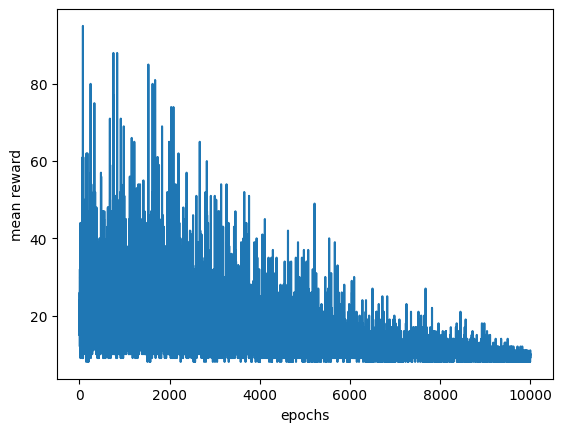

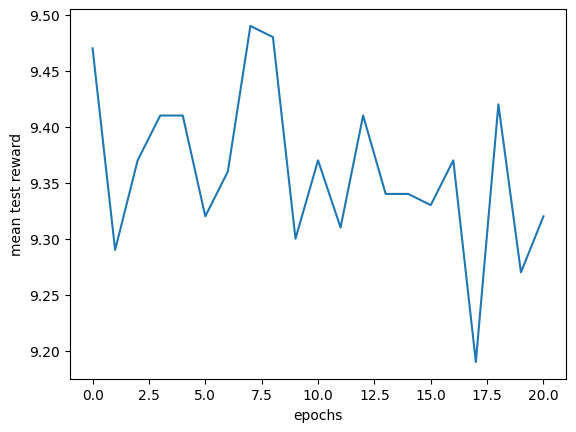

best_res_idx  0   9.33
TIME:  0.7294307152430216  min

HIDDEN SIZE:  5 5
Best rewards so far: 14.0
0  success percent   0.0  mean reward  9.34
Best rewards so far: 20.0
Best rewards so far: 99.0
0  success percent   0.0  mean reward  9.38
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.34
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.35
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.45
0  success percent   0.0  mean reward  9.28
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.44
0  success percent   0.0  mean reward  9.24
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  9.28
0  success percent   0.0  mean reward  9.37
Episode 6000 Epsilon 0.40030000000006605
0  success percent   0.0  mean reward  9.27
0  success percent   0.0  mean reward  9.3

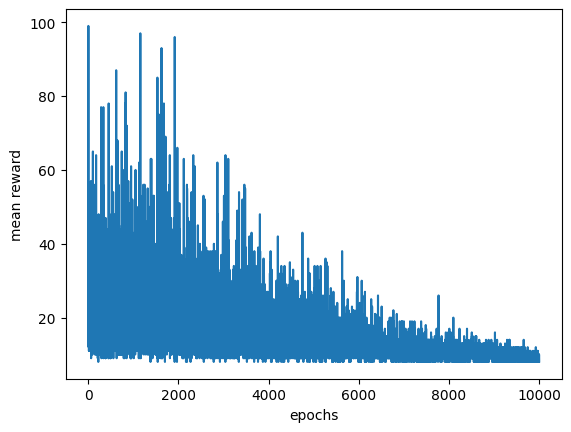

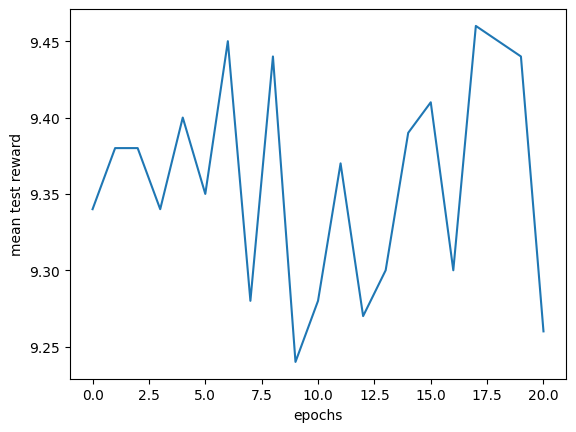

best_res_idx  0   9.29
TIME:  0.7118687232335409  min

HIDDEN SIZE:  6 5
Best rewards so far: 10.0
0  success percent   0.0  mean reward  9.37
Best rewards so far: 16.0
Best rewards so far: 17.0
Best rewards so far: 22.0
Best rewards so far: 27.0
Best rewards so far: 28.0
Best rewards so far: 49.0
Best rewards so far: 77.0
Best rewards so far: 81.0
0  success percent   0.0  mean reward  9.3
Best rewards so far: 82.0
Best rewards so far: 92.0
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.31
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  9.29
0  success percent   0.0  mean reward  9.29
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.3
Episode 4000 Epsilon 0.600400000000044
0  success percent   0.0  mean reward  9.31
0  success percent   0.0  mean reward  9.31
Episode 5000 Epsilon 0.500400000000055
0  succe

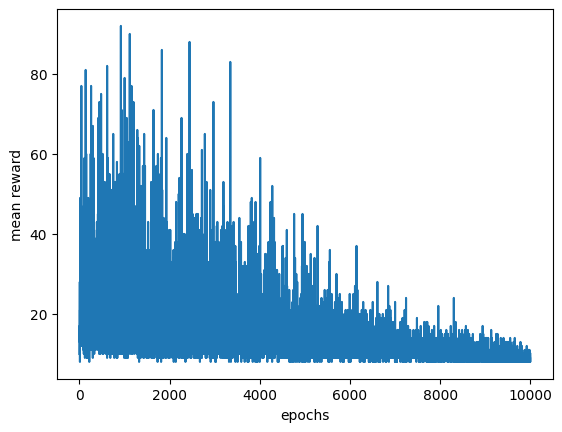

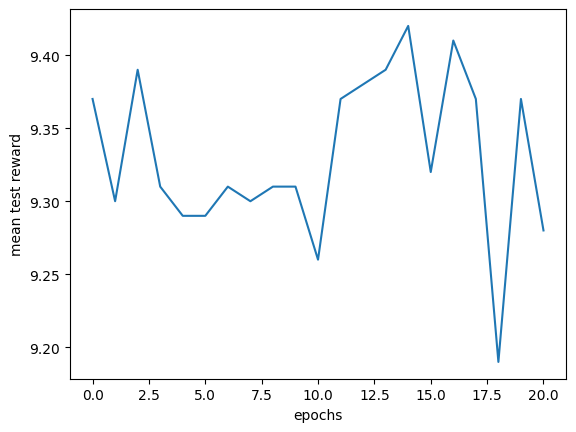

best_res_idx  0   9.41
TIME:  0.7195564031600952  min

HIDDEN SIZE:  6 6
Best rewards so far: 15.0
0  success percent   0.0  mean reward  9.2
Best rewards so far: 18.0
Best rewards so far: 19.0
Best rewards so far: 20.0
Best rewards so far: 25.0
Best rewards so far: 31.0
Best rewards so far: 46.0
Best rewards so far: 54.0
Best rewards so far: 61.0
Best rewards so far: 64.0
Best rewards so far: 68.0
Best rewards so far: 117.0
0  success percent   0.0  mean reward  9.59
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.51
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  9.5
0  success percent   0.0  mean reward  9.52
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.49
Episode 4000 Epsilon 0.600400000000044
0  success percent   0.0  mean reward  9.61
0  success percent   0.0  mean reward  9.6
Episode 5000 Epsilon 

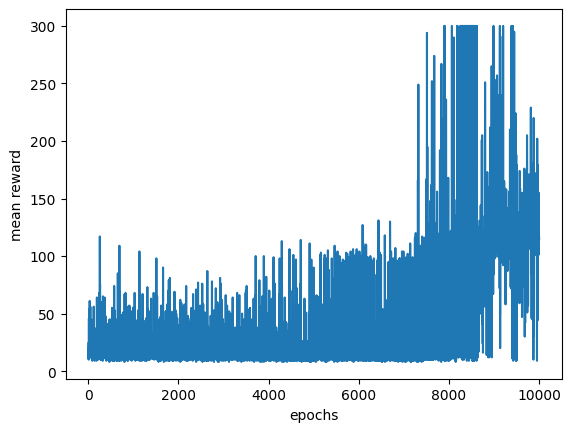

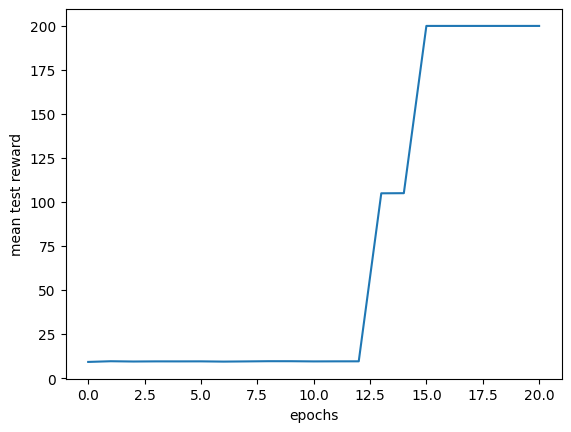

best_res_idx  0   200.0
[4, 6, 6, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 11.0
0  success percent   0.0  mean reward  9.44
Best rewards so far: 19.0
Best rewards so far: 33.0
Best rewards so far: 53.0
Best rewards so far: 82.0
0  success percent   0.0  mean reward  9.35
Best rewards so far: 136.0
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.28
0  success percent   0.0  mean reward  9.41
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.33
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  9.51
0  success percent   0.0  mean reward  9.46
Episode 4000 Epsilon 0.600400000000044
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.36
Episode 5000 Epsilon 0.500400000000055
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.46
Ep

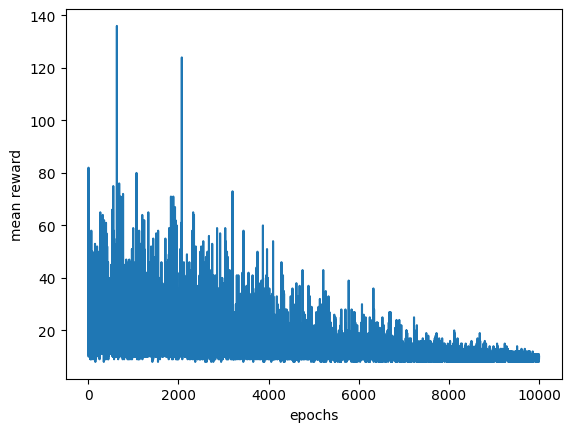

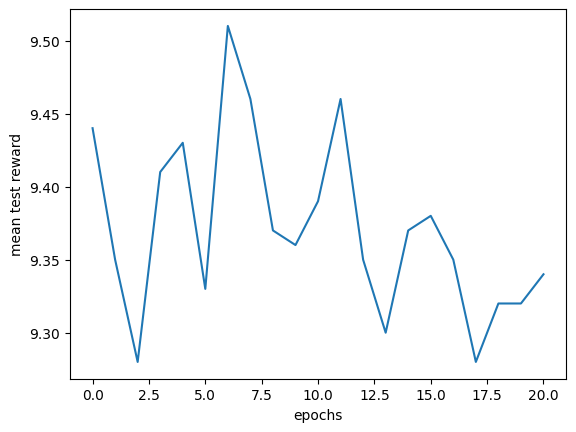

best_res_idx  0   9.43
TIME:  0.7039563417434692  min

HIDDEN SIZE:  4 3
Best rewards so far: 45.0
0  success percent   0.0  mean reward  9.45
Best rewards so far: 48.0
Best rewards so far: 63.0
Best rewards so far: 108.0
0  success percent   6.0  mean reward  22.44
Episode 1000 Epsilon 0.900200000000011
0  success percent   5.0  mean reward  21.46
0  success percent   8.0  mean reward  26.9
Episode 2000 Epsilon 0.800200000000022
0  success percent   8.0  mean reward  26.7
0  success percent   5.0  mean reward  21.28
Episode 3000 Epsilon 0.700200000000033
0  success percent   8.0  mean reward  26.53
0  success percent   4.0  mean reward  18.54
Episode 4000 Epsilon 0.600200000000044
0  success percent   4.0  mean reward  19.1
0  success percent   6.0  mean reward  22.95
Episode 5000 Epsilon 0.500200000000055
0  success percent   9.0  mean reward  28.3
0  success percent   9.0  mean reward  28.14
Episode 6000 Epsilon 0.40020000000006606
0  success percent   2.0  mean reward  14.69
0  suc

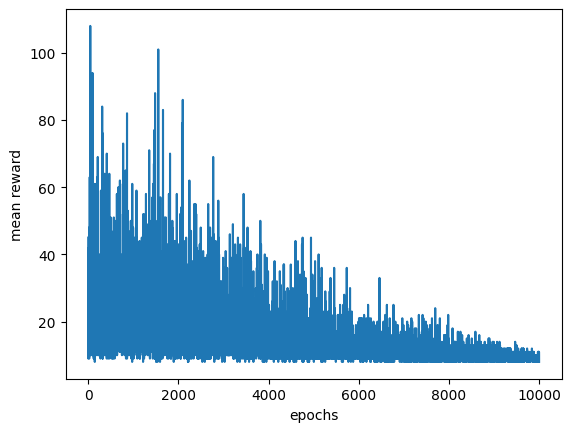

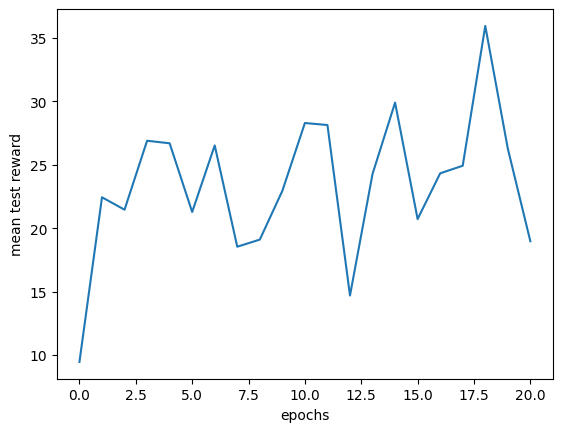

best_res_idx  0   30.18
TIME:  0.7419653296470642  min

HIDDEN SIZE:  4 4
Best rewards so far: 56.0
0  success percent   13.0  mean reward  35.96
Best rewards so far: 99.0
0  success percent   0.0  mean reward  9.49
Best rewards so far: 106.0
Episode 1000 Epsilon 0.900100000000011
0  success percent   0.0  mean reward  9.34
Best rewards so far: 117.0
0  success percent   0.0  mean reward  20.13
Episode 2000 Epsilon 0.800100000000022
0  success percent   0.0  mean reward  20.46
0  success percent   0.0  mean reward  20.49
Episode 3000 Epsilon 0.700100000000033
0  success percent   0.0  mean reward  21.66
0  success percent   0.0  mean reward  21.03
Episode 4000 Epsilon 0.600100000000044
0  success percent   0.0  mean reward  21.66
0  success percent   0.0  mean reward  22.12
Episode 5000 Epsilon 0.5001000000000551
0  success percent   0.0  mean reward  21.19
0  success percent   0.0  mean reward  19.9
Episode 6000 Epsilon 0.40010000000006607
0  success percent   0.0  mean reward  19.71


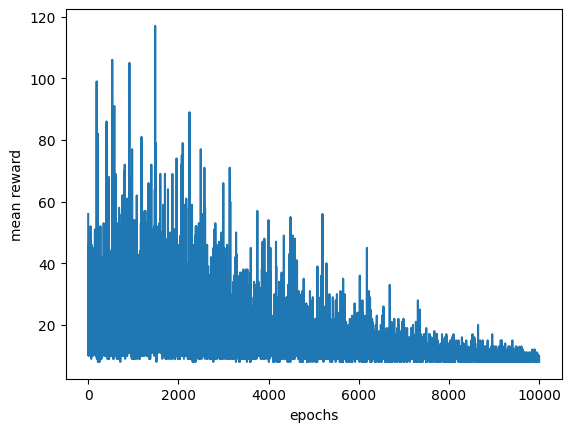

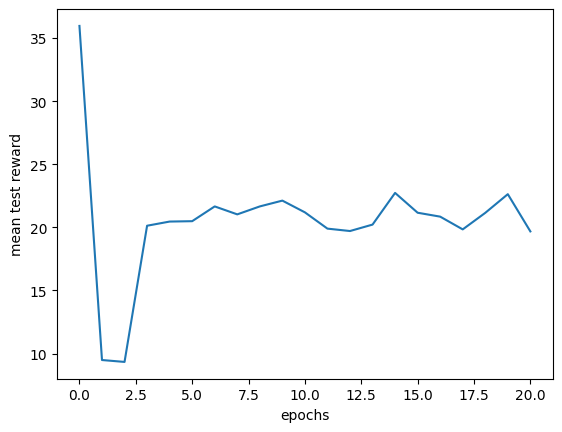

best_res_idx  0   20.46
TIME:  0.7303714195887248  min

HIDDEN SIZE:  5 4
Best rewards so far: 15.0
0  success percent   0.0  mean reward  39.69
Best rewards so far: 26.0
Best rewards so far: 51.0
Best rewards so far: 100.0
0  success percent   0.0  mean reward  9.41
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.2
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.36
0  success percent   0.0  mean reward  9.31
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.42
0  success percent   0.0  mean reward  9.52
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.4
0  success percent   0.0  mean reward  9.4
Best rewards so far: 121.0
Episode 5000 Epsilon 0.500300000000055
0  success percent   20.0  mean reward  94.81
0  success percent   9.0  mean reward  79.74
Episode 6000 Epsilon 0.40030000000006605
0  success percent   17.0  me

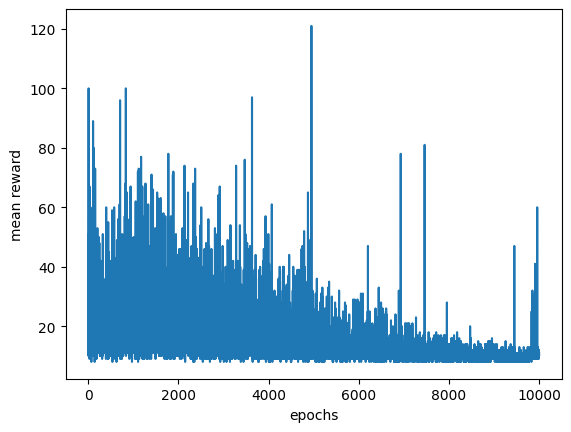

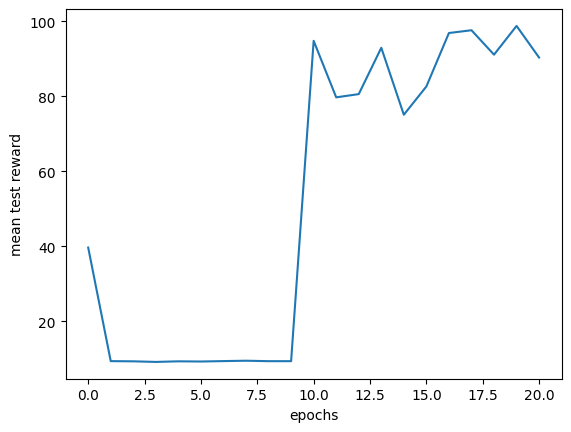

best_res_idx  0   93.1
TIME:  0.7889003992080689  min

HIDDEN SIZE:  5 5
Best rewards so far: 13.0
0  success percent   19.0  mean reward  89.55
Best rewards so far: 48.0
Best rewards so far: 56.0
Best rewards so far: 71.0
Best rewards so far: 101.0
Best rewards so far: 121.0
0  success percent   0.0  mean reward  11.63
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  11.85
0  success percent   0.0  mean reward  11.8
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  12.06
0  success percent   0.0  mean reward  11.99
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  11.67
Best rewards so far: 143.0
0  success percent   0.0  mean reward  124.19
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  123.1
Best rewards so far: 151.0
0  success percent   9.0  mean reward  84.96
Best rewards so far: 196.0
Best rewards so far: 247.0
Best rewards so far: 275.0
Best rewards so far: 298.0


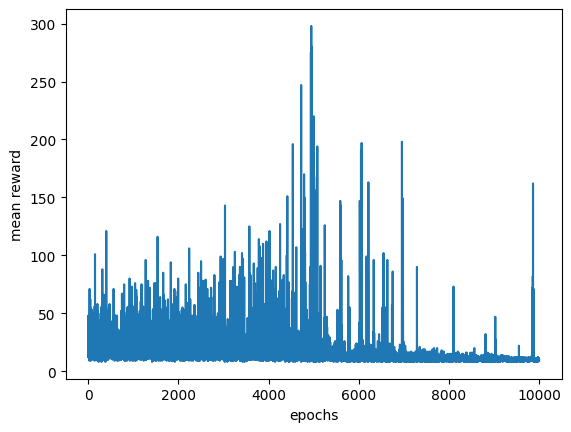

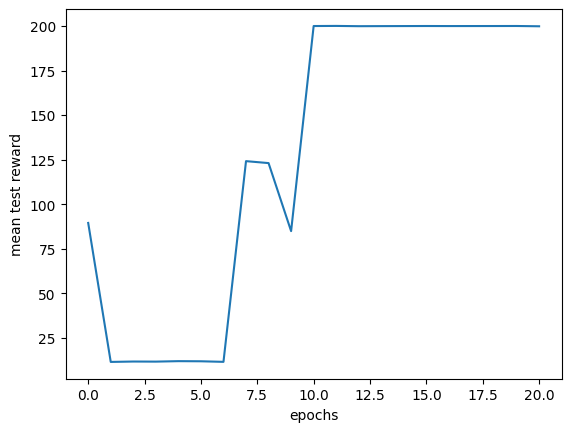

best_res_idx  0   200.0
[4, 5, 5, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 15.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 21.0
Best rewards so far: 22.0
Best rewards so far: 49.0
Best rewards so far: 77.0
Best rewards so far: 90.0
Best rewards so far: 92.0
0  success percent   0.0  mean reward  9.29
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.3
Best rewards so far: 96.0
0  success percent   0.0  mean reward  9.31
Best rewards so far: 104.0
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.51
0  success percent   0.0  mean reward  9.48
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.48
0  success percent   0.0  mean reward  9.49
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.34
Episode 5000 Epsilon 0.500300000000055
0  success pe

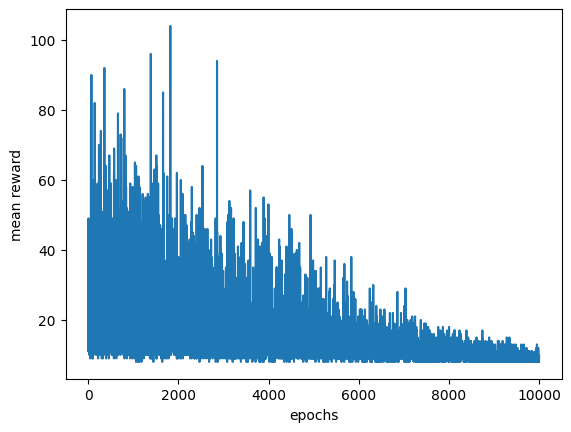

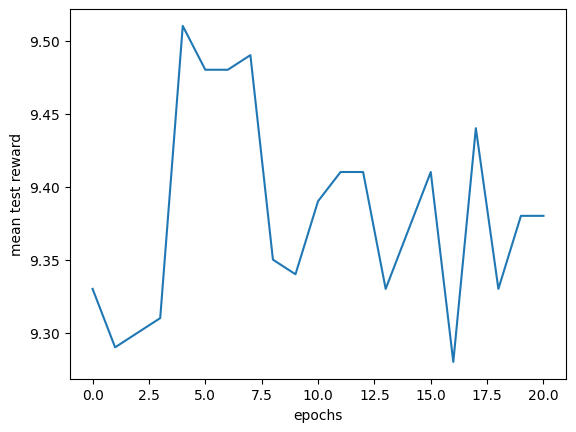

best_res_idx  0   9.35
TIME:  0.7255679329236349  min

HIDDEN SIZE:  4 3
Best rewards so far: 10.0
0  success percent   0.0  mean reward  9.4
Best rewards so far: 19.0
Best rewards so far: 31.0
Best rewards so far: 54.0
Best rewards so far: 57.0
Best rewards so far: 58.0
Best rewards so far: 66.0
Best rewards so far: 67.0
Best rewards so far: 75.0
Best rewards so far: 92.0
0  success percent   0.0  mean reward  9.4
Episode 1000 Epsilon 0.900400000000011
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.36
Episode 2000 Epsilon 0.800400000000022
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.37
Best rewards so far: 93.0
Episode 3000 Epsilon 0.700400000000033
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.33
Episode 4000 Epsilon 0.600400000000044
0  success percent   0.0  mean reward  9.37
0  success percent   0.0  mean reward  9.32
Episode 5000 Epsilon 0.500400000000055
0  succe

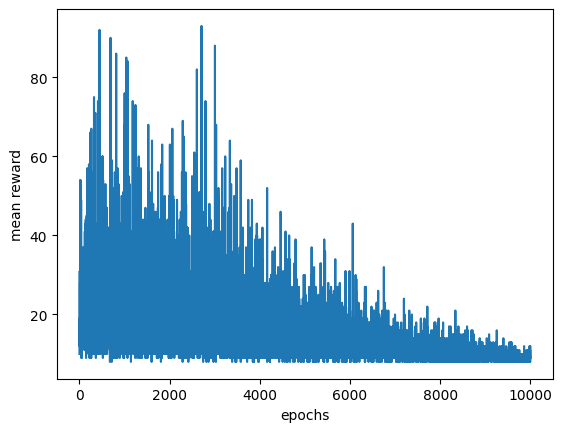

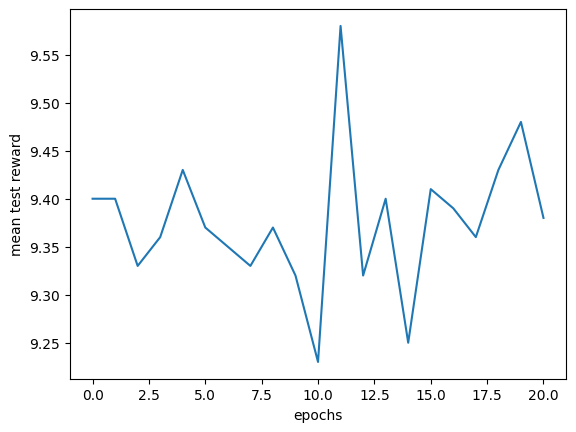

best_res_idx  0   9.57
TIME:  0.7414947350819906  min

HIDDEN SIZE:  4 4
Best rewards so far: 14.0
0  success percent   0.0  mean reward  9.43
Best rewards so far: 25.0
Best rewards so far: 28.0
Best rewards so far: 40.0
Best rewards so far: 100.0
0  success percent   0.0  mean reward  9.3
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.38
0  success percent   0.0  mean reward  9.46
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.34
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.23
Best rewards so far: 131.0
0  success percent   100.0  mean reward  200.0
Episode 4000 Epsilon 0.600300000000044
0  success percent   100.0  mean reward  200.0
0  success percent   100.0  mean reward  200.0
Episode 5000 Epsilon 0.500300000000055
0  success percent   100.0  mean reward  200.0
0  success percent   100.0  mean reward  200.0
Episode 6000 Epsilon 0.400300000

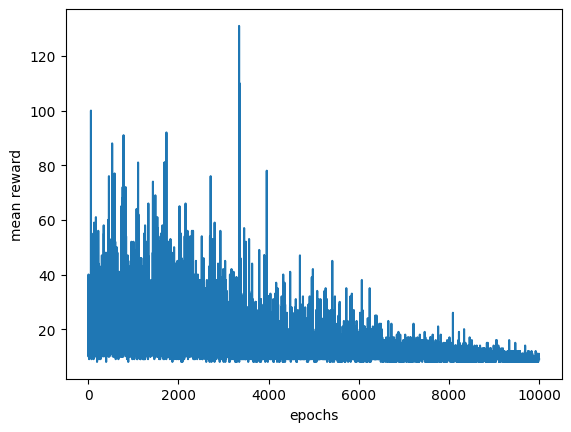

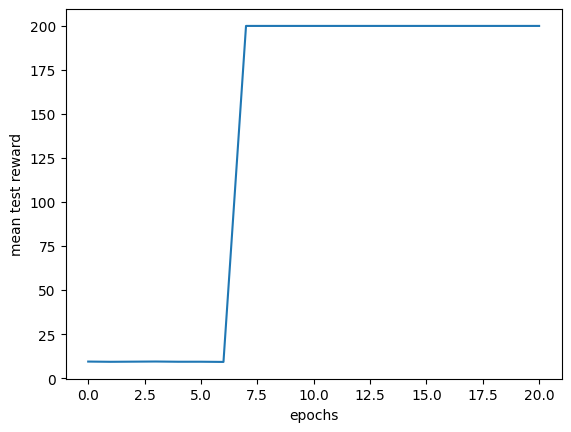

best_res_idx  0   200.0
[4, 4, 4, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 19.0
0  success percent   0.0  mean reward  9.4
Best rewards so far: 54.0
Best rewards so far: 120.0
Best rewards so far: 135.0
0  success percent   0.0  mean reward  9.5
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.35
0  success percent   0.0  mean reward  9.34
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.29
0  success percent   0.0  mean reward  9.29
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.45
0  success percent   0.0  mean reward  9.37
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.2
0  success percent   0.0  mean reward  9.38
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.39
Best rewards so far: 193.0
0  success percent   16.0  mean reward  44.85
Best rewards so far: 223.0


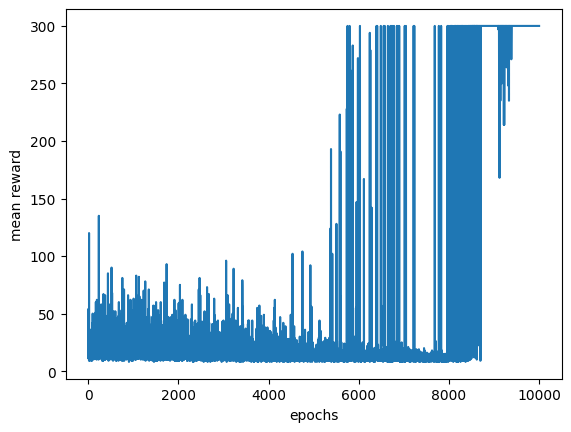

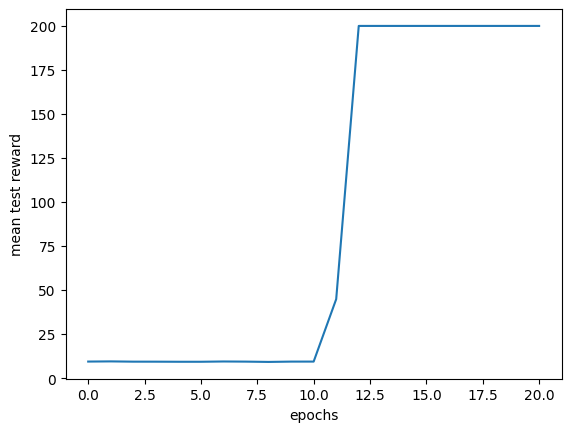

best_res_idx  0   200.0
[4, 3, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
Best rewards so far: 32.0
0  success percent   0.0  mean reward  9.37
Best rewards so far: 44.0
Best rewards so far: 60.0
Best rewards so far: 63.0
Best rewards so far: 71.0
Best rewards so far: 80.0
0  success percent   0.0  mean reward  9.42
Best rewards so far: 86.0
Best rewards so far: 102.0
Episode 1000 Epsilon 0.900300000000011
0  success percent   0.0  mean reward  9.26
0  success percent   0.0  mean reward  9.3
Episode 2000 Epsilon 0.800300000000022
0  success percent   0.0  mean reward  9.52
0  success percent   0.0  mean reward  9.31
Episode 3000 Epsilon 0.700300000000033
0  success percent   0.0  mean reward  9.32
0  success percent   0.0  mean reward  9.34
Episode 4000 Epsilon 0.600300000000044
0  success percent   0.0  mean reward  9.39
0  success percent   0.0  mean reward  9.47
Episode 5000 Epsilon 0.500300000000055
0  success percent   0.0  mean reward  

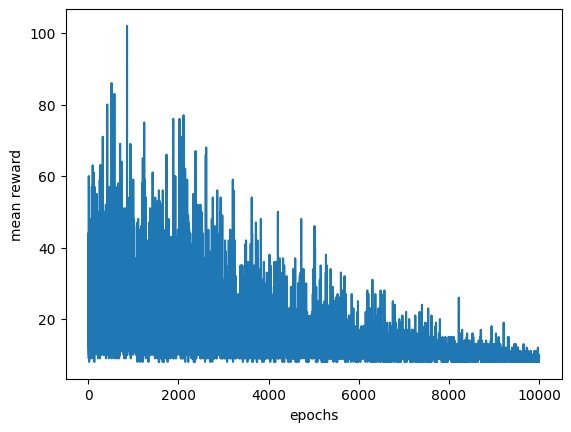

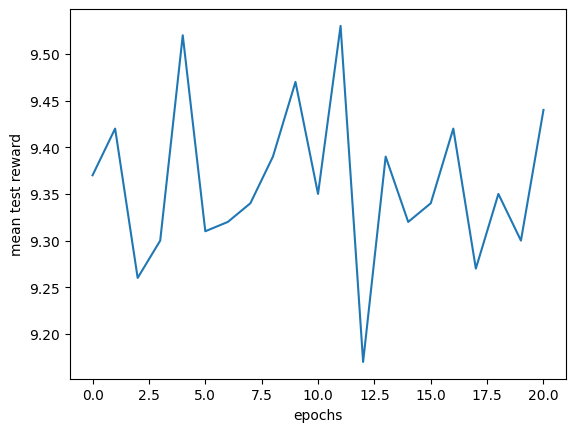

best_res_idx  0   9.33
TIME:  0.6941962401072185  min

HIDDEN SIZE:  4 3
Best rewards so far: 17.0
0  success percent   0.0  mean reward  9.4
Best rewards so far: 29.0
Best rewards so far: 33.0
Best rewards so far: 65.0
Best rewards so far: 80.0
0  success percent   0.0  mean reward  9.37
Best rewards so far: 99.0
Episode 1000 Epsilon 0.900200000000011
0  success percent   0.0  mean reward  9.3
0  success percent   0.0  mean reward  9.23
Episode 2000 Epsilon 0.800200000000022
0  success percent   0.0  mean reward  9.43
0  success percent   0.0  mean reward  9.41
Episode 3000 Epsilon 0.700200000000033
0  success percent   0.0  mean reward  9.46
0  success percent   0.0  mean reward  9.45
Episode 4000 Epsilon 0.600200000000044
0  success percent   0.0  mean reward  9.33
0  success percent   0.0  mean reward  9.37
Episode 5000 Epsilon 0.500200000000055
0  success percent   0.0  mean reward  9.34
0  success percent   0.0  mean reward  9.13
Best rewards so far: 300.0
Episode 6000 Epsilon 0.

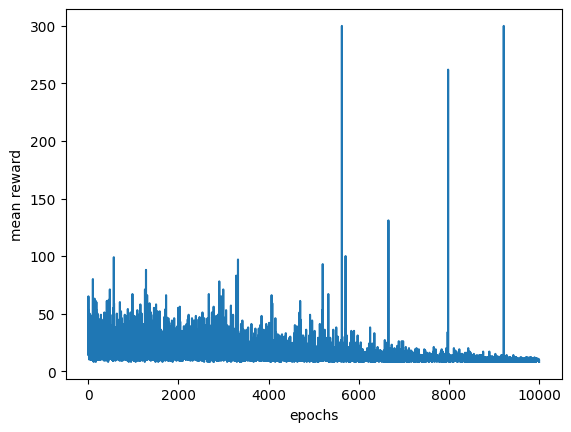

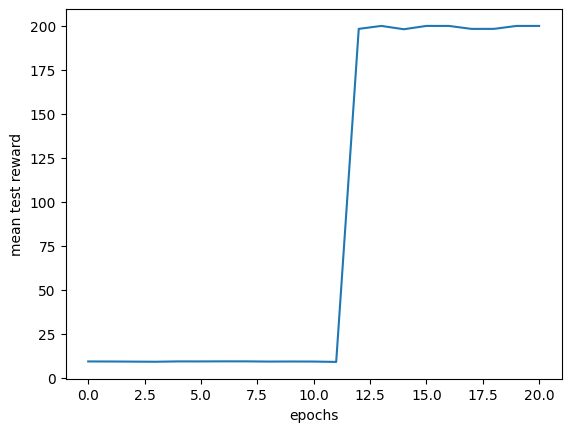

best_res_idx  0   200.0
[4, 4, 3, 2] Good found---------------------------------------------------
TOTAL TIME:  31.06313086748123  min


In [18]:
roll = '114'
learning_rate_a = 0.1
game_name = "CartPole-v0"
env = gym.make(game_name)
in_states = env.observation_space.shape[0]
out_actions = env.action_space.n
env.close()
a_types = [ '', 'ReLU', 'ReLU', 'Linear']

num_of_nn = 1

        
episodes = 10000

total_time_start = time.time()
n_tests = 10
TSR = 95

found_shapes = []

for test in range(n_tests):

    best_SR = 0
    
    loop_cnt = 8
    
    tmp_idx = 0
    t1 = 3
    t2 = 3
    
    optimizer_ = 'Adam'
    for y in range(loop_cnt):
        
        this_time_start = time.time()
        
        print('\nHIDDEN SIZE: ', t1, t2)
        
        h1_nodes = t1
        h2_nodes = t2
        
        dqn_s = []
        
        ct = datetime.datetime.now()
        ct = str(ct)
        ct = ct.replace(":", "-")
        ct = ct.replace(" ", "_")
        ct = ct[:-7]
        ct = roll + '/' + ct + '_' + str(t1)+'_'+str(t2)
        
        # preset models
        for i in range(num_of_nn):
            policy_dqn = plastic_nn(optimizer=optimizer_)
            
    
            topology = [in_states, h1_nodes, h2_nodes,  out_actions]
            dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 1)
            dqn_test.set_tag(str(i))
            dqn_test.save_info(f'lr: {learning_rate_a} \n{topology} \na:{a_types}\n')
            
            dqn_s.append(dqn_test)
            
            if (y == 0):
                layers_net = [input_layer(in_states), 
                layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_types[1]), 
                layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_types[2]), 
                layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_types[3])]
                
                policy_dqn.append_layers(layers_net)
            else:
                policy_dqn = next_load_policy
            policy_dqn.optimizer_reset()
            dqn_s[i].init_train_data(policy_dqn, episodes)
        
        # for i in range(num_of_nn):
        #     dqn_s[i].policy_dqn.print_info()    
        
        summs = np.zeros(shape = episodes+1)
        tests = np.zeros(shape = int(episodes/500) + 1)
        
        
        for e in range(episodes + 1):
            for i in range (num_of_nn):  
                summs[e] += dqn_s[i].run_one_epoch(e)
                if (e % 500 == 0):
                    test_dqn_ = plastic_nn(optimizer=optimizer_)
                    test_dqn_.load(f'{dqn_s[i].path}/mc_policy_best')
                    succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn_, episodes = 100)
                    print(i,' success percent  ', succ_perc, ' mean reward ', mean_reward)
                    tests[int(e/500)] += mean_reward
    
        # for i in range(num_of_nn):
        #     dqn_s[i].policy_dqn.print_info()

        # TESTING
        best_test_result = -1
        best_res_idx = -1
        
        for i in range (num_of_nn):
            test_dqn = plastic_nn(optimizer=optimizer_)
            test_dqn.load(f'{dqn_s[i].path}/mc_policy_best')
            succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn, episodes = 100)
            if (mean_reward > best_test_result):
                best_test_result = mean_reward
                best_res_idx = i
    
                if (succ_perc > best_SR):
                    best_SR = succ_perc
                
            print('final: success percent  ', succ_perc, ' mean reward ', mean_reward)
            dqn_s[i].post_train()
        
       
    
        mean_results = np.asarray(summs) / num_of_nn
        show_plot('epochs', 'mean reward', mean_results, f'{dqn_s[0].ct}/mean_values.png')
    
        mean_test_reward = np.asarray(tests) / num_of_nn
        show_plot('epochs', 'mean test reward', mean_test_reward, f'{dqn_s[0].ct}/mean_test_reward.png')
           
        print('best_res_idx ', best_res_idx, ' ', best_test_result)
        
        if (best_SR > TSR):
            print(topology, 'Good found---------------------------------------------------')
            found_shapes.append((topology, dqn_s[best_res_idx].policy_dqn))
            break
            
        
    
        next_load_policy = plastic_nn(optimizer=optimizer_)
        next_load_policy.load(f'{dqn_s[best_res_idx].path}/mc_policy_best')
    
        next_load_policy.add_neuron(layer_number = (y%2)+1, n_of_neurons = 1, value = 'r')
        #next_load_policy.add_neuron(layer_number = 1, n_of_neurons = 2, value = 'r')
        #next_load_policy.add_neuron(layer_number = 2, n_of_neurons = 2, value = 'r')
        
        if (y%2 == 0):
            t1 += 1
        else:
            t2 += 1
            
        this_time_end = time.time()
        this_time_diff = this_time_end - this_time_start
        print('TIME: ', this_time_diff/60, ' min')
        
    
    
total_time_end = time.time()
total_time_diff = total_time_end - total_time_start
print('TOTAL TIME: ', total_time_diff/60, ' min')

In [19]:
for s, gp in found_shapes:
    print (s)

[4, 5, 5, 2]
[4, 3, 3, 2]
[4, 5, 4, 2]
[4, 4, 3, 2]
[4, 6, 6, 2]
[4, 5, 5, 2]
[4, 4, 4, 2]
[4, 3, 3, 2]
[4, 4, 3, 2]



HIDDEN SIZE:  3 3
NAME:  noname  ( 4 )
# 0
IN LAYER
size:  4

# 1
my size:  3
prev size:  4
w:  (3, 4) [[0.17552293 0.6310944  0.33161905 0.41556052]
 [0.08844506 0.0053932  0.74882229 0.05354406]
 [0.65383667 0.04236475 0.54916176 0.70184037]] 

b:  (3, 1) [[0.95914029]
 [0.73509303]
 [0.82474073]] 


# 2
my size:  3
prev size:  3
w:  (3, 3) [[0.26691783 0.81041311 0.34550547]
 [0.85824008 0.23445772 0.31649647]
 [0.24654516 0.27841513 0.46418587]] 

b:  (3, 1) [[0.54666999]
 [0.83127699]
 [0.76322838]] 


# 3
my size:  2
prev size:  3
w:  (2, 3) [[0.33866742 0.06608802 0.74069435]
 [0.74652705 0.14039975 0.65262759]] 

b:  (2, 1) [[0.61578624]
 [0.0662356 ]] 


Best rewards so far: 14.0
0  success percent   0.0  mean reward  10.26
Best rewards so far: 20.0
Best rewards so far: 27.0
Best rewards so far: 33.0
Best rewards so far: 43.0
Best rewards so far: 71.0
Best rewards so far: 78.0
0  success percent   100.0  mean reward  200.0
Best rewards so far: 89.0
Episode 1000 Epsilon 0.9003

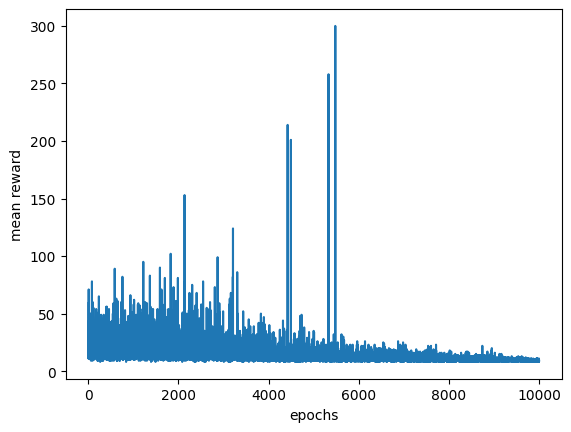

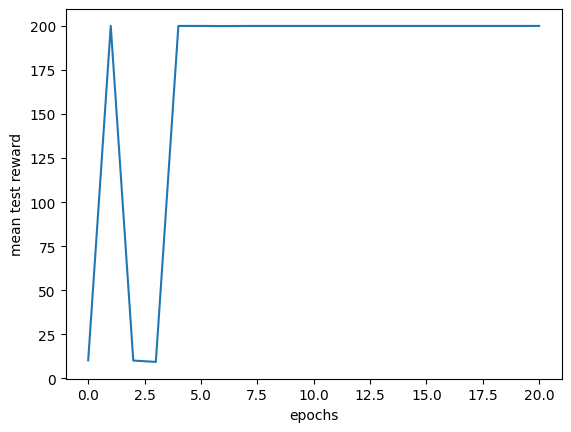

best_res_idx  0   200.0
[4, 3, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
NAME:  noname  ( 4 )
# 0
IN LAYER
size:  4

# 1
my size:  3
prev size:  4
w:  (3, 4) [[0.38250781 0.20590657 0.61203277 0.41865475]
 [0.98236652 0.89745004 0.30843607 0.91409428]
 [0.63425203 0.82731576 0.50149706 0.45288039]] 

b:  (3, 1) [[0.42692144]
 [0.30479935]
 [0.59244667]] 


# 2
my size:  3
prev size:  3
w:  (3, 3) [[0.47878215 0.48076893 0.94238224]
 [0.44429973 0.29270145 0.45165492]
 [0.37470105 0.57776    0.30266181]] 

b:  (3, 1) [[0.1829131 ]
 [0.99114494]
 [0.22497357]] 


# 3
my size:  2
prev size:  3
w:  (2, 3) [[0.50280532 0.30591151 0.86343212]
 [0.81526672 0.02872248 0.53795734]] 

b:  (2, 1) [[0.35326434]
 [0.96346908]] 


Best rewards so far: 13.0
0  success percent   0.0  mean reward  9.42
Best rewards so far: 19.0
Best rewards so far: 23.0
Best rewards so far: 24.0
Best rewards so far: 34.0
Best rewards so far: 45.0
Best rewards so far: 50.0
Be

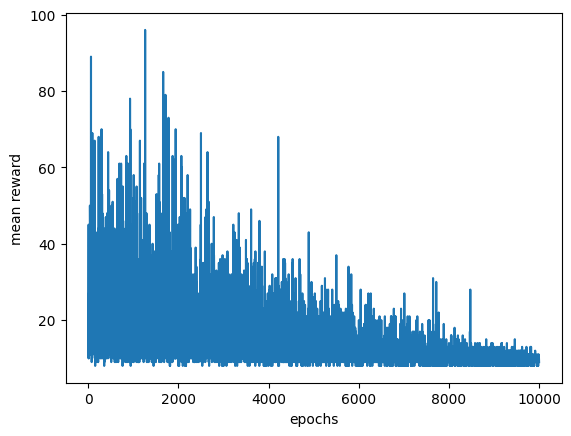

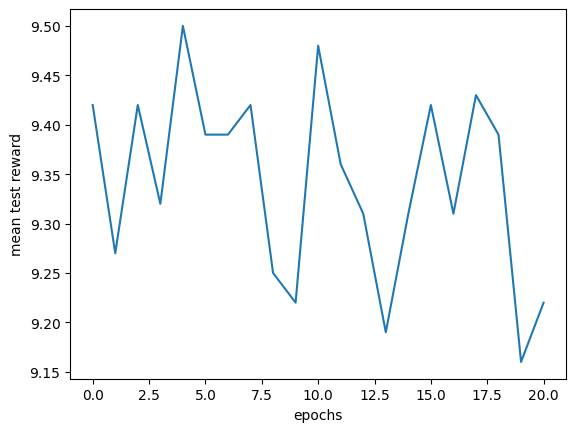

best_res_idx  0   9.3
TIME:  0.5344290256500244  min

HIDDEN SIZE:  4 3
NAME:  noname  ( 4 )
# 0
IN LAYER
size:  4

# 1
my size:  4
prev size:  4
w:  (4, 4) [[ 0.21147454  0.34137922 -0.18564319  0.34143263]
 [ 0.31555545  0.95232717 -0.95669895  0.6464467 ]
 [ 2.00727386  1.85143166  1.75138149  1.49900811]
 [ 0.          0.          0.          0.        ]] 

b:  (4, 1) [[-0.05472002]
 [-0.29611563]
 [ 1.05950676]
 [ 0.        ]] 


# 2
my size:  3
prev size:  4
w:  (3, 4) [[-0.05117393  0.27836901  0.86135771  0.        ]
 [-0.17304355 -0.19396293 -0.0134355   0.        ]
 [-0.06601053  0.14274334  0.01981434  0.        ]] 

b:  (3, 1) [[-0.00766761]
 [-0.01211171]
 [-0.0020365 ]] 


# 3
my size:  2
prev size:  3
w:  (2, 3) [[0.73453769 0.01480524 0.02372396]
 [0.73543579 0.00251172 0.0237014 ]] 

b:  (2, 1) [[1.77315933]
 [1.95649039]] 


Best rewards so far: 32.0
0  success percent   0.0  mean reward  9.34
Best rewards so far: 43.0
Best rewards so far: 52.0
Best rewards so far: 62

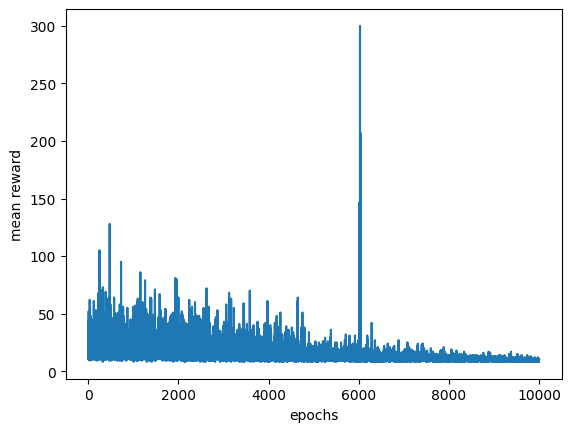

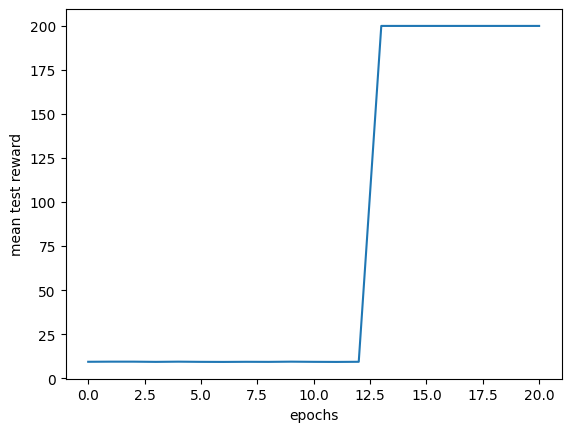

best_res_idx  0   200.0
[4, 4, 3, 2] Good found---------------------------------------------------

HIDDEN SIZE:  3 3
NAME:  noname  ( 4 )
# 0
IN LAYER
size:  4

# 1
my size:  3
prev size:  4
w:  (3, 4) [[0.99554219 0.28379548 0.00791648 0.43622829]
 [0.85095788 0.60702233 0.5012233  0.65926392]
 [0.94342365 0.30982076 0.20295154 0.48856979]] 

b:  (3, 1) [[0.35835739]
 [0.01138061]
 [0.86615524]] 


# 2
my size:  3
prev size:  3
w:  (3, 3) [[0.97274385 0.85297818 0.81409273]
 [0.47987077 0.92314543 0.48074115]
 [0.56637581 0.81199508 0.95011011]] 

b:  (3, 1) [[0.8937825 ]
 [0.35340956]
 [0.90793935]] 


# 3
my size:  2
prev size:  3
w:  (2, 3) [[0.68694884 0.36810338 0.33840181]
 [0.80539481 0.51061381 0.25366318]] 

b:  (2, 1) [[0.06988859]
 [0.0675983 ]] 


Best rewards so far: 18.0
0  success percent   0.0  mean reward  9.3
Best rewards so far: 43.0
Best rewards so far: 53.0
Best rewards so far: 57.0
Best rewards so far: 58.0
Best rewards so far: 71.0
Best rewards so far: 108.0
0 

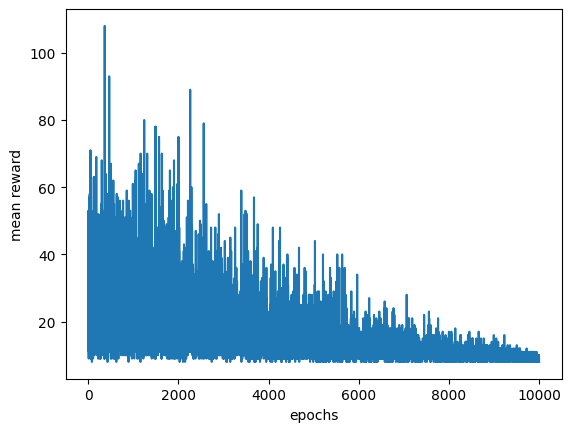

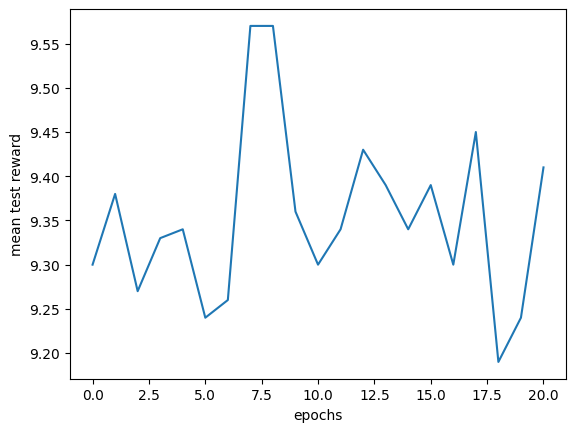

best_res_idx  0   9.33
TIME:  0.5121994058291117  min

HIDDEN SIZE:  4 3
NAME:  noname  ( 4 )
# 0
IN LAYER
size:  4

# 1
my size:  4
prev size:  4
w:  (4, 4) [[ 1.85688293  0.46847588 -0.41534832  0.72791632]
 [ 0.00709738  1.02688372  0.20970666  0.43909005]
 [ 1.53116887  0.62432666  0.57666283  0.92613844]
 [ 0.          0.          0.          0.        ]] 

b:  (4, 1) [[ 0.27176879]
 [-0.33803818]
 [ 0.96271934]
 [ 0.        ]] 


# 2
my size:  3
prev size:  4
w:  (3, 4) [[ 0.63096957  0.31253142  0.8740688   0.        ]
 [-0.07415912  0.31135791  0.22223577  0.        ]
 [-0.11621153  0.48401195  0.53453095  0.        ]] 

b:  (3, 1) [[1.06913146]
 [0.23502679]
 [0.61308752]] 


# 3
my size:  2
prev size:  3
w:  (2, 3) [[0.86796265 0.23864589 0.37794479]
 [0.91081942 0.25937612 0.33588825]] 

b:  (2, 1) [[0.77693067]
 [0.61811493]] 


Best rewards so far: 18.0
0  success percent   0.0  mean reward  9.33
Best rewards so far: 20.0
Best rewards so far: 36.0
Best rewards so far: 44.0

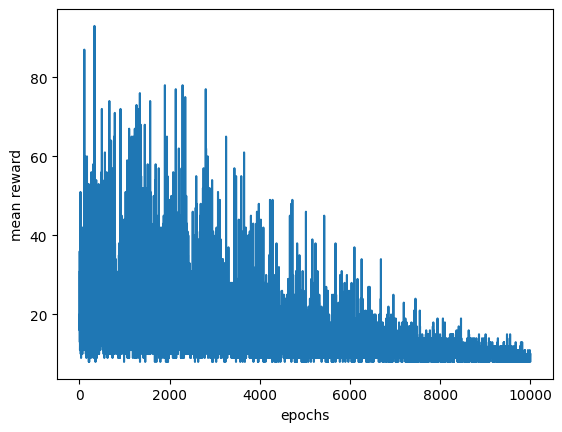

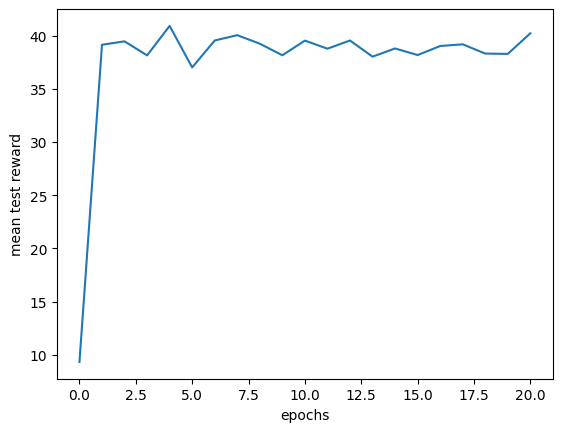

best_res_idx  0   38.52
TIME:  0.5988811095555623  min

HIDDEN SIZE:  4 4
NAME:  noname  ( 4 )
# 0
IN LAYER
size:  4

# 1
my size:  4
prev size:  4
w:  (4, 4) [[ 2.66546449  0.46923202 -1.27826766  0.73737449]
 [-1.38064397  0.99035264  6.34871324  1.10742866]
 [ 1.44700338  0.91986448  0.82076913  1.06691659]
 [ 0.          0.          0.          0.        ]] 

b:  (4, 1) [[ 0.20917763]
 [-1.76510836]
 [ 1.228583  ]
 [ 0.        ]] 


# 2
my size:  4
prev size:  4
w:  (4, 4) [[ 0.43696004 -1.93271034  0.89744651  0.        ]
 [-0.42290497 -0.64543521 -0.02288825  0.        ]
 [-0.27965041 -1.46607786  0.36991592  0.        ]
 [ 0.          0.          0.          0.        ]] 

b:  (4, 1) [[0.98494698]
 [0.03923378]
 [0.16987542]
 [0.        ]] 


# 3
my size:  2
prev size:  4
w:  (2, 4) [[ 0.98162251 -0.02504921  0.31965169  0.        ]
 [ 1.03748038 -0.00498661  0.33054041  0.        ]] 

b:  (2, 1) [[1.05285952]
 [0.91416346]] 


Best rewards so far: 18.0
0  success percent   0.0 

In [ ]:
roll = '11_t'
learning_rate_a = 0.1
game_name = "CartPole-v0"
env = gym.make(game_name)
in_states = env.observation_space.shape[0]
out_actions = env.action_space.n
env.close()
a_types = [ '', 'ReLU', 'ReLU', 'Linear']

num_of_nn = 1

        
episodes = 10000

total_time_start = time.time()
n_tests = 5
TSR = 95

for test in range(n_tests):

    best_SR = 0
    
    loop_cnt = 5
    
    tmp_idx = 0
    t1 = 3
    t2 = 3
    
    optimizer_ = 'Adam'
    for y in range(loop_cnt):
        
        this_time_start = time.time()
        
        print('\nHIDDEN SIZE: ', t1, t2)
        
        h1_nodes = t1
        h2_nodes = t2
        
        dqn_s = []
        
        ct = datetime.datetime.now()
        ct = str(ct)
        ct = ct.replace(":", "-")
        ct = ct.replace(" ", "_")
        ct = ct[:-7]
        ct = roll + '/' + ct + '_' + str(t1)+'_'+str(t2)
        
        # preset models
        for i in range(num_of_nn):
            policy_dqn = plastic_nn(optimizer=optimizer_)
            
    
            topology = [in_states, h1_nodes, h2_nodes,  out_actions]
            dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 1)
            dqn_test.set_tag(str(i))
            dqn_test.save_info(f'lr: {learning_rate_a} \n{topology} \na:{a_types}\n')
            
            dqn_s.append(dqn_test)
            
            if (y == 0):
                layers_net = [input_layer(in_states), 
                layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_types[1]), 
                layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_types[2]), 
                layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_types[3])]
                
                policy_dqn.append_layers(layers_net)
            else:
                policy_dqn = next_load_policy
            policy_dqn.optimizer_reset()
            dqn_s[i].init_train_data(policy_dqn, episodes)
        
        for i in range(num_of_nn):
            dqn_s[i].policy_dqn.print_info()    
        
        summs = np.zeros(shape = episodes+1)
        tests = np.zeros(shape = int(episodes/500) + 1)
        
        
        for e in range(episodes + 1):
            for i in range (num_of_nn):  
                summs[e] += dqn_s[i].run_one_epoch(e)
                if (e % 500 == 0):
                    test_dqn_ = plastic_nn(optimizer=optimizer_)
                    test_dqn_.load(f'{dqn_s[i].path}/mc_policy_best')
                    succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn_, episodes = 100)
                    print(i,' success percent  ', succ_perc, ' mean reward ', mean_reward)
                    tests[int(e/500)] += mean_reward
    
        for i in range(num_of_nn):
            dqn_s[i].policy_dqn.print_info()

        # TESTING
        best_test_result = -1
        best_res_idx = -1
        
        for i in range (num_of_nn):
            test_dqn = plastic_nn(optimizer=optimizer_)
            test_dqn.load(f'{dqn_s[i].path}/mc_policy_best')
            succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn, episodes = 100)
            if (mean_reward > best_test_result):
                best_test_result = mean_reward
                best_res_idx = i
    
                if (succ_perc > best_SR):
                    best_SR = succ_perc
                
            print('final: success percent  ', succ_perc, ' mean reward ', mean_reward)
            dqn_s[i].post_train()
        
       
    
        mean_results = np.asarray(summs) / num_of_nn
        show_plot('epochs', 'mean reward', mean_results, f'{dqn_s[0].ct}/mean_values.png')
    
        mean_test_reward = np.asarray(tests) / num_of_nn
        show_plot('epochs', 'mean test reward', mean_test_reward, f'{dqn_s[0].ct}/mean_test_reward.png')
           
        print('best_res_idx ', best_res_idx, ' ', best_test_result)
        
        if (best_SR > TSR):
            print(topology, 'Good found---------------------------------------------------')
            break
            
        
    
        next_load_policy = plastic_nn(optimizer=optimizer_)
        next_load_policy.load(f'{dqn_s[best_res_idx].path}/mc_policy_best')
    
        next_load_policy.add_neuron(layer_number = (y%2)+1, n_of_neurons = 1, value = 0)

        if (y%2 == 0):
            t1 += 1
        else:
            t2 += 1
            
        this_time_end = time.time()
        this_time_diff = this_time_end - this_time_start
        print('TIME: ', this_time_diff/60, ' min')
        
    
    
total_time_end = time.time()
total_time_diff = total_time_end - total_time_start
print('TOTAL TIME: ', total_time_diff/60, ' min')